# Variation data analysis
Data is gathered from: 
- UniProt (isoforms, natural variants, disease variants), 
- Chembl (assay data) 
- PDBe (binding site annotations)

## 1. Variation data from UniProt (isoforms, natural variants, mutagenesis, disease SNPs)
The disease associated SNPs are extraced with RegEx. Some could be missed due to incoherent UniProt annotation. Therefore, step 2 gets all disease associated variants using UniProt annotation keyword.

In [1]:
import sys
import numpy as np
import pandas as pd
import pkg_resources
import ast
import time
import json
import re
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib_venn as vplt
import itertools

# from sqlalchemy import create_engine

PY3 = sys.version > '3'
if PY3:
    import urllib.request as urllib2
    from urllib.error import HTTPError
else:
    import urllib2
    from urllib2.error import HTTPError


In [2]:
full_url = 'https://www.uniprot.org/uniprot/?query=proteome:UP000005640&format=tab&columns=id,entry%20name,protein%20names,genes,comment(ALTERNATIVE%20PRODUCTS),feature(NATURAL%20VARIANT),feature(MUTAGENESIS)'
#from ot_tractability_pipeline_v2.buckets_ab import Antibody_buckets

def make_request(url, data):
    request = urllib2.Request(url)
    try:
        url_file = urllib2.urlopen(request, data)
    except urllib2.HTTPError as e:
        if e.code == 404:
            print("[NOTFOUND %d] %s" % (e.code, url))
        else:
            print("[ERROR %d] %s" % (e.code, url))
        return None
    return url_file.read().decode()


In [3]:
Uniprot_human_proteome = make_request(full_url, data=None)
Uniprot_human_proteome = [x.split('\t') for x in Uniprot_human_proteome.split('\n')]
human_proteome = pd.DataFrame(Uniprot_human_proteome[1:], columns=Uniprot_human_proteome[0])
human_proteome.rename(columns={'Entry': 'accession'}, inplace=True)
# only keep row when 'Entry name' is available (discard NAN row)
human_proteome = human_proteome.loc[human_proteome['Entry name'].notna()]
human_proteome

,accession,Entry name,Protein names,Gene names,Alternative products (isoforms),Natural variant,Mutagenesis
0,Q00266,METK1_HUMAN,S-adenosylmethionine synthase isoform type-1 (...,MAT1A AMS1 MATA1,,"VARIANT 38; /note=""S -> N (in MATD; abolishes...",
1,Q8NB16,MLKL_HUMAN,Mixed lineage kinase domain-like protein (hMLKL),MLKL,,"VARIANT 52; /note=""S -> T (in dbSNP:rs3425182...","MUTAGEN 58; /note=""L->G: Does not affect form..."
2,O94851,MICA2_HUMAN,[F-actin]-monooxygenase MICAL2 (EC 1.14.13.225...,MICAL2 KIAA0750 MICAL2PV1 MICAL2PV2,,"VARIANT 145; /note=""F -> L (in dbSNP:rs270665...","MUTAGEN 95; /note=""G->V: Blocks FAD binding a..."
3,Q8TDZ2,MICA1_HUMAN,[F-actin]-monooxygenase MICAL1 (EC 1.14.13.225...,MICAL1 MICAL NICAL,,"VARIANT 12; /note=""A -> S (in dbSNP:rs4946977...",
4,Q9NPJ6,MED4_HUMAN,Mediator of RNA polymerase II transcription su...,MED4 ARC36 DRIP36 VDRIP HSPC126,,,
...,...,...,...,...,...,...,...
78115,A0A087WVB8,A0A087WVB8_HUMAN,Cyclic nucleotide-binding domain-containing pr...,CNBD2,,,
78116,H0Y876,H0Y876_HUMAN,Coiled-coil domain-containing protein 136 (Fra...,CCDC136,,,
78117,A0A3B3IU88,A0A3B3IU88_HUMAN,Uncharacterized protein (Fragment),,,,
78118,A0A1W2PR38,A0A1W2PR38_HUMAN,Chondrosarcoma-associated gene 2/3 protein,CSAG2,,,


In [4]:
# # of targets with isoforms
len(human_proteome.loc[human_proteome['Alternative products (isoforms)'].str.len() != 0])

5

In [5]:
# # of targets with Natural variants
len(human_proteome.loc[human_proteome['Natural variant'].str.len() != 0])

13027

In [6]:
# # of targets with Mutagenesis data
len(human_proteome.loc[human_proteome['Mutagenesis'].str.len() != 0])

4665

In [7]:
human_proteome['Alternative products (isoforms)'][0]

''

In [8]:
human_proteome['Natural variant'][0]

'VARIANT 38;  /note="S -> N (in MATD; abolishes enzyme activity)";  /evidence="ECO:0000269|PubMed:10677294";  /id="VAR_031242"; VARIANT 55;  /note="A -> D (in MATD; dbSNP:rs118204002)";  /evidence="ECO:0000269|PubMed:7560086";  /id="VAR_006935"; VARIANT 119;  /note="Q -> H (in dbSNP:rs1143693)";  /id="VAR_028944"; VARIANT 199;  /note="R -> C (in MATD; retains 11% of wild-type activity; dbSNP:rs773267230)";  /evidence="ECO:0000269|PubMed:8770875";  /id="VAR_006936"; VARIANT 264;  /note="R -> C (in MATD; has virtually no enzymatic activity; dbSNP:rs118204005)";  /evidence="ECO:0000269|PubMed:10677294";  /id="VAR_031243"; VARIANT 264;  /note="R -> H (in MATD; dominant mutation; dbSNP:rs72558181)";  /evidence="ECO:0000269|PubMed:10677294, ECO:0000269|PubMed:9042912";  /id="VAR_006937"; VARIANT 305;  /note="L -> P (in MATD; dbSNP:rs118204004)";  /evidence="ECO:0000269|PubMed:7560086";  /id="VAR_006938"; VARIANT 322;  /note="I -> M (in MATD; diminishes but do not completely abolishes enzyme 

In [9]:
human_proteome['Mutagenesis'][0]

''

def extract_char_following_substring(df, col='Alternative products (isoforms)', substring="Named isoforms="):
    if df[col].find(substring) != -1:
        count = int(df[col][df[col].find(substring) + len(substring) : df[col].find(substring) + len(substring)+1])
        return count
    else:
        return 0

In [10]:
def find_number_following_substring(text, substr="Named isoforms="):
    numberlist = re.findall(r'%s(\d+)' % substr, text)
    if len(numberlist) >0:
        return int(','.join(numberlist))
    else:
        return 0

#int(human_proteome['Alternative products (isoforms)'][0][human_proteome['Alternative products (isoforms)'][0].find("Named isoforms=") + len("Named isoforms=") : human_proteome['Alternative products (isoforms)'][0].find("Named isoforms=") + len("Named isoforms=")+1])

In [11]:
human_proteome['Alternative products (isoforms)'][3].find("Named isoforms=")

-1

In [12]:
find_number_following_substring(human_proteome['Alternative products (isoforms)'][3])

0

In [13]:
find_number_following_substring(human_proteome['Alternative products (isoforms)'][0])

0

In [14]:
human_proteome['UniProt_isoforms_count'] = human_proteome['Alternative products (isoforms)'].apply(find_number_following_substring)
human_proteome['UniProt_isoforms_count'].value_counts()

0    78120
Name: UniProt_isoforms_count, dtype: int64

#### Count variants and muagens per target

In [15]:
def count_variants(text, substr="VARIANT "):
    count = text.count(substr)
    return count

def count_mutagens(text, substr="MUTAGEN "):
    count = text.count(substr)
    return count

In [16]:
human_proteome['UniProt_variants_count'] = human_proteome['Natural variant'].apply(count_variants)
human_proteome['UniProt_variants_count'].value_counts()

0      65093
1       3846
2       2588
3       1638
4       1102
       ...  
210        1
98         1
68         1
115        1
162        1
Name: UniProt_variants_count, Length: 148, dtype: int64

In [17]:
human_proteome['UniProt_mutagens_count'] = human_proteome['Mutagenesis'].apply(count_mutagens)
human_proteome['UniProt_mutagens_count'].value_counts()

0     73455
1      1101
2       861
3       519
4       404
5       285
6       253
8       174
7       171
9       127
10      109
11      100
12       85
13       62
14       60
15       54
16       47
17       34
18       24
20       21
19       19
22       18
23       17
21       16
25       15
26       11
27        8
24        7
28        7
37        5
31        5
30        5
29        4
32        4
38        3
41        3
60        2
45        2
34        2
62        2
40        2
33        2
36        2
42        2
49        2
70        1
77        1
44        1
47        1
39        1
65        1
73        1
35        1
82        1
Name: UniProt_mutagens_count, dtype: int64

<AxesSubplot:>

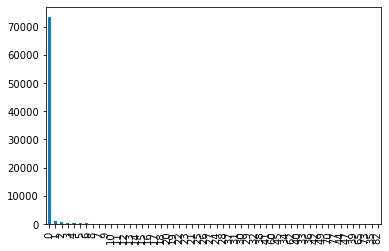

In [18]:
# plot UniProt_mutagens_count with zeros
human_proteome['UniProt_mutagens_count'].value_counts().plot.bar()

<AxesSubplot:>

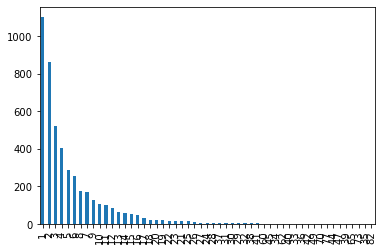

In [19]:
# plot UniProt_mutagens_count without zeros
human_proteome['UniProt_mutagens_count'].value_counts()[1:].plot.bar()

In [20]:
# extract Natural variant residues

def find_number_following_substring(text, substr="VARIANT "):
    numberlist = re.findall(r'%s(\d+)' % substr, text)
    if len(numberlist) >0:
        return list(dict.fromkeys(map(int, numberlist))) # convert to int, remove duplicates by keeping order using dict.fromkeys
        #return str(list(set(map(int, numberlist))))
    else:
        return np.nan

human_proteome['UniProt_variant_residues'] = human_proteome['Natural variant'].apply(find_number_following_substring)
human_proteome['UniProt_variant_residues']


0        [38, 55, 119, 199, 264, 305, 322, 336, 344, 35...
1             [52, 100, 132, 146, 169, 291, 364, 398, 421]
2                        [145, 220, 687, 1089, 1106, 1110]
3                       [12, 153, 195, 309, 453, 624, 758]
4                                                      NaN
                               ...                        
78115                                                  NaN
78116                                                  NaN
78117                                                  NaN
78118                                                  NaN
78119                                                  NaN
Name: UniProt_variant_residues, Length: 78120, dtype: object

In [21]:
# # of targets with Natural variants
len(human_proteome.loc[human_proteome['Natural variant'].str.len() != 0])

13027

In [22]:
# # of targets with Natural variants (with standard annotation, so that UniProt_variant_residues can be extracted)
len(human_proteome.loc[human_proteome['UniProt_variant_residues'].notna()])

13013

In [23]:
human_proteome.loc[human_proteome['Entry name'] == 'BRAF_HUMAN'] #P15056

,accession,Entry name,Protein names,Gene names,Alternative products (isoforms),Natural variant,Mutagenesis,UniProt_isoforms_count,UniProt_variants_count,UniProt_mutagens_count,UniProt_variant_residues
9094,P15056,BRAF_HUMAN,Serine/threonine-protein kinase B-raf (EC 2.7....,BRAF BRAF1 RAFB1,,"VARIANT 241; /note=""T -> M (in NS7; dbSNP:rs3...","MUTAGEN 53; /note=""M->D: Reduces interaction ...",0,47,7,"[241, 244, 245, 246, 257, 262, 275, 301, 462, ..."


In [24]:
# variant annotations that cannot be processed wich the RegEx, as they include the accession in the variant annotation
# PIN4 Q9Y237
human_proteome.loc[human_proteome['accession'] == 'Q9Y237']
# HSP90AA1 P07900
human_proteome.loc[human_proteome['accession'] == 'P07900']

,accession,Entry name,Protein names,Gene names,Alternative products (isoforms),Natural variant,Mutagenesis,UniProt_isoforms_count,UniProt_variants_count,UniProt_mutagens_count,UniProt_variant_residues
16279,P07900,HS90A_HUMAN,Heat shock protein HSP 90-alpha (EC 3.6.4.10) ...,HSP90AA1 HSP90A HSPC1 HSPCA,,"VARIANT P07900-2:71; /note=""M -> L (in dbSNP:...","MUTAGEN 47; /note=""E->A: Strong ATP-binding. ...",0,1,11,NaN


#### Extracting variant amino acid changes for all variants

In [25]:
def find_UniProt_variant_changes(text):
    note = re.findall(r'[A-Z] -> [A-Z]', text)
    if len(note) >0:
        return note #str(','.join(note))
    else: return []

human_proteome['UniProt_variant_changes'] = human_proteome['Natural variant'].apply(find_UniProt_variant_changes)
human_proteome['UniProt_variant_changes'][3]

['A -> S',
 'A -> T',
 'D -> A',
 'R -> H',
 'L -> M',
 'R -> C',
 'A -> T',
 'A -> E',
 'A -> K',
 'A -> S',
 'A -> T']

In [26]:
human_proteome[human_proteome['Natural variant'].str.contains("Missing")]

,accession,Entry name,Protein names,Gene names,Alternative products (isoforms),Natural variant,Mutagenesis,UniProt_isoforms_count,UniProt_variants_count,UniProt_mutagens_count,UniProt_variant_residues,UniProt_variant_changes
6,O15553,MEFV_HUMAN,Pyrin (Marenostrin),MEFV MEF TRIM20,,"VARIANT 33; /note=""V -> L (in dbSNP:rs1146601...","MUTAGEN 16; /note=""L->P: Does not form MEFV- ...",0,63,10,"[33, 42, 108, 110, 148, 163, 167, 177, 196, 20...","[V -> L, R -> W, S -> R, L -> P, E -> Q, E -> ..."
42,Q9H2M9,RBGPR_HUMAN,Rab3 GTPase-activating protein non-catalytic s...,RAB3GAP2 KIAA0839,,"VARIANT 167..169; /note=""Missing (in WARBM2)""...",,0,4,0,"[167, 863, 1052, 1092]","[T -> A, G -> C, S -> T]"
43,O43502,RA51C_HUMAN,DNA repair protein RAD51 homolog 3 (R51H3) (RA...,RAD51C RAD51L2,,"VARIANT 3; /note=""G -> R (in dbSNP:rs37640318...","MUTAGEN 131; /note=""K->A: Significant loss of...",0,20,2,"[3, 52, 103, 114, 125, 126, 138, 144, 159, 162...","[G -> R, I -> L, G -> V, G -> V, A -> T, L -> ..."
63,P35498,SCN1A_HUMAN,Sodium channel protein type 1 subunit alpha (S...,SCN1A NAC1 SCN1,,"VARIANT 17; /note=""Missing (in DRVT)""; /evid...",,0,434,0,"[17, 27, 45, 58, 61, 63, 68, 74, 78, 79, 84, 9...","[R -> T, D -> N, G -> V, L -> F, F -> L, I -> ..."
115,Q96RD7,PANX1_HUMAN,Pannexin-1,PANX1 MRS1 UNQ2529/PRO6028,,"VARIANT 5; /note=""Q -> H (in dbSNP:rs1138800)...","MUTAGEN 255; /note=""N->Q: Impaired glycosylat...",0,7,3,"[5, 21, 217, 272, 346, 347, 392]","[Q -> H, R -> H, I -> V, K -> E, C -> S]"
...,...,...,...,...,...,...,...,...,...,...,...,...
20271,P29400,CO4A5_HUMAN,Collagen alpha-5(IV) chain,COL4A5,,"VARIANT 54; /note=""G -> D (in ATS1; adult typ...",,0,162,0,"[54, 114, 123, 129, 174, 177, 192, 204, 216, 2...","[G -> D, G -> S, G -> E, G -> E, G -> V, G -> ..."
20289,O00423,EMAL1_HUMAN,Echinoderm microtubule-associated protein-like...,EML1 EMAP1 EMAPL EMAPL1,,"VARIANT 225; /note=""W -> R (in BH; dbSNP:rs88...","MUTAGEN 59..61; /note=""LAD->AAA: No effect on...",0,6,8,"[225, 243, 377, 523, 552, 556]","[W -> R, T -> A, A -> V, H -> N, S -> P]"
20336,P52565,GDIR1_HUMAN,Rho GDP-dissociation inhibitor 1 (Rho GDI 1) (...,ARHGDIA GDIA1,,"VARIANT 185; /note=""Missing (in NPHS8; produc...","MUTAGEN 45; /note=""D->A: Loss of RHOA interac...",0,1,4,[185],[]
20352,P38405,GNAL_HUMAN,Guanine nucleotide-binding protein G(olf) subu...,GNAL,,"VARIANT 16; /note=""V -> F (in dbSNP:rs1039372...",,0,4,0,"[16, 102, 137, 155]","[V -> F, V -> M, E -> K]"


In [27]:
# extracting single residue changes

def find_variant_single_change(text, substr="VARIANT (\d+);  /note="):
    note = re.findall(r'%s\"[A-Z] -> [A-Z]' % substr, text)
    if len(note) >0:
        return [int(x) for x in note if x] # convert strings to int and remove empty strings (if there)
    else: return []

human_proteome['UniProt_variant_single_change_residues'] = human_proteome['Natural variant'].apply(find_variant_single_change)
human_proteome[human_proteome.accession == 'Q9UID3']['UniProt_variant_single_change_residues']

4808    [490]
Name: UniProt_variant_single_change_residues, dtype: object

In [28]:
# extracting single residue deletions

def find_variant_del_single(text, substr="VARIANT (\d+);  /note="):
    note = re.findall(r'%s\"Missing' % substr, text)
    if len(note) >0:
        return [int(x) for x in note if x] # convert strings to int and remove empty strings (if there)
    else: return []

human_proteome['UniProt_variant_del_single_residues'] = human_proteome['Natural variant'].apply(find_variant_del_single)
human_proteome[human_proteome.accession == 'Q9UID3']['UniProt_variant_del_single_residues']

4808    [474]
Name: UniProt_variant_del_single_residues, dtype: object

In [29]:
# extracting deletions spanning several residues

def find_variant_del_stretches(text, substr="VARIANT (\d+\.{2}\d+);  /note="):
    note = re.findall(r'%s\"Missing' % substr, text)
    if len(note) >0:
        return note 
    else: return []

human_proteome['UniProt_variant_del_stretches'] = human_proteome['Natural variant'].apply(find_variant_del_stretches)
human_proteome[human_proteome.accession == 'P04280']['UniProt_variant_del_stretches']

2973    [93..153, 106..319, 106..299, 134..255]
Name: UniProt_variant_del_stretches, dtype: object

In [30]:
def expand_stretches(stretches):
    #stretches = [stretch.replace('..',',') for stretch in stretches]
    stretches = [stretch.split('..') for stretch in stretches]
    #stretches = [[int(r) for r in stretch] for stretch in stretches]
    stretches = [tuple(int(r) for r in stretch) for stretch in stretches]
    #print(stretches)
    if len(stretches) >0:
        #[print([i for i in range(start,end+1)]) for start,end in stretches]
        expanded = [[i for i in range(start,end+1)] for start,end in stretches]
        return expanded 
    else: return []

human_proteome['UniProt_variant_del_stretches_residues'] = human_proteome['UniProt_variant_del_stretches'].apply(expand_stretches)
human_proteome[human_proteome.accession == 'P04280']['UniProt_variant_del_stretches_residues']

2973    [[93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 1...
Name: UniProt_variant_del_stretches_residues, dtype: object

In [31]:
# targets with single missing residue variants
len(human_proteome.loc[human_proteome['UniProt_variant_del_single_residues'].str.len()>0])

527

In [32]:
# targets with missing residue variants spanning stretches of several residues
len(human_proteome.loc[human_proteome['UniProt_variant_del_stretches'].str.len()>0])

931

In [33]:
# targets with both, single missing residue variants and missing variants spanning stretches of several residues
len(human_proteome.loc[(human_proteome['UniProt_variant_del_single_residues'].str.len()>0) & (human_proteome['UniProt_variant_del_stretches'].str.len()>0)])

203

In [34]:
# targets with missing residue variants
len(human_proteome.loc[(human_proteome['UniProt_variant_del_single_residues'].str.len()>0) | (human_proteome['UniProt_variant_del_stretches'].str.len()>0)])

1255

In [35]:
# combining the missing residue stretches and single missing residues and flatten resulting nested list, then keep only unique and sort residues
human_proteome['UniProt_variant_del_all_residues'] = human_proteome['UniProt_variant_del_stretches_residues'] + human_proteome['UniProt_variant_del_single_residues']
from pandas.core.common import flatten
human_proteome['UniProt_variant_del_all_residues'] = human_proteome['UniProt_variant_del_all_residues'].apply(lambda l: list(sorted(dict.fromkeys(list(flatten(l))))))
human_proteome[human_proteome.accession == 'Q9UID3']['UniProt_variant_del_all_residues']

4808    [474]
Name: UniProt_variant_del_all_residues, dtype: object

In [36]:
# targets with missing residue variants
len(human_proteome.loc[human_proteome['UniProt_variant_del_all_residues'].str.len()>0])

1255

#### Extracting variant notes (containing information on disease and dbSNP-IDs)

In [37]:
def find_variant_notes(text, substr="VARIANT (\d+\.{0,2}\d*);  /note="):
    note = re.findall(r'%s\"(.*?)\"' % substr, text)
    if len(note) >0:
        return note #str(','.join(note))
    else: return []

human_proteome['UniProt_variant_notes'] = human_proteome['Natural variant'].apply(find_variant_notes)
human_proteome['UniProt_variant_notes'][3]
human_proteome[human_proteome.accession == 'P00533']['UniProt_variant_notes'] #EGFR

14275    [(30..297, Missing (variant EGFR vIII; found i...
Name: UniProt_variant_notes, dtype: object

In [38]:
# find variant notes with single amino acid changes
#human_proteome['variant_notes_single_aa'] = human_proteome['UniProt_variant_notes'].map(lambda l: [t for t in l if 
#                                                                                         ('...' not in ', '.join(t)) ])
#human_proteome[human_proteome.accession == 'P00533']['variant_notes_single_aa'] #EGFR 

In [39]:
# cleaning column data: removing '"' from tuples in list --> not needed any more
#human_proteome['UniProt_variant_notes'] = human_proteome['UniProt_variant_notes'].map(lambda l: [tuple([j for j in t if j != '']) for t in l])
#human_proteome['UniProt_variant_notes'][3]

In [40]:
# find UniProt_disease_variant_notes: keeping entries containing '(in ' and removing '(in dbSNP' containing tuples from list
human_proteome['UniProt_disease_variant_notes'] = human_proteome['UniProt_variant_notes'].map(lambda l: [', '.join(t) for t in l if 
                                                                                         ('(in ' in ', '.join(t)) and
                                                                                         ('(in dbSNP' not in ', '.join(t)) and 
                                                                                         ('(in a ' not in ', '.join(t)) and 
                                                                                         ('(in an ' not in ', '.join(t)) and 
                                                                                         ('(in allele' not in ', '.join(t)) and 
                                                                                         ('(in allotype ' not in ', '.join(t)) and 
                                                                                         ('(in variant ' not in ', '.join(t)) and 
                                                                                         ('(in RNA edited version' not in ', '.join(t)) and 
                                                                                         ('(in IMGT allele' not in ', '.join(t)) ])
human_proteome[human_proteome.accession == 'P00533']['UniProt_disease_variant_notes'] #EGFR 

14275    [428, G -> D (in NISBD2; loss of function; the...
Name: UniProt_disease_variant_notes, dtype: object

#### Extracting variant amino acid changes for disease variants

In [41]:
human_proteome['UniProt_disease_variant_changes'] = human_proteome['UniProt_disease_variant_notes'].apply(lambda l: ' | '.join(l)).apply(find_UniProt_variant_changes)
human_proteome[human_proteome.accession == 'P00533']['UniProt_disease_variant_changes'] #EGFR 

14275    [G -> D]
Name: UniProt_disease_variant_changes, dtype: object

In [42]:
#human_proteome['UniProt_disease_variant_notes'][3][0], human_proteome['UniProt_disease_variant_notes'][3][1]

#### Extracting variant amino acid number for disease variants

In [43]:
def find_variant_number(text):
    note = re.findall(r'([0-9]*), ', text)
    if len(note) >0:
        #stringlist = [x.replace(', ', '') for x in note]
        #return [int(x) for x in stringlist if x] # remove empty strings
        return [int(x) for x in note if x] # remove empty strings
    else: return []

human_proteome['UniProt_disease_variant_residues'] = human_proteome['UniProt_disease_variant_notes'].apply(lambda l: ' | '.join(l)).apply(find_variant_number)
human_proteome[human_proteome.accession == 'P00533']['UniProt_disease_variant_residues'] #EGFR 

14275    [428]
Name: UniProt_disease_variant_residues, dtype: object

In [44]:
# extracting single residue changes

def find_disease_variant_single_change(text, substr="(\d+),"):
    note = re.findall(r'%s [A-Z] -> [A-Z]' % substr, text)
    if len(note) >0:
        return [int(x) for x in note if x] # convert strings to int and remove empty strings (if there)
    else: return []

human_proteome['UniProt_disease_variant_single_change_residues'] = human_proteome['UniProt_disease_variant_notes'].apply(lambda l: ' | '.join(l)).apply(find_disease_variant_single_change)
human_proteome[human_proteome.accession == 'P00533']['UniProt_disease_variant_single_change_residues'] #EGFR 

14275    [428]
Name: UniProt_disease_variant_single_change_residues, dtype: object

#### Extracting deletion (disease) variant notes

In [45]:
def find_variant_del_notes(text, substr="VARIANT (\d+\.{0,2}\d*);  /note="):
    note = re.findall(r'%s\"(Missing.*?)\"' % substr, text)
    if len(note) >0:
        return note #str(','.join(note))
    else: return []

human_proteome['UniProt_variant_del_notes'] = human_proteome['Natural variant'].apply(find_variant_del_notes)
human_proteome['UniProt_variant_del_notes'][3]
human_proteome[human_proteome.accession == 'P00533']['UniProt_variant_del_notes'] #EGFR

14275    [(30..297, Missing (variant EGFR vIII; found i...
Name: UniProt_variant_del_notes, dtype: object

In [46]:
# find disease_variant_del_notes: keeping entries containing '(in ' and removing '(in dbSNP' containing tuples from list
human_proteome['UniProt_disease_variant_del_notes'] = human_proteome['UniProt_variant_del_notes'].map(lambda l: [', '.join(t) for t in l if 
                                                                                         ('(in ' in ', '.join(t)) and
                                                                                         ('(in dbSNP' not in ', '.join(t)) and 
                                                                                         ('(in a ' not in ', '.join(t)) and 
                                                                                         ('(in an ' not in ', '.join(t)) and 
                                                                                         ('(in allele' not in ', '.join(t)) and 
                                                                                         ('(in allotype ' not in ', '.join(t)) and 
                                                                                         ('(in variant ' not in ', '.join(t)) and 
                                                                                         ('(in RNA edited version' not in ', '.join(t)) and 
                                                                                         ('(in IMGT allele' not in ', '.join(t)) ])
human_proteome[human_proteome.accession == 'P00533']['UniProt_disease_variant_del_notes'] #EGFR 

14275    []
Name: UniProt_disease_variant_del_notes, dtype: object

In [47]:
# # of deletion variant targets
len(human_proteome.loc[human_proteome.UniProt_variant_del_notes.str.len() != 0])

1255

In [48]:
# # of deletion disease variant targets
len(human_proteome.loc[human_proteome.UniProt_disease_variant_del_notes.str.len() != 0])

1049

In [49]:
# # of disease variant targets
len(human_proteome.loc[human_proteome.UniProt_disease_variant_notes.str.len() != 0])

3468

In [50]:
human_proteome.loc[human_proteome.UniProt_disease_variant_notes.str.len() != 0]

,accession,Entry name,Protein names,Gene names,Alternative products (isoforms),Natural variant,Mutagenesis,UniProt_isoforms_count,UniProt_variants_count,UniProt_mutagens_count,...,UniProt_variant_del_stretches,UniProt_variant_del_stretches_residues,UniProt_variant_del_all_residues,UniProt_variant_notes,UniProt_disease_variant_notes,UniProt_disease_variant_changes,UniProt_disease_variant_residues,UniProt_disease_variant_single_change_residues,UniProt_variant_del_notes,UniProt_disease_variant_del_notes
0,Q00266,METK1_HUMAN,S-adenosylmethionine synthase isoform type-1 (...,MAT1A AMS1 MATA1,,"VARIANT 38; /note=""S -> N (in MATD; abolishes...",,0,13,0,...,[],[],[],"[(38, S -> N (in MATD; abolishes enzyme activi...","[38, S -> N (in MATD; abolishes enzyme activit...","[S -> N, A -> D, R -> C, R -> C, R -> H, L -> ...","[38, 55, 199, 264, 264, 305, 322, 336, 344, 35...","[38, 55, 199, 264, 264, 305, 322, 336, 344, 35...",[],[]
5,Q8N635,MEIOB_HUMAN,Meiosis-specific with OB domain-containing pro...,MEIOB C16orf73,,"VARIANT 18; /note=""T -> P (in dbSNP:rs1742446...",,0,4,0,...,[],[],[],"[(18, T -> P (in dbSNP:rs1742446)), (64, N -> ...","[64, N -> I (in SPGF22; dbSNP:rs1555472691)]",[N -> I],[64],[64],[],[]
6,O15553,MEFV_HUMAN,Pyrin (Marenostrin),MEFV MEF TRIM20,,"VARIANT 33; /note=""V -> L (in dbSNP:rs1146601...","MUTAGEN 16; /note=""L->P: Does not form MEFV- ...",0,63,10,...,[],[],"[692, 694]","[(33, V -> L (in dbSNP:rs11466016)), (42, R ->...","[42, R -> W (in arFMF; dbSNP:rs61754767), 108,...","[R -> W, S -> R, L -> P, E -> Q, E -> V, E -> ...","[42, 108, 110, 148, 148, 163, 167, 177, 196, 2...","[42, 108, 110, 148, 148, 163, 167, 177, 196, 2...","[(692, Missing (in arFMF; dbSNP:rs104895093)),...","[692, Missing (in arFMF; dbSNP:rs104895093), 6..."
12,Q13724,MOGS_HUMAN,Mannosyl-oligosaccharide glucosidase (EC 3.2.1...,MOGS GCS1,,"VARIANT 222; /note=""G -> R (in dbSNP:rs321367...",,0,8,0,...,[],[],[],"[(222, G -> R (in dbSNP:rs3213671)), (236, E -...","[486, R -> T (in CDGIIb; loss of activity; dbS...","[R -> T, F -> L]","[486, 652]","[486, 652]",[],[]
13,P45452,MMP13_HUMAN,Collagenase 3 (EC 3.4.24.-) (Matrix metallopro...,MMP13,,"VARIANT 2; /note=""H -> L (in dbSNP:rs554797)""...","MUTAGEN 223; /note=""E->A: Abolishes enzyme ac...",0,7,1,...,[],[],[],"[(2, H -> L (in dbSNP:rs554797)), (74, F -> S ...","[74, F -> S (in MANDP1; dbSNP:rs121909498), 75...","[F -> S, F -> S, M -> T, W -> G, H -> N]","[74, 75, 91, 207, 232]","[74, 75, 91, 207, 232]",[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20355,P98172,EFNB1_HUMAN,Ephrin-B1 (EFL-3) (ELK ligand) (ELK-L) (EPH-re...,EFNB1 EFL3 EPLG2 LERK2,,"VARIANT 27; /note=""P -> R (in CFNS)""; /evide...","MUTAGEN 260..273; /note=""Missing: The intrace...",0,22,2,...,[],[],[],"[(27, P -> R (in CFNS)), (54, P -> L (in CFNS;...","[27, P -> R (in CFNS), 54, P -> L (in CFNS; db...","[P -> R, P -> L, I -> T, L -> S, T -> I, Q -> ...","[27, 54, 62, 98, 111, 115, 119, 119, 119, 137,...","[27, 54, 62, 98, 111, 115, 119, 119, 119, 137,...",[],[]
20358,P09471,GNAO_HUMAN,Guanine nucleotide-binding protein G(o) subuni...,GNAO1,,"VARIANT 40; /note=""G -> R (in DEE17 and NEDIM...",,0,14,0,...,[191..197],"[[191, 192, 193, 194, 195, 196, 197]]","[191, 192, 193, 194, 195, 196, 197]","[(40, G -> R (in DEE17 and NEDIM; dbSNP:rs8860...","[40, G -> R (in DEE17 and NEDIM; dbSNP:rs88604...","[G -> R, S -> G, I -> T, D -> G, G -> R, R -> ...","[40, 47, 56, 174, 197, 203, 209, 209, 209, 209...","[40, 47, 56, 174, 203, 209, 209, 209, 209, 227...","[(191..197, Missing (in DEE17; the mutant prot...","[191..197, Missing (in DEE17; the mutant prote..."
20360,Q96IJ6,GMPPA_HUMAN,Mannose-1-phosphate guanyltransferase alpha (G...,GMPPA,,"VARIANT 21; /note=""S -> F (in dbSNP:rs3421860...",,0,7,0,...,[],[],[],"[(21, S -> F (in dbSNP:rs34218609)), (156, V -...","[182, G -> D (in AAMR; drastically reduced pro...","[G -> D, T -> M, T -> P, R -> P, N -> T]","[182, 334, 334, 390, 401]","[182, 3

In [51]:
all_UniProt_variant_changes = human_proteome.loc[human_proteome.UniProt_variant_notes.str.len() != 0].UniProt_variant_changes.tolist()
from pandas.core.common import flatten
all_UniProt_variant_changes = list(flatten(all_UniProt_variant_changes))
pd.Series(all_UniProt_variant_changes).value_counts()[:10]

R -> Q    2447
R -> H    2163
R -> C    2078
A -> T    2034
G -> R    1959
P -> L    1934
R -> W    1841
E -> K    1832
A -> V    1800
L -> P    1799
dtype: int64

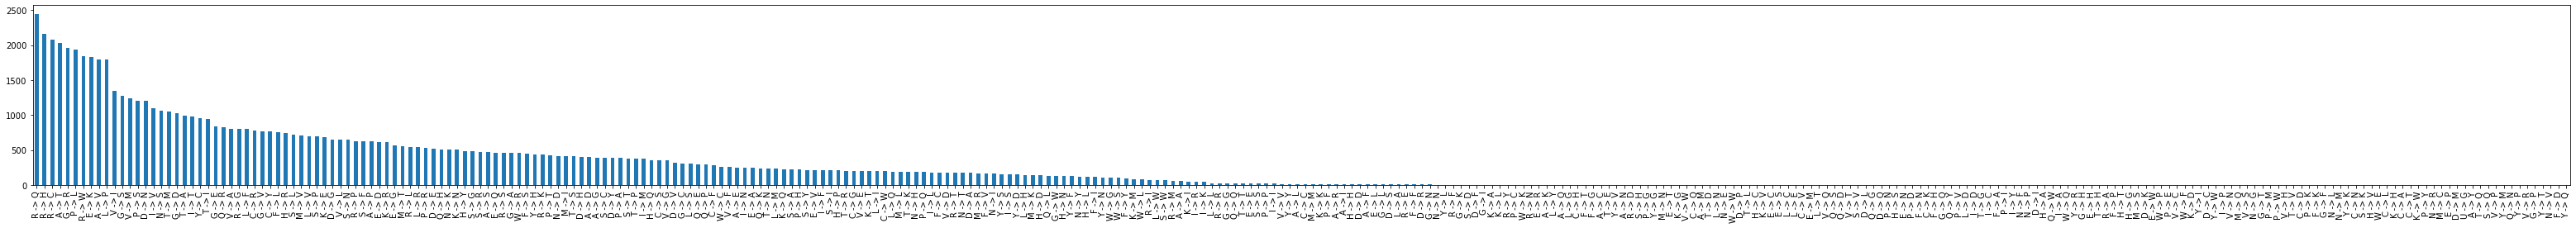

In [52]:
mpl.rcParams['figure.figsize'] = [55, 4]
pd.Series(all_UniProt_variant_changes).value_counts().plot.bar()
mpl.rcParams['figure.figsize'] = [8, 4]

In [53]:
all_UniProt_disease_changes = human_proteome.loc[human_proteome.UniProt_disease_variant_notes.str.len() != 0].UniProt_disease_variant_changes.tolist()
from pandas.core.common import flatten
all_UniProt_disease_changes = list(flatten(all_UniProt_disease_changes))
pd.Series(all_UniProt_disease_changes).value_counts()[:10]

G -> R    1312
L -> P    1304
R -> C    1208
R -> W    1124
R -> Q    1107
R -> H     984
E -> K     955
P -> L     857
G -> D     675
A -> T     640
dtype: int64

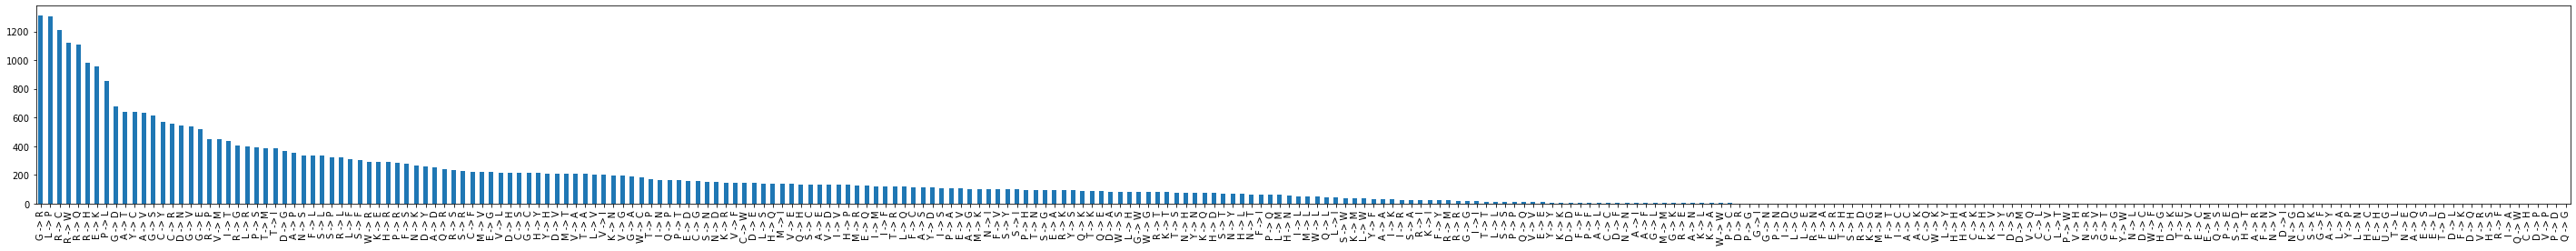

In [54]:
mpl.rcParams['figure.figsize'] = [50, 4]
pd.Series(all_UniProt_disease_changes).value_counts().plot.bar()
mpl.rcParams['figure.figsize'] = [8, 4]

Comparing amino acid changes: all changes, disease related changes and other (non-disease related) changes

In [55]:
vdf1 = pd.DataFrame(pd.Series(all_UniProt_variant_changes).value_counts(), columns=['all_variant_count'])
vdf2 = pd.DataFrame(pd.Series(all_UniProt_disease_changes).value_counts(), columns=['disease_variant_count'])
vdf = vdf1.merge(vdf2, how='left', left_index=True, right_index=True)
vdf = vdf.fillna(0).astype('int', copy=False)
vdf['other_variant_count'] = vdf['all_variant_count'] - vdf['disease_variant_count']
vdf['diff_disease_other_variant_count'] = vdf['disease_variant_count'] - vdf['other_variant_count']
#vdf['div_disease_other_variant_count'] = vdf['disease_variant_count'] / vdf['other_variant_count']
#vdf['div_disease_all_variant_count'] = vdf['disease_variant_count'] / vdf['all_variant_count']
#vdf['div_diff_disease_other_all_variant_count'] = vdf['diff_disease_other_variant_count'] / vdf['all_variant_count']

vdf_sorted = vdf.sort_values(by=['diff_disease_other_variant_count'], ascending=False)
#vdf_sorted = vdf.sort_values(by=['div_disease_other_variant_count'], ascending=False)
vdf_sorted

,all_variant_count,disease_variant_count,other_variant_count,diff_disease_other_variant_count
L -> P,1799,1304,495,809
G -> R,1959,1312,647,665
R -> W,1841,1124,717,407
C -> Y,769,568,201,367
R -> C,2078,1208,870,338
...,...,...,...,...
A -> V,1800,631,1169,-538
T -> A,995,207,788,-581
A -> T,2034,640,1394,-754
I -> V,1098,130,968,-838


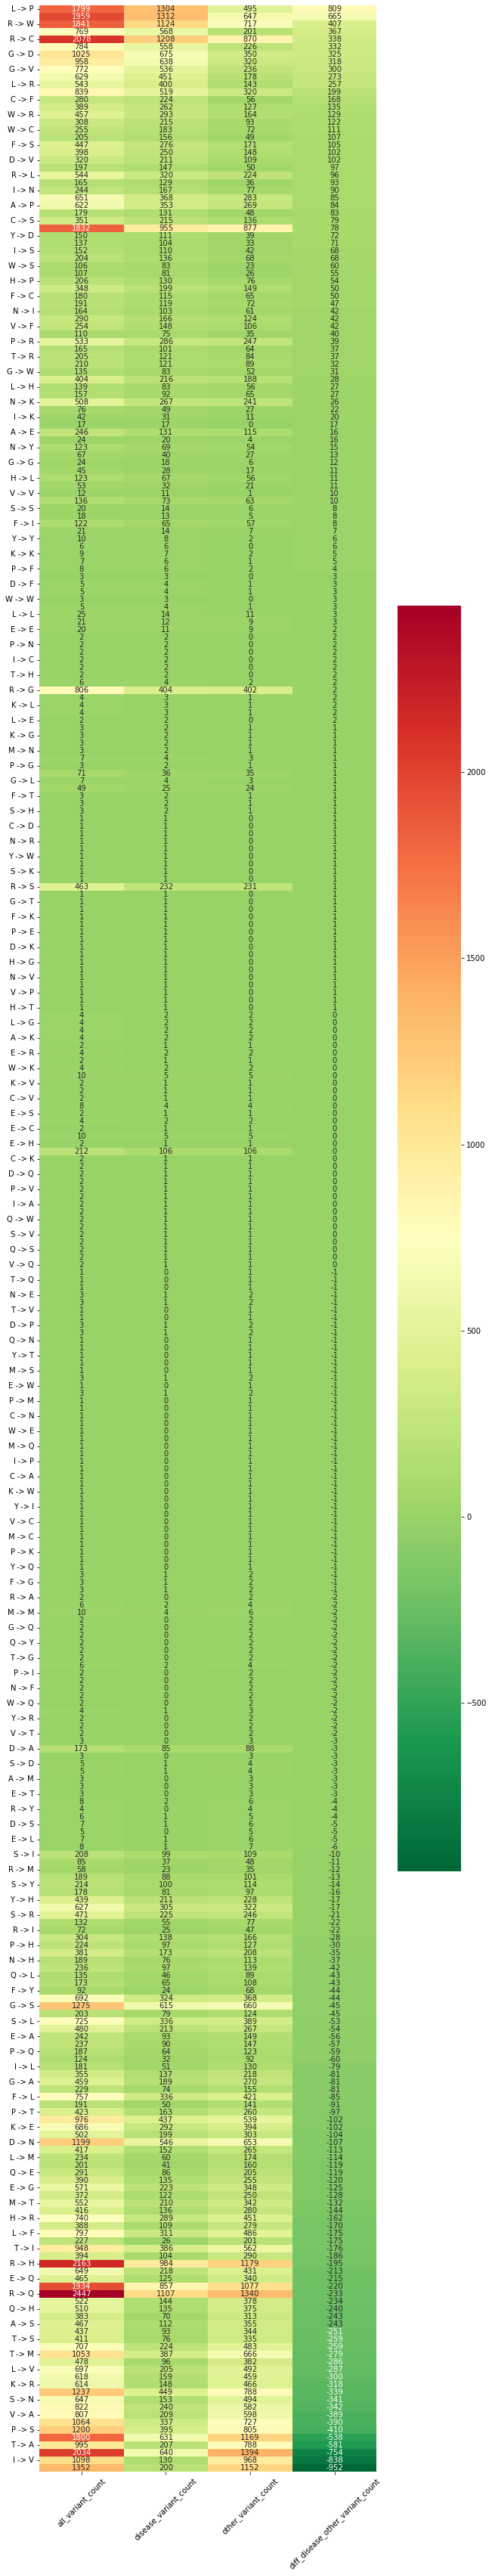

In [56]:
plt.rcParams['figure.figsize'] = [10, 60]
sns.heatmap(vdf_sorted, annot=True, cmap='RdYlGn_r', fmt='d')#.set_xticklabels(rotation=45)
plt.xticks(rotation=45)
plt.rcParams['figure.figsize'] = [8, 4]

/Users/melanie/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  after removing the cwd from sys.path.


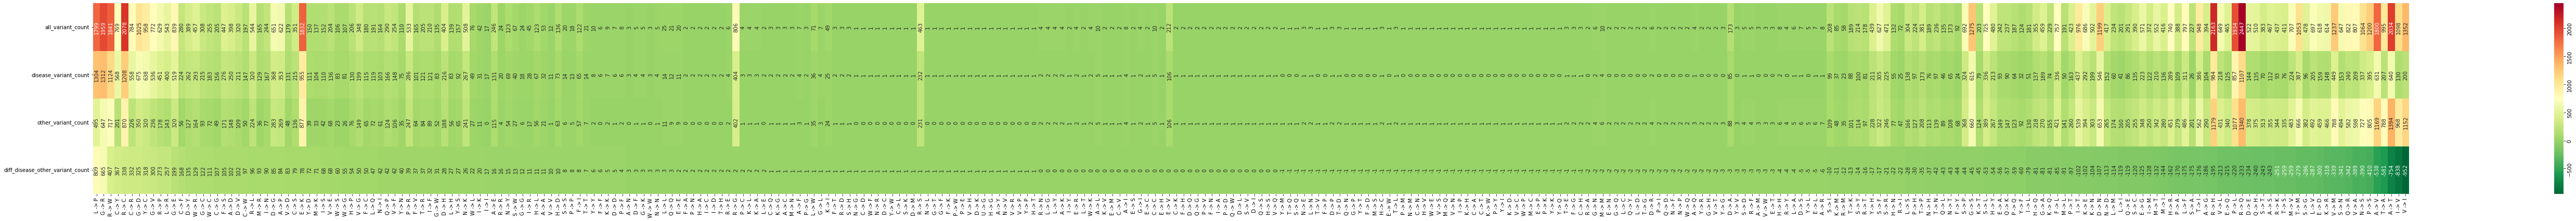

In [57]:
fig, ax = plt.subplots(figsize=(80,6))
heatmap = sns.heatmap(vdf_sorted.T, cbar=True, ax=ax, annot=True, cmap='RdYlGn_r', fmt='d', annot_kws={'rotation':90})
cbar = heatmap.collections[0].colorbar
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), rotation=90, va='center')
plt.yticks(rotation=0)
plt.tight_layout()

In [58]:
vdf['other_variant_count'].max(), vdf['other_variant_count'].mean()

(1394, 131.91104294478527)

In [59]:
vdf['disease_variant_count'].max(), vdf['disease_variant_count'].mean()

(1312, 111.73312883435582)

In [60]:
vdf['all_variant_count'].max(), vdf['all_variant_count'].mean()

(2447, 243.64417177914112)

## 2. Disease variant data from UniProt (accessed through UniProt keyword)

In [61]:
# Keyword - Disease mutation (KW-0225)
mut_url = 'https://www.uniprot.org/uniprot/?query=keyword%3A%22Disease+mutation+%5BKW-0225%5D%22+organism%3A%22Homo+sapiens+%28Human%29+%5B9606%5D%22&format=tab&columns=id,feature(NATURAL%20VARIANT)' 

Uniprot_disease_variant = make_request(mut_url, data=None)
Uniprot_disease_variant = [x.split('\t') for x in Uniprot_disease_variant.split('\n')]
disease_variant = pd.DataFrame(Uniprot_disease_variant[1:], columns=Uniprot_disease_variant[0])
disease_variant.rename(columns={'Entry': 'accession'}, inplace=True)
# only keep row when 'accession' is available (discard NAN row)
disease_variant = disease_variant.loc[disease_variant['accession']!=''] #.notna()
disease_variant

,accession,Natural variant
0,Q00266,"VARIANT 38; /note=""S -> N (in MATD; abolishes..."
1,O15553,"VARIANT 33; /note=""V -> L (in dbSNP:rs1146601..."
2,Q13724,"VARIANT 222; /note=""G -> R (in dbSNP:rs321367..."
3,P45452,"VARIANT 2; /note=""H -> L (in dbSNP:rs554797)""..."
4,Q9ULW8,"VARIANT 52; /note=""I -> V (in dbSNP:rs3750300..."
...,...,...
3345,P98172,"VARIANT 27; /note=""P -> R (in CFNS)""; /evide..."
3346,P09471,"VARIANT 40; /note=""G -> R (in DEE17 and NEDIM..."
3347,Q96IJ6,"VARIANT 21; /note=""S -> F (in dbSNP:rs3421860..."
3348,Q9Y5P6,"VARIANT 22; /note=""P -> S (in MDDGC14; causes..."


In [62]:
disease_variant_unique = disease_variant.drop_duplicates(subset='accession')
len(disease_variant_unique)

3350

In [63]:
disease_variant['Natural variant'].loc[1]

'VARIANT 33;  /note="V -> L (in dbSNP:rs11466016)";  /id="VAR_048398"; VARIANT 42;  /note="R -> W (in arFMF; dbSNP:rs61754767)";  /id="VAR_028326"; VARIANT 108;  /note="S -> R (in arFMF; dbSNP:rs104895103)";  /evidence="ECO:0000269|PubMed:16378925";  /id="VAR_028327"; VARIANT 110;  /note="L -> P (in arFMF; dbSNP:rs11466018)";  /evidence="ECO:0000269|PubMed:10854105, ECO:0000269|PubMed:24929125";  /id="VAR_016824"; VARIANT 148;  /note="E -> Q (in arFMF and adFMF; likely benign variant; associated with S-369 and Q-408 in cis; associated with I-694 in some patients; dbSNP:rs3743930)";  /evidence="ECO:0000269|PubMed:10364520, ECO:0000269|PubMed:10612841, ECO:0000269|PubMed:10737995, ECO:0000269|PubMed:10787449, ECO:0000269|PubMed:10854105, ECO:0000269|PubMed:16378925, ECO:0000269|PubMed:24929125";  /id="VAR_009051"; VARIANT 148;  /note="E -> V (in arFMF; dbSNP:rs104895076)";  /evidence="ECO:0000269|PubMed:16378925";  /id="VAR_028328"; VARIANT 163;  /note="E -> A (in arFMF; dbSNP:rs10489510

In [64]:
disease_variant['UniProt_disease_variant_label'] = 'Yes'

## 3. Variation data from ChEMBL (assay data)

In [65]:
#chembl_url = "http://wwwdev.ebi.ac.uk/chembl/api/data/assay.json?variant_sequence__isnull=false"
chembl_url = "https://www.ebi.ac.uk/chembl/api/data/assay.json?variant_sequence__tax_id=9606&limit=1000"

url = urllib2.urlopen(chembl_url)
response = url.read()
try: response = json.loads(response.decode())
except UnicodeDecodeError: response = json.loads(response)
    
#next_page = pd.json_normalize(response, record_path=['page_meta', 'next'])
results = pd.json_normalize(response, record_path='assays')

while response['page_meta']['next'] != None:
    next_url = "https://www.ebi.ac.uk" + response['page_meta']['next']
    print(next_url)
    response = urllib2.urlopen(next_url).read()
    try: response = json.loads(response.decode())
    except UnicodeDecodeError: response = json.loads(response)
    results = results.append(pd.json_normalize(response, record_path='assays'), ignore_index=True)
    
results

https://www.ebi.ac.uk/chembl/api/data/assay.json?limit=1000&offset=1000&variant_sequence__tax_id=9606
https://www.ebi.ac.uk/chembl/api/data/assay.json?limit=1000&offset=2000&variant_sequence__tax_id=9606
https://www.ebi.ac.uk/chembl/api/data/assay.json?limit=1000&offset=3000&variant_sequence__tax_id=9606
https://www.ebi.ac.uk/chembl/api/data/assay.json?limit=1000&offset=4000&variant_sequence__tax_id=9606
https://www.ebi.ac.uk/chembl/api/data/assay.json?limit=1000&offset=5000&variant_sequence__tax_id=9606
https://www.ebi.ac.uk/chembl/api/data/assay.json?limit=1000&offset=6000&variant_sequence__tax_id=9606
https://www.ebi.ac.uk/chembl/api/data/assay.json?limit=1000&offset=7000&variant_sequence__tax_id=9606


,assay_category,assay_cell_type,assay_chembl_id,assay_classifications,assay_organism,assay_parameters,assay_strain,assay_subcellular_fraction,assay_tax_id,assay_test_type,...,src_id,target_chembl_id,tissue_chembl_id,variant_sequence.accession,variant_sequence.isoform,variant_sequence.mutation,variant_sequence.organism,variant_sequence.sequence,variant_sequence.tax_id,variant_sequence.version
0,None,None,CHEMBL645814,[],None,[],None,None,NaN,None,...,1,CHEMBL2864,None,P16455,1.0,G160R,Homo sapiens,MDKDCEMKRTTLDSPLGKLELSGCEQGLHEIKLLGKGTSAADAVEV...,9606,1
1,None,None,CHEMBL645815,[],None,[],None,None,NaN,None,...,1,CHEMBL2864,None,P16455,NaN,P140K,Homo sapiens,MDKDCEMKRTTLDSPLGKLELSGCEQGLHEIKLLGKGTSAADAVEV...,9606,1
2,None,None,CHEMBL645817,[],None,[],None,None,NaN,None,...,1,CHEMBL2864,None,P16455,1.0,Y158H,Homo sapiens,MDKDCEMKRTTLDSPLGKLELSGCEQGLHEIKLLGKGTSAADAVEV...,9606,1
3,None,None,CHEMBL645818,[],None,[],None,None,NaN,None,...,1,CHEMBL2864,None,P16455,1.0,G160R,Homo sapiens,MDKDCEMKRTTLDSPLGKLELSGCEQGLHEIKLLGKGTSAADAVEV...,9606,1
4,None,None,CHEMBL645819,[],None,[],None,None,NaN,None,...,1,CHEMBL2864,None,P16455,NaN,P140K,Homo sapiens,MDKDCEMKRTTLDSPLGKLELSGCEQGLHEIKLLGKGTSAADAVEV...,9606,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7834,None,None,CHEMBL4630403,[],Homo sapiens,[],None,None,9606.0,None,...,1,CHEMBL1827,None,O76074,NaN,F787Y,Homo sapiens,MERAGPSFGQQRQQQQPQQQKQQQRDQDSVEAWLDDHWDFTFSYFV...,9606,2
7835,None,None,CHEMBL4630404,[],Homo sapiens,[],None,None,9606.0,None,...,1,CHEMBL1827,None,O76074,NaN,I824F,Homo sapiens,MERAGPSFGQQRQQQQPQQQKQQQRDQDSVEAWLDDHWDFTFSYFV...,9606,2
7836,None,None,CHEMBL4630405,[],Homo sapiens,[],None,None,9606.0,None,...,1,CHEMBL1827,None,O76074,NaN,A783V,Homo sapiens,MERAGPSFGQQRQQQQPQQQKQQQRDQDSVEAWLDDHWDFTFSYFV...,9606,2
7837,None,None,CHEMBL4630406,[],Homo sapiens,[],None,None,9606.0,None,...,1,CHEMBL1827,None,O76074,NaN,A783L,Homo sapiens,MERAGPSFGQQRQQQQPQQQKQQQRDQDSVEAWLDDHWDFTFSYFV...,9606,2


In [66]:
response['page_meta']

{'limit': 1000,
 'next': None,
 'offset': 7000,
 'previous': '/chembl/api/data/assay.json?limit=1000&offset=6000&variant_sequence__tax_id=9606',
 'total_count': 7839}

In [67]:
results['variant_sequence.mutation'][1].split(",")

['P140K']

In [68]:
results['ChEMBL_variant_mutation'] = results['variant_sequence.mutation'].map(lambda x: x.split(","))

In [69]:
results['ChEMBL_variant_residue'] = results['ChEMBL_variant_mutation'].map(lambda x: [y.strip().strip("abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ") for y in x])

In [70]:
results

,assay_category,assay_cell_type,assay_chembl_id,assay_classifications,assay_organism,assay_parameters,assay_strain,assay_subcellular_fraction,assay_tax_id,assay_test_type,...,tissue_chembl_id,variant_sequence.accession,variant_sequence.isoform,variant_sequence.mutation,variant_sequence.organism,variant_sequence.sequence,variant_sequence.tax_id,variant_sequence.version,ChEMBL_variant_mutation,ChEMBL_variant_residue
0,None,None,CHEMBL645814,[],None,[],None,None,NaN,None,...,None,P16455,1.0,G160R,Homo sapiens,MDKDCEMKRTTLDSPLGKLELSGCEQGLHEIKLLGKGTSAADAVEV...,9606,1,[G160R],[160]
1,None,None,CHEMBL645815,[],None,[],None,None,NaN,None,...,None,P16455,NaN,P140K,Homo sapiens,MDKDCEMKRTTLDSPLGKLELSGCEQGLHEIKLLGKGTSAADAVEV...,9606,1,[P140K],[140]
2,None,None,CHEMBL645817,[],None,[],None,None,NaN,None,...,None,P16455,1.0,Y158H,Homo sapiens,MDKDCEMKRTTLDSPLGKLELSGCEQGLHEIKLLGKGTSAADAVEV...,9606,1,[Y158H],[158]
3,None,None,CHEMBL645818,[],None,[],None,None,NaN,None,...,None,P16455,1.0,G160R,Homo sapiens,MDKDCEMKRTTLDSPLGKLELSGCEQGLHEIKLLGKGTSAADAVEV...,9606,1,[G160R],[160]
4,None,None,CHEMBL645819,[],None,[],None,None,NaN,None,...,None,P16455,NaN,P140K,Homo sapiens,MDKDCEMKRTTLDSPLGKLELSGCEQGLHEIKLLGKGTSAADAVEV...,9606,1,[P140K],[140]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7834,None,None,CHEMBL4630403,[],Homo sapiens,[],None,None,9606.0,None,...,None,O76074,NaN,F787Y,Homo sapiens,MERAGPSFGQQRQQQQPQQQKQQQRDQDSVEAWLDDHWDFTFSYFV...,9606,2,[F787Y],[787]
7835,None,None,CHEMBL4630404,[],Homo sapiens,[],None,None,9606.0,None,...,None,O76074,NaN,I824F,Homo sapiens,MERAGPSFGQQRQQQQPQQQKQQQRDQDSVEAWLDDHWDFTFSYFV...,9606,2,[I824F],[824]
7836,None,None,CHEMBL4630405,[],Homo sapiens,[],None,None,9606.0,None,...,None,O76074,NaN,A783V,Homo sapiens,MERAGPSFGQQRQQQQPQQQKQQQRDQDSVEAWLDDHWDFTFSYFV...,9606,2,[A783V],[783]
7837,None,None,CHEMBL4630406,[],Homo sapiens,[],None,None,9606.0,None,...,None,O76074,NaN,A783L,Homo sapiens,MERAGPSFGQQRQQQQPQQQKQQQRDQDSVEAWLDDHWDFTFSYFV...,9606,2,[A783L],[783]


In [71]:
chembl_data = results[['assay_chembl_id','variant_sequence.accession','ChEMBL_variant_mutation','ChEMBL_variant_residue']]
chembl_data

,assay_chembl_id,variant_sequence.accession,ChEMBL_variant_mutation,ChEMBL_variant_residue
0,CHEMBL645814,P16455,[G160R],[160]
1,CHEMBL645815,P16455,[P140K],[140]
2,CHEMBL645817,P16455,[Y158H],[158]
3,CHEMBL645818,P16455,[G160R],[160]
4,CHEMBL645819,P16455,[P140K],[140]
...,...,...,...,...
7834,CHEMBL4630403,O76074,[F787Y],[787]
7835,CHEMBL4630404,O76074,[I824F],[824]
7836,CHEMBL4630405,O76074,[A783V],[783]
7837,CHEMBL4630406,O76074,[A783L],[783]


In [72]:
# group by variant_sequence.accession
chembl_data_grouped = chembl_data.groupby('variant_sequence.accession', as_index=False
                                         ).agg({'assay_chembl_id': lambda x: ",".join(map(str, [i for i in x])).split(","), 
                                                'ChEMBL_variant_mutation': lambda x: ",".join(map(str, [i[0] for i in x])).split(","),
                                                'ChEMBL_variant_residue': lambda x: ",".join(map(str, [i[0] for i in x])).split(",")}
                                              ).reset_index(drop=True)
chembl_data_grouped

,variant_sequence.accession,assay_chembl_id,ChEMBL_variant_mutation,ChEMBL_variant_residue
0,O00141,"[CHEMBL950829, CHEMBL2073520, CHEMBL2073522, C...","[S422D, S422D, S422D, S422D, S422D, S422D, S42...","[422, 422, 422, 422, 422, 422, 422, 422, 422, ..."
1,O00329,[CHEMBL4432772],[N836D],[836]
2,O00418,"[CHEMBL4314824, CHEMBL4335060, CHEMBL4336887, ...","[H23R, H23R, H23R, H23R, H23R, H23R, H23R, H23R]","[23, 23, 23, 23, 23, 23, 23, 23]"
3,O00481,"[CHEMBL4367535, CHEMBL4367538, CHEMBL4367539, ...","[H381R, W421A, M424A, R442A, R448A, R499A]","[381, 421, 424, 442, 448, 499]"
4,O00482,"[CHEMBL4322389, CHEMBL4322390, CHEMBL4322391, ...","[T352V, M345L, H390A, T352V, M345L, H390A]","[352, 345, 390, 352, 345, 390]"
...,...,...,...,...
318,Q9Y2J8,[CHEMBL3117728],[C647A],[647]
319,Q9Y2R2,"[CHEMBL925811, CHEMBL925812, CHEMBL925813, CHE...","[F28A, L29A, R33A, S35E, T36E, S35E, C129S, K1...","[28, 29, 33, 35, 36, 35, 129, 138, 35, 35]"
320,Q9Y468,"[CHEMBL1768158, CHEMBL3222542]","[D355A, D355N]","[355, 355]"
321,Q9Y5X5,"[CHEMBL2166786, CHEMBL2166787, CHEMBL2166788, ...","[Y417A, Y415A, D400A, Y321A, E310A, Y417A, Y41...","[417, 415, 400, 321, 310, 417, 417, 415, 415, ..."


In [73]:
# clean duplicated mutations/residues and sort residue numbers
chembl_data_grouped2 = chembl_data_grouped
chembl_data_grouped2.ChEMBL_variant_mutation = chembl_data_grouped.ChEMBL_variant_mutation.map(lambda x: list(dict.fromkeys(x)))
chembl_data_grouped2.ChEMBL_variant_residue = chembl_data_grouped.ChEMBL_variant_residue.map(lambda x: sorted([int(i) for i in list(dict.fromkeys(x))]))
#chembl_data_grouped2.ChEMBL_variant_residue = chembl_data_grouped2.ChEMBL_variant_residue.map(lambda x: [str(i) for i in (x)])

chembl_data_grouped2

,variant_sequence.accession,assay_chembl_id,ChEMBL_variant_mutation,ChEMBL_variant_residue
0,O00141,"[CHEMBL950829, CHEMBL2073520, CHEMBL2073522, C...",[S422D],[422]
1,O00329,[CHEMBL4432772],[N836D],[836]
2,O00418,"[CHEMBL4314824, CHEMBL4335060, CHEMBL4336887, ...",[H23R],[23]
3,O00481,"[CHEMBL4367535, CHEMBL4367538, CHEMBL4367539, ...","[H381R, W421A, M424A, R442A, R448A, R499A]","[381, 421, 424, 442, 448, 499]"
4,O00482,"[CHEMBL4322389, CHEMBL4322390, CHEMBL4322391, ...","[T352V, M345L, H390A]","[345, 352, 390]"
...,...,...,...,...
318,Q9Y2J8,[CHEMBL3117728],[C647A],[647]
319,Q9Y2R2,"[CHEMBL925811, CHEMBL925812, CHEMBL925813, CHE...","[F28A, L29A, R33A, S35E, T36E, C129S, K138A]","[28, 29, 33, 35, 36, 129, 138]"
320,Q9Y468,"[CHEMBL1768158, CHEMBL3222542]","[D355A, D355N]",[355]
321,Q9Y5X5,"[CHEMBL2166786, CHEMBL2166787, CHEMBL2166788, ...","[Y417A, Y415A, D400A, Y321A, E310A, Q410A]","[310, 321, 400, 410, 415, 417]"


## X. Variant data from ClinVar - not implemented

In [74]:
#import eva_cttv_pipeline.clinvar_xml_utils

## 4. Data from tractability pipeline (to reduce calls to PDBe)

In [75]:
# load full tractability output
#out_df = pd.read_csv("/Users/melanie/tractability_project/tractability_pipeline_v2/tractability_buckets_2020-08-14.tsv", sep='\t')
#out_df = pd.read_csv("/Users/melanie/tractability_project/tractability_pipeline_v2/tractability_buckets_2020-10-23.tsv", sep='\t')
#out_df = pd.read_csv("/Users/melanie/tractability_project/tractability_pipeline_v2/tractability_buckets_2020-11-03.tsv", sep='\t')
#out_df = pd.read_csv("/Users/melanie/tractability_project/tractability_pipeline_v2/tractability_buckets_2020-11-27.tsv", sep='\t')
#out_df = pd.read_csv("/Users/melanie/tractability_project/tractability_pipeline_v2/tractability_buckets_2021-01-12.tsv", sep='\t')
#out_df = pd.read_csv("/Users/melanie/tractability_project/tractability_pipeline_v2/tractability_buckets_2021-06-03.tsv", sep='\t')
out_df = pd.read_csv("/Users/melanie/tractability_project/tractability_pipeline_v2/tractability_buckets_2021-08-25.tsv", sep='\t')

# take only relevant columns
#out_df = out_df[['ensembl_gene_id','symbol','accession','Entry name','Protein names','SM_B1_Approved Drug','SM_B2_Advanced Clinical','SM_B3_Phase 1 Clinical','SM_B4_Structure with Ligand','SM_B5_High-Quality Ligand']]
out_df = out_df.iloc[:,0:16] # columns 0 to 15
out_df.dropna(subset=['accession'], inplace=True)

# check PDB bucket 'SM_B4_Structure with Ligand' ('Bucket_4_sm'), if 1 use UniProt accession for binding site retrieval
to_check_bsite = out_df.loc[out_df['SM_B4_Structure with Ligand'] == 1]['accession'].tolist()
print(len(to_check_bsite))
to_check_bsite

3354


/Users/melanie/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (23,24,48,82,83,103) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


['P00533',
 'P35968',
 'P04626',
 'P20701',
 'P11387',
 'P27487',
 'P08581',
 'P07333',
 'P21860',
 'P21802',
 'P00734',
 'P08514',
 'P11388',
 'P29320',
 'P61073',
 'P10721',
 'P03372',
 'Q13464',
 'Q9UM73',
 'P29317',
 'Q02763',
 'P54760',
 'P04629',
 'Q15303',
 'P13569',
 'P07550',
 'P07949',
 'O43570',
 'Q15375',
 'P42262',
 'P06276',
 'P45452',
 'P48736',
 'Q08499',
 'Q02750',
 'P12931',
 'P08631',
 'P43405',
 'P17252',
 'O76083',
 'P15056',
 'P06239',
 'P00918',
 'O00408',
 'P36507',
 'O43924',
 'P11362',
 'P29274',
 'P19801',
 'P54764',
 'P12821',
 'P08473',
 'P17787',
 'P02766',
 'O43451',
 'P22303',
 'P25103',
 'P00797',
 'P39086',
 'Q06187',
 'P27815',
 'P52333',
 'P07948',
 'P49841',
 'O60674',
 'P04049',
 'P06280',
 'P53396',
 'Q08881',
 'P41743',
 'P12268',
 'Q9BY41',
 'P68871',
 'P62942',
 'P47989',
 'P10275',
 'Q02127',
 'P42336',
 'P04035',
 'P08684',
 'Q13370',
 'P27338',
 'P28845',
 'P11926',
 'P00519',
 'Q00534',
 'P10276',
 'P11802',
 'P09874',
 'Q07343',
 'Q15759',

In [76]:
# loading ligand_filter list from files

with open('/Users/melanie/tractability_project/tractability_pipeline_v2/ot_tractability_pipeline_v2/data/unwanted_ligands.txt') as unwanted_file:
    unwanted = list(itertools.chain.from_iterable([a.split() for a in unwanted_file]))

with open('/Users/melanie/tractability_project/tractability_pipeline_v2/ot_tractability_pipeline_v2/data/unwanted_ligands_added.txt') as unwanted_plus_file:
    unwanted_plus = list(itertools.chain.from_iterable([a.split() for a in unwanted_plus_file]))

ligand_filter = unwanted + unwanted_plus

with open('/Users/melanie/tractability_project/tractability_pipeline_v2/ot_tractability_pipeline_v2/data_unused/ions.txt') as ions_file:
    ions = [a.split('\t')[0] for a in ions_file]


## 5. Binding site residues from PDBe-KB
Data from www.ebi.ac.uk/pdbe/graph-api Aggregated views per UniProt ID

In [77]:
PY3 = sys.version > '3'
if PY3:
    import urllib.request as urllib2
else:
    import urllib2


#@staticmethod
def make_request(url, data):
    request = urllib2.Request(url)
    try:
        url_file = urllib2.urlopen(request, data)
        print(url_file)
    except urllib2.HTTPError as e:
        if e.code == 404:
            print("[NOTFOUND %d] %s" % (e.code, url))
        else:
            print("[ERROR %d] %s" % (e.code, url))
        return None
    return url_file.read().decode()


def post_request_pdb(url, data, pretty=False):
    full_url = "%s/%s/?pretty=%s" % (PDB_GRAPH_URL, url, str(pretty).lower())
    print(full_url)
    if isinstance(data, (list, tuple)):
        data = ",".join(data)
    return make_request(full_url, data.encode())


PDB_SERVER_URL = "https://www.ebi.ac.uk/pdbe/api"
PDB_GRAPH_URL = "https://www.ebi.ac.uk/pdbe/graph-api"


In [78]:
%%time
out_df['binding_site_residues'] = ''

for up_id in to_check_bsite:

    full_ligand_site_url = 'https://www.ebi.ac.uk/pdbe/graph-api/uniprot/ligand_sites/%s' % (up_id)

    try: url = urllib2.urlopen(full_ligand_site_url)
    except HTTPError: 
        out_df.loc[out_df['accession'] == up_id, 'binding_site_residues'] = pd.Series([np.nan] * len(out_df))
        continue
    response = url.read()
    try: response = json.loads(response.decode())
    except UnicodeDecodeError: response = json.loads(response)

    results = pd.read_json(json.dumps(response), orient='index')
    
    # get df per UniProtID, row per ligand, and only get columns ['name','accession','residues']
    df = pd.json_normalize(results['data'][0])[['name','accession','residues']]
    
    # drop ligand row if ligand contained in ions or ligand_filter
    df = df.loc[~df['accession'].isin(ions) & ~df['accession'].isin(ligand_filter)].reset_index(drop=True)
    
    if len(df) > 0:
        # extract residue numbers using 'startIndex' key and add them to df
        df['residue_nums'] = df.apply(lambda x: pd.json_normalize(x['residues']).filter(like='startIndex')['startIndex'].tolist(), axis=1)

        # combine all lists in column with pd.sum(), unique and order with set()
        residue_nums = list(set(df['residue_nums'].sum()))
        ## combine all lists in column with pd.sum(), unique with dict.fromkeys() and order with sorted()
        #residue_nums = list(sorted(dict.fromkeys(df['residue_nums'].sum())))

        # add residue_nums list to out_df for checked accession
        out_df.loc[out_df['accession'] == up_id, 'binding_site_residues'] = pd.Series([residue_nums] * len(out_df))
        
    else:
        # add empty list to out_df for checked accession
        out_df.loc[out_df['accession'] == up_id, 'binding_site_residues'] = pd.Series([[]] * len(out_df))


CPU times: user 1min 57s, sys: 3.55 s, total: 2min 1s
Wall time: 19min


#### Check results
'binding_site_residues' column contains valid list, empty string '', NaN, or empty list [] 

In [79]:
# check for valid filled list = # of targets with annotated binding site residues
len(out_df.loc[(out_df['binding_site_residues'].str.len() != 0) & (out_df['binding_site_residues'].notna())])

2562

In [80]:
# check for empty string
len(out_df.loc[out_df['binding_site_residues'] == ''])

16132

In [81]:
# check for np.nan
len(out_df.loc[out_df['binding_site_residues'].isna()])

420

In [82]:
# check for empty list
len(out_df.loc[(out_df['binding_site_residues'].str.len() == 0) & (out_df['binding_site_residues'] != '')])

372

In [83]:
len(out_df)

19486

### Combine human_proteome variation data with binding site information and assess overlap

In [84]:
combined_out_df = out_df.merge(human_proteome[['accession','UniProt_isoforms_count','Natural variant','UniProt_variants_count','UniProt_mutagens_count',
                                               'UniProt_variant_residues','UniProt_variant_changes','UniProt_variant_notes','UniProt_variant_single_change_residues',
                                               'UniProt_disease_variant_residues','UniProt_disease_variant_changes','UniProt_disease_variant_notes',
                                               'UniProt_disease_variant_single_change_residues']], how='left', on='accession')
combined_out_df = combined_out_df.drop_duplicates(subset='accession').reset_index(drop=True)

In [85]:
len(combined_out_df)

19486

In [86]:
# Replace NaN with empty list in dataframe
#combined_out_df.loc[combined_out_df['binding_site_residues'].isnull(),['binding_site_residues']] = combined_out_df.loc[combined_out_df['binding_site_residues'].isnull(),'binding_site_residues'].apply(lambda x: [])
combined_out_df.loc[combined_out_df['binding_site_residues'].isna(), 'binding_site_residues'] = pd.Series([[]] * combined_out_df['binding_site_residues'].isna().sum()).values
combined_out_df['binding_site_residues']

0        [775, 776, 777, 780, 788, 789, 790, 791, 792, ...
1        [1024, 1025, 898, 1026, 899, 1044, 1035, 914, ...
2        [770, 774, 783, 785, 796, 798, 799, 800, 801, ...
3        [256, 258, 260, 280, 153, 282, 155, 283, 284, ...
4                 [352, 356, 364, 718, 722, 532, 533, 351]
                               ...                        
19481                                                     
19482                                                     
19483                                                     
19484                                                     
19485                                                     
Name: binding_site_residues, Length: 19486, dtype: object

In [87]:
# Replace NaN with empty list in dataframe
combined_out_df.loc[combined_out_df['UniProt_variant_residues'].isna(), 'UniProt_variant_residues'] = pd.Series([[]] * combined_out_df['UniProt_variant_residues'].isna().sum()).values
combined_out_df['UniProt_variant_residues']

0        [30, 98, 266, 428, 521, 674, 709, 719, 724, 73...
1        [2, 136, 248, 275, 297, 462, 472, 482, 539, 68...
2        [452, 654, 655, 755, 768, 774, 776, 779, 857, ...
3                                     [144, 214, 746, 791]
4                           [214, 326, 370, 533, 722, 729]
                               ...                        
19481                                           [255, 269]
19482                                                   []
19483                                                   []
19484                                                   []
19485                                              [3, 78]
Name: UniProt_variant_residues, Length: 19486, dtype: object

In [88]:
# Replace NaN with empty list in dataframe
combined_out_df.loc[combined_out_df['UniProt_disease_variant_residues'].isna(), 'UniProt_disease_variant_residues'] = pd.Series([[]] * combined_out_df['UniProt_disease_variant_residues'].isna().sum()).values
combined_out_df['UniProt_disease_variant_residues']

/Users/melanie/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


0                                 [428]
1                     [482, 1, 1, 1147]
2        [755, 774, 776, 779, 857, 914]
3                                    []
4             [326, 370, 533, 722, 729]
                      ...              
19481                                []
19482                                []
19483                                []
19484                                []
19485                              [78]
Name: UniProt_disease_variant_residues, Length: 19486, dtype: object

In [89]:
# check for type in columns
combined_out_df['UniProt_variant_residues'].iloc[19307], combined_out_df['UniProt_disease_variant_residues'].iloc[19307], list(combined_out_df['binding_site_residues'].iloc[19307])

([], [], [])

In [90]:
len(combined_out_df[(combined_out_df.UniProt_isoforms_count > 0)])

0

In [91]:
len(combined_out_df[(combined_out_df.UniProt_variants_count > 0)])

12735

In [92]:
len(combined_out_df[(combined_out_df.UniProt_mutagens_count > 0)])

4636

In [93]:
len(combined_out_df[(combined_out_df.UniProt_variant_residues.apply(len) > 0)])

12721

In [94]:
len(combined_out_df[(combined_out_df.UniProt_disease_variant_residues.apply(len) > 0)])

3445

In [95]:
len(combined_out_df[(combined_out_df.binding_site_residues.apply(len) > 0)])

2562

In [96]:
combined_out_df[(combined_out_df.UniProt_variants_count > 0) & (combined_out_df.UniProt_variant_residues.apply(len) == 0)]

,ensembl_gene_id,symbol,accession,Entry name,Protein names,IDG_family,IDG_dtoclass,IDG_tdl,IDG_fam,GO_BioProcess,...,UniProt_variants_count,UniProt_mutagens_count,UniProt_variant_residues,UniProt_variant_changes,UniProt_variant_notes,UniProt_variant_single_change_residues,UniProt_disease_variant_residues,UniProt_disease_variant_changes,UniProt_disease_variant_notes,UniProt_disease_variant_single_change_residues
716,ENSG00000080824,HSP90AA1,P07900,HS90A_HUMAN,Heat shock protein HSP 90-alpha (EC 3.6.4.10) ...,Belongs to the heat shock protein 90 family.,Hsp90 family chaperone,Tchem,NaN,"['G2/M transition of mitotic cell cycle', 'pos...",...,1,11,[],[M -> L],[],[],[],[],[],[]
1370,ENSG00000176170,SPHK1,Q9NYA1,SPHK1_HUMAN,Sphingosine kinase 1 (SK 1) (SPK 1) (EC 2.7.1....,NaN,lipid kinase,Tchem,Kinase,"['blood vessel development', 'sphingosine-1-ph...",...,1,7,[],[A -> T],[],[],[],[],[],[]
2435,ENSG00000137501,SYTL2,Q9HCH5,SYTL2_HUMAN,Synaptotagmin-like protein 2 (Breast cancer-as...,NaN,NaN,Tbio,NaN,"['intracellular protein transport', 'exocytosi...",...,2,2,[],"[D -> G, T -> M]",[],[],[],[],[],[]
2956,ENSG00000102309,PIN4,Q9Y237,PIN4_HUMAN,Peptidyl-prolyl cis-trans isomerase NIMA-inter...,Belongs to the PpiC/parvulin rotamase family. ...,NaN,Tbio,Enzyme,"['protein peptidyl-prolyl isomerization', 'rRN...",...,2,2,[],"[R -> Q, S -> R]",[],[],[],[],[],[]
3365,ENSG00000151239,TWF1,Q12792,TWF1_HUMAN,Twinfilin-1 (Protein A6) (Protein tyrosine kin...,Belongs to the actin-binding proteins ADF fami...,Non-motor actin binding protein,Tbio,NaN,"['regulation of lamellipodium assembly', 'posi...",...,1,0,[],[P -> S],[],[],[],[],[],[]
6227,ENSG00000145990,GFOD1,Q9NXC2,GFOD1_HUMAN,Glucose-fructose oxidoreductase domain-contain...,Belongs to the Gfo/Idh/MocA family.,Dehydrogenase,Tdark,Enzyme,[],...,1,0,[],[C -> S],[],[],[],[],[],[]
6371,ENSG00000160781,PAQR6,Q6TCH4,PAQR6_HUMAN,Membrane progestin receptor delta (mPR delta) ...,Belongs to the ADIPOR family.,Receptor,Tbio,NaN,[],...,1,0,[],[E -> K],[],[],[],[],[],[]
9003,ENSG00000178287,SPAG11A,Q6PDA7,SG11A_HUMAN,Sperm-associated antigen 11A (Human epididymis...,Belongs to the SPAG11 family.,NaN,Tbio,NaN,"['defense response to bacterium', 'antimicrobi...",...,1,0,[],[I -> M],[],[],[],[],[],[]
15132,ENSG00000183011,NAA38,Q9BRA0,LSMD1_HUMAN,"N-alpha-acetyltransferase 38, NatC auxiliary s...",Belongs to the snRNP Sm proteins family.,NaN,Tdark,Enzyme,[],...,1,0,[],[L -> P],[],[],[],[],[],[]
15242,ENSG00000188266,HYKK,A2RU49,HYKK_HUMAN,Hydroxylysine kinase (5-hydroxy-L-lysine kinas...,Belongs to the aminoglycoside phosphotransfera...,NaN,Tbio,Enzyme,"['lysine catabolic process', 'phosphorylation']",...,1,0,[],[V -> I],[],[],[],[],[],[]


In [97]:
# subset_to_check contains entries with UniProt_variant_residues and binding_site_residues
subset_to_check = combined_out_df[(combined_out_df.UniProt_variant_residues.apply(len) > 0) & (combined_out_df.binding_site_residues.apply(len) > 0)]
len(subset_to_check)

1951

In [98]:
# generate TRUE/FALSE column assessing if any binding_site_residues in UniProt_variant_residues 
#subset_to_check['UniProt_variant_in_binding_site'] = subset_to_check.apply(lambda x: any(r in x.binding_site_residues for r in ast.literal_eval(x.UniProt_variant_residues) ), axis=1)
subset_to_check['UniProt_variant_in_binding_site'] = subset_to_check.apply(lambda x: any(r in x.binding_site_residues for r in x.UniProt_variant_residues ), axis=1)

/Users/melanie/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [99]:
subset_to_check['UniProt_variant_in_binding_site'].value_counts()

False    1407
True      544
Name: UniProt_variant_in_binding_site, dtype: int64

In [100]:
# generate overlap list of UniProt_variant_residues and binding_site_residues
#subset_to_check['UniProt_variant_in_binding_site_list'] = subset_to_check.apply(lambda x: [r for r in ast.literal_eval(x.UniProt_variant_residues) if r in x.binding_site_residues], axis=1)
subset_to_check['UniProt_variant_in_binding_site_list'] = subset_to_check.apply(lambda x: [r for r in x.UniProt_variant_residues if r in x.binding_site_residues], axis=1)

/Users/melanie/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [101]:
# generate count column
subset_to_check['UniProt_variant_in_binding_site_count'] = subset_to_check.apply(lambda x: len(x.UniProt_variant_in_binding_site_list), axis=1) 

/Users/melanie/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [102]:
# UniProt_variant_in_binding_site_change
#subset_to_check['UniProt_variant_in_binding_site_change'] = subset_to_check.apply(lambda x: [v[1][0:6] for v in x.variant_notes if int(v[0]) in x.binding_site_residues], axis=1)
#subset_to_check['UniProt_variant_in_binding_site_change'] = subset_to_check.apply(lambda x: [c for (i,(c,r)) in enumerate((c,r) for c in x.UniProt_variant_changes for r in x.variant_single_change_residues) if r in x.binding_site_residues], axis=1)
subset_to_check['UniProt_variant_in_binding_site_change'] = subset_to_check.apply(lambda x: [x.UniProt_variant_changes[i] for i,r in enumerate(x.UniProt_variant_single_change_residues) if r in x.binding_site_residues], axis=1)


/Users/melanie/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [103]:
subset_to_check

,ensembl_gene_id,symbol,accession,Entry name,Protein names,IDG_family,IDG_dtoclass,IDG_tdl,IDG_fam,GO_BioProcess,...,UniProt_variant_notes,UniProt_variant_single_change_residues,UniProt_disease_variant_residues,UniProt_disease_variant_changes,UniProt_disease_variant_notes,UniProt_disease_variant_single_change_residues,UniProt_variant_in_binding_site,UniProt_variant_in_binding_site_list,UniProt_variant_in_binding_site_count,UniProt_variant_in_binding_site_change
0,ENSG00000146648,EGFR,P00533,EGFR_HUMAN,Epidermal growth factor receptor (EC 2.7.10.1)...,Belongs to the protein kinase superfamily. Tyr...,EGFR family,Tclin,Kinase,"['MAPK cascade', 'ossification', 'positive reg...",...,"[(30..297, Missing (variant EGFR vIII; found i...","[98, 266, 428, 521, 674, 709, 709, 709, 719, 7...",[428],[G -> D],"[428, G -> D (in NISBD2; loss of function; the...",[428],True,"[719, 724, 747, 752, 790, 858, 861, 988]",8,"[G -> A, G -> C, G -> D, G -> S, G -> S, S -> ..."
1,ENSG00000128052,KDR,P35968,VGFR2_HUMAN,Vascular endothelial growth factor receptor 2 ...,Belongs to the protein kinase superfamily. Tyr...,VEGFR family,Tclin,Kinase,"['angiogenesis', 'branching involved in blood ...",...,"[(2, Q -> R (in a lung adenocarcinoma sample; ...","[2, 136, 248, 275, 297, 462, 472, 482, 539, 68...","[482, 1, 1, 1147]","[C -> R, P -> S]","[482, C -> R (in HCI; associated with disease ...","[482, 1147]",True,[848],1,[V -> E]
2,ENSG00000141736,ERBB2,P04626,ERBB2_HUMAN,Receptor tyrosine-protein kinase erbB-2 (EC 2....,Belongs to the protein kinase superfamily. Tyr...,EGFR family,Tclin,Kinase,"['MAPK cascade', 'positive regulation of prote...",...,"[(452, W -> C (in dbSNP:rs4252633)), (654, I -...","[452, 654, 655, 755, 768, 774, 776, 779, 857, ...","[755, 774, 776, 779, 857, 914]","[L -> P, M -> M, G -> S, S -> S, N -> S, E -> K]","[755, L -> P (in LNCR; somatic mutation; unkno...","[755, 774, 776, 779, 857, 914]",True,[774],1,[M -> M]
3,ENSG00000005844,ITGAL,P20701,ITAL_HUMAN,Integrin alpha-L (CD11 antigen-like family mem...,Belongs to the integrin alpha chain family.,NaN,Tclin,NaN,['T cell activation via T cell receptor contac...,...,"[(144, R -> H (in dbSNP:rs34166708)), (214, R ...","[144, 214, 746, 791]",[],[],[],[],False,[],0,[]
4,ENSG00000198900,TOP1,P11387,TOP1_HUMAN,DNA topoisomerase 1 (EC 5.6.2.1) (DNA topoisom...,Belongs to the type IB topoisomerase family.,DNA topoisomerase,Tclin,Enzyme,"['DNA replication', 'DNA topological change', ...",...,"[(214, G -> S (in dbSNP:rs6029542)), (326, K -...","[214, 326, 370, 533, 722, 729]","[326, 370, 533, 722, 729]","[K -> R, M -> T, D -> G, N -> S, T -> A]","[326, K -> R (in breast cancer; somatic mutati...","[326, 370, 533, 722, 729]",True,"[533, 722]",2,"[D -> G, N -> S]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3723,ENSG00000180660,MAB21L1,Q13394,MB211_HUMAN,Putative nucleotidyltransferase MAB21L1 (EC 2....,Belongs to the mab-21 family.,NaN,Tbio,NaN,"['eye development', 'positive regulation of ce...",...,"[(70, S -> P (in dbSNP:rs1065316)), (233, Q ->...","[70, 233]","[233, 359]",[Q -> P],"[233, Q -> P (in COFG; unknown pathological si...",[233],False,[],0,[]
3724,ENSG00000196433,ASMT,P46597,ASMT_HUMAN,Acetylserotonin O-methyltransferase (EC 2.1.1....,Belongs to the class I-like SAM-binding methyl...,NaN,Tbio,Enzyme,"['translation', 'aromatic compound biosyntheti...",...,"[(13, N -> H (no effect on enzyme activity; db...","[13, 17, 61, 81, 115, 151, 166, 171, 179, 210,...",[],[],[],[],True,[210],1,[D -> G]
3728,ENSG00000133488,SEC14L4,Q9UDX3,S14L4_HUMAN,SEC14-like protein 4 (Tocopherol-associated pr...,NaN,NaN,Tbio,NaN,[],...,"[(3, S -> G (in dbSNP:rs9608956)), (124, R -> ...","[3, 124, 200, 211]",[],[],[],[],False,[],0,[]
3729,ENSG00000175287,PHYHD1,Q5SRE7,PHYD1_HUMAN,Phytanoyl-CoA dioxygenase domain-containing pr...,Belongs to the PhyH family. PHYHD1 subfamily.,NaN,Tdark,Enzyme,[],...,"[(222, R -> W (in dbSNP:rs10988159))]",[222],[],[],[],[],False,[],0,[]


<AxesSubplot:>

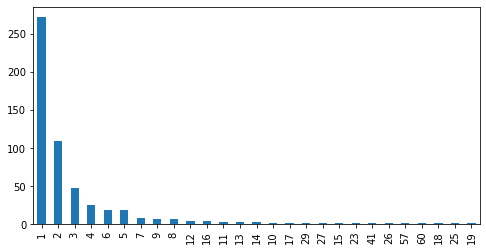

In [104]:
# Plot 'UniProt_variant_in_binding_site_count' value count if UniProt_variant_in_binding_site
subset_to_check[subset_to_check['UniProt_variant_in_binding_site']==True]['UniProt_variant_in_binding_site_count'].value_counts().plot.bar()

In [105]:
#subset_to_check.drop_duplicates(subset='accession', inplace=True)
#subset_to_check['UniProt_variant_in_binding_site'].value_counts()

### Repeating overlap assessment for disease_variant in binding_site (using new subset_to_check1)

In [106]:
# subset_to_check contains entries with UniProt_disease_variant_residues and binding_site_residues
subset_to_check1 = combined_out_df[(combined_out_df.UniProt_disease_variant_residues.apply(len) > 0) & (combined_out_df.binding_site_residues.apply(len) > 0)]
len(subset_to_check1)

851

In [107]:
# generate TRUE/FALSE column assessing if any binding_site_residues in UniProt_disease_variant_residues 
subset_to_check1['UniProt_disease_variant_in_binding_site'] = subset_to_check1.apply(lambda x: any(r in x.binding_site_residues for r in x.UniProt_disease_variant_residues ), axis=1)

/Users/melanie/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [108]:
subset_to_check1['UniProt_disease_variant_in_binding_site'].value_counts()

False    475
True     376
Name: UniProt_disease_variant_in_binding_site, dtype: int64

In [109]:
# generate overlap list of UniProt_variant_residues and binding_site_residues
subset_to_check1['UniProt_disease_variant_in_binding_site_list'] = subset_to_check1.apply(lambda x: [r for r in x.UniProt_disease_variant_residues if r in x.binding_site_residues], axis=1)

/Users/melanie/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [110]:
# generate count column
subset_to_check1['UniProt_disease_variant_in_binding_site_count'] = subset_to_check1.apply(lambda x: len(x.UniProt_disease_variant_in_binding_site_list), axis=1)


/Users/melanie/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [111]:
# UniProt_disease_variant_in_binding_site_change
#subset_to_check1['UniProt_disease_variant_in_binding_site_change'] = subset_to_check1.apply(lambda x: [v.split(', ')[1][0:6] for v in x.UniProt_disease_variant_notes if int(v.split(', ')[0]) in x.binding_site_residues], axis=1)
subset_to_check1['UniProt_disease_variant_in_binding_site_change'] = subset_to_check.apply(lambda x: [x.UniProt_disease_variant_changes[i] for i,r in enumerate(x.UniProt_disease_variant_single_change_residues) if r in x.binding_site_residues], axis=1)


/Users/melanie/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [112]:
subset_to_check1

,ensembl_gene_id,symbol,accession,Entry name,Protein names,IDG_family,IDG_dtoclass,IDG_tdl,IDG_fam,GO_BioProcess,...,UniProt_variant_notes,UniProt_variant_single_change_residues,UniProt_disease_variant_residues,UniProt_disease_variant_changes,UniProt_disease_variant_notes,UniProt_disease_variant_single_change_residues,UniProt_disease_variant_in_binding_site,UniProt_disease_variant_in_binding_site_list,UniProt_disease_variant_in_binding_site_count,UniProt_disease_variant_in_binding_site_change
0,ENSG00000146648,EGFR,P00533,EGFR_HUMAN,Epidermal growth factor receptor (EC 2.7.10.1)...,Belongs to the protein kinase superfamily. Tyr...,EGFR family,Tclin,Kinase,"['MAPK cascade', 'ossification', 'positive reg...",...,"[(30..297, Missing (variant EGFR vIII; found i...","[98, 266, 428, 521, 674, 709, 709, 709, 719, 7...",[428],[G -> D],"[428, G -> D (in NISBD2; loss of function; the...",[428],False,[],0,[]
1,ENSG00000128052,KDR,P35968,VGFR2_HUMAN,Vascular endothelial growth factor receptor 2 ...,Belongs to the protein kinase superfamily. Tyr...,VEGFR family,Tclin,Kinase,"['angiogenesis', 'branching involved in blood ...",...,"[(2, Q -> R (in a lung adenocarcinoma sample; ...","[2, 136, 248, 275, 297, 462, 472, 482, 539, 68...","[482, 1, 1, 1147]","[C -> R, P -> S]","[482, C -> R (in HCI; associated with disease ...","[482, 1147]",False,[],0,[]
2,ENSG00000141736,ERBB2,P04626,ERBB2_HUMAN,Receptor tyrosine-protein kinase erbB-2 (EC 2....,Belongs to the protein kinase superfamily. Tyr...,EGFR family,Tclin,Kinase,"['MAPK cascade', 'positive regulation of prote...",...,"[(452, W -> C (in dbSNP:rs4252633)), (654, I -...","[452, 654, 655, 755, 768, 774, 776, 779, 857, ...","[755, 774, 776, 779, 857, 914]","[L -> P, M -> M, G -> S, S -> S, N -> S, E -> K]","[755, L -> P (in LNCR; somatic mutation; unkno...","[755, 774, 776, 779, 857, 914]",True,[774],1,[M -> M]
4,ENSG00000198900,TOP1,P11387,TOP1_HUMAN,DNA topoisomerase 1 (EC 5.6.2.1) (DNA topoisom...,Belongs to the type IB topoisomerase family.,DNA topoisomerase,Tclin,Enzyme,"['DNA replication', 'DNA topological change', ...",...,"[(214, G -> S (in dbSNP:rs6029542)), (326, K -...","[214, 326, 370, 533, 722, 729]","[326, 370, 533, 722, 729]","[K -> R, M -> T, D -> G, N -> S, T -> A]","[326, K -> R (in breast cancer; somatic mutati...","[326, 370, 533, 722, 729]",True,"[533, 722]",2,"[D -> G, N -> S]"
6,ENSG00000105976,MET,P08581,MET_HUMAN,Hepatocyte growth factor receptor (HGF recepto...,Belongs to the protein kinase superfamily. Tyr...,MET family,Tclin,Kinase,"['MAPK cascade', 'endothelial cell morphogenes...",...,"[(143, R -> Q (in dbSNP:rs35469582)), (150, H ...","[143, 150, 156, 168, 238, 316, 320, 375, 375, ...","[773, 841, 1010, 991, 1092, 1094, 1094, 1094, ...","[P -> L, F -> V, P -> S, V -> I, H -> L, H -> ...","[773, P -> L (in gastric cancer; dbSNP:rs77133...","[773, 841, 991, 1092, 1094, 1094, 1094, 1106, ...",True,"[1092, 1131, 1195, 1220, 1228, 1228, 1230, 123...",10,"[V -> I, M -> T, L -> V, V -> I, D -> H, D -> ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3707,ENSG00000164458,TBXT,O15178,TBXT_HUMAN,T-box transcription factor T (Brachyury protei...,NaN,Rel homology transcription factor,Tbio,TF,['negative regulation of transcription by RNA ...,...,"[(156, G -> C (in NTD; unknown pathological si...","[156, 171, 177, 356, 358, 367, 369, 402]","[156, 171]","[G -> C, H -> R]","[156, G -> C (in NTD; unknown pathological sig...","[156, 171]",True,[171],1,[H -> R]
3715,ENSG00000223609,HBD,P02042,HBD_HUMAN,Hemoglobin subunit delta (Delta-globin) (Hemog...,Belongs to the globin family.,NaN,Tbio,NaN,"['blood coagulation', 'oxygen transport', 'hyd...",...,"[(2, V -> A (in Niigata; dbSNP:rs34991152)), (...","[2, 3, 3, 5, 5, 11, 12, 13, 17, 21, 23, 25, 26...","[2, 3, 3, 5, 11, 12, 13, 17, 21, 23, 25, 26, 2...","[V -> A, H -> L, H -> R, T -> S, A -> D, V -> ...","[2, V -> A (in Niigata; dbSNP:rs34991152), 3, ...","[2, 3, 3, 5, 11, 12, 13, 17, 21, 23

<AxesSubplot:>

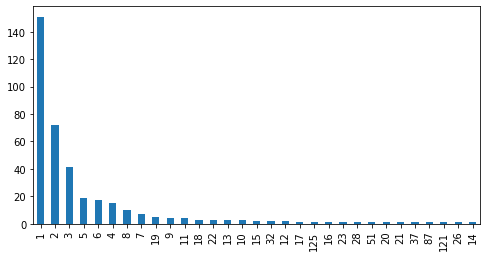

In [113]:
# Plot 'UniProt_disease_variant_in_binding_site_count' value count if UniProt_disease_variant_in_binding_site
subset_to_check1[subset_to_check1['UniProt_disease_variant_in_binding_site']==True]['UniProt_disease_variant_in_binding_site_count'].value_counts().plot.bar()

In [114]:
# Combining the datasets (combined_out_df, subset_to_check and to_check1)

out_df_ext = combined_out_df.merge(subset_to_check[['accession', 'UniProt_variant_in_binding_site', 'UniProt_variant_in_binding_site_list', 'UniProt_variant_in_binding_site_count','UniProt_variant_in_binding_site_change']], how='left', on='accession')
out_df_ext = out_df_ext.merge(subset_to_check1[['accession', 'UniProt_disease_variant_in_binding_site', 'UniProt_disease_variant_in_binding_site_list', 'UniProt_disease_variant_in_binding_site_count','UniProt_disease_variant_in_binding_site_change']], how='left', on='accession')

out_df_ext

,ensembl_gene_id,symbol,accession,Entry name,Protein names,IDG_family,IDG_dtoclass,IDG_tdl,IDG_fam,GO_BioProcess,...,UniProt_disease_variant_notes,UniProt_disease_variant_single_change_residues,UniProt_variant_in_binding_site,UniProt_variant_in_binding_site_list,UniProt_variant_in_binding_site_count,UniProt_variant_in_binding_site_change,UniProt_disease_variant_in_binding_site,UniProt_disease_variant_in_binding_site_list,UniProt_disease_variant_in_binding_site_count,UniProt_disease_variant_in_binding_site_change
0,ENSG00000146648,EGFR,P00533,EGFR_HUMAN,Epidermal growth factor receptor (EC 2.7.10.1)...,Belongs to the protein kinase superfamily. Tyr...,EGFR family,Tclin,Kinase,"['MAPK cascade', 'ossification', 'positive reg...",...,"[428, G -> D (in NISBD2; loss of function; the...",[428],True,"[719, 724, 747, 752, 790, 858, 861, 988]",8.0,"[G -> A, G -> C, G -> D, G -> S, G -> S, S -> ...",False,[],0.0,[]
1,ENSG00000128052,KDR,P35968,VGFR2_HUMAN,Vascular endothelial growth factor receptor 2 ...,Belongs to the protein kinase superfamily. Tyr...,VEGFR family,Tclin,Kinase,"['angiogenesis', 'branching involved in blood ...",...,"[482, C -> R (in HCI; associated with disease ...","[482, 1147]",True,[848],1.0,[V -> E],False,[],0.0,[]
2,ENSG00000141736,ERBB2,P04626,ERBB2_HUMAN,Receptor tyrosine-protein kinase erbB-2 (EC 2....,Belongs to the protein kinase superfamily. Tyr...,EGFR family,Tclin,Kinase,"['MAPK cascade', 'positive regulation of prote...",...,"[755, L -> P (in LNCR; somatic mutation; unkno...","[755, 774, 776, 779, 857, 914]",True,[774],1.0,[M -> M],True,[774],1.0,[M -> M]
3,ENSG00000005844,ITGAL,P20701,ITAL_HUMAN,Integrin alpha-L (CD11 antigen-like family mem...,Belongs to the integrin alpha chain family.,NaN,Tclin,NaN,['T cell activation via T cell receptor contac...,...,[],[],False,[],0.0,[],NaN,NaN,NaN,NaN
4,ENSG00000198900,TOP1,P11387,TOP1_HUMAN,DNA topoisomerase 1 (EC 5.6.2.1) (DNA topoisom...,Belongs to the type IB topoisomerase family.,DNA topoisomerase,Tclin,Enzyme,"['DNA replication', 'DNA topological change', ...",...,"[326, K -> R (in breast cancer; somatic mutati...","[326, 370, 533, 722, 729]",True,"[533, 722]",2.0,"[D -> G, N -> S]",True,"[533, 722]",2.0,"[D -> G, N -> S]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19481,ENSG00000221986,MYBPHL,A2RUH7,MBPHL_HUMAN,Myosin-binding protein H-like,Belongs to the immunoglobulin superfamily. MyB...,NaN,Tdark,NaN,"['in utero embryonic development', 'biological...",...,[],[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19482,ENSG00000228856,USP17L24; USP17L25; USP17L26; USP17L27; USP17L...,Q0WX57,U17LO_HUMAN,Ubiquitin carboxyl-terminal hydrolase 17-like ...,Belongs to the peptidase C19 family. USP17 sub...,Cysteine protease,Tbio,Enzyme,[],...,[],[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19483,ENSG00000254788,CKLF-CMTM1,E9PLU7,E9PLU7_HUMAN,CKLF-CMTM1 readthrough (Chemokine-like factor),NaN,NaN,NaN,NaN,[],...,[],[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19484,ENSG00000255501,CARD18,P57730,CAR18_HUMAN,Caspase recruitment domain-containing protein ...,NaN,NaN,Tbio,Enzyme,"['inflammatory response', 'negative regulation...",...,[],[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [115]:
# 

In [116]:
UniProt_variant_in_bs_changes = out_df_ext.loc[out_df_ext.UniProt_variant_in_binding_site_change.str.len() != 0].UniProt_variant_in_binding_site_change.tolist()
from pandas.core.common import flatten
UniProt_variant_in_bs_changes = list(flatten(UniProt_variant_in_bs_changes))
pd.Series(UniProt_variant_in_bs_changes).value_counts()[:10]

R -> Q    76
R -> H    67
R -> C    59
G -> R    50
R -> W    50
L -> P    50
E -> K    44
Y -> C    38
D -> N    37
A -> T    36
dtype: int64

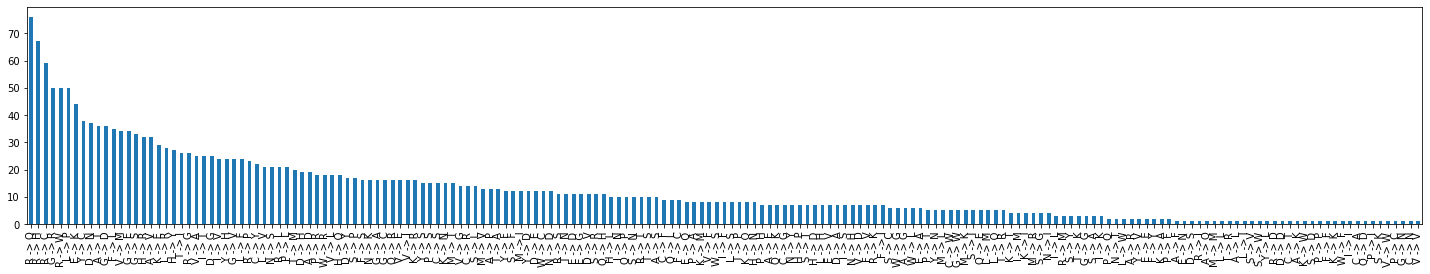

In [117]:
mpl.rcParams['figure.figsize'] = [25, 4]
pd.Series(UniProt_variant_in_bs_changes).value_counts().plot.bar()
mpl.rcParams['figure.figsize'] = [8, 4]

In [118]:
UniProt_disease_variant_in_bs_changes = out_df_ext.loc[out_df_ext.UniProt_disease_variant_notes.str.len() != 0].UniProt_disease_variant_in_binding_site_change.tolist()
from pandas.core.common import flatten
UniProt_disease_variant_in_bs_changes = list(flatten(UniProt_disease_variant_in_bs_changes))
pd.Series(UniProt_disease_variant_in_bs_changes).value_counts()[:10]

R -> Q    63
R -> H    55
R -> C    51
L -> P    48
R -> W    46
G -> R    44
E -> K    42
Y -> C    36
D -> N    31
H -> R    29
dtype: int64

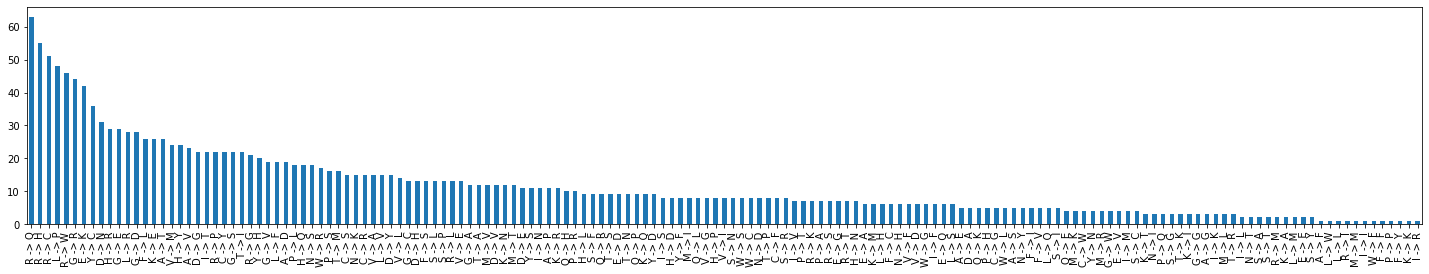

In [119]:
mpl.rcParams['figure.figsize'] = [25, 4]
pd.Series(UniProt_disease_variant_in_bs_changes).value_counts().plot.bar()
mpl.rcParams['figure.figsize'] = [8, 4]

Comparing amino acid changes: all changes, disease related changes and other (non-disease related) changes

In [120]:
# bsdvdf: binding site disease variant dataframe
bsdvdf1 = pd.DataFrame(pd.Series(UniProt_variant_in_bs_changes).value_counts(), columns=['variant_in_bs_count'])
bsdvdf2 = pd.DataFrame(pd.Series(UniProt_disease_variant_in_bs_changes).value_counts(), columns=['disease_variant_in_bs_count'])
bsdvdf = bsdvdf1.merge(bsdvdf2, how='left', left_index=True, right_index=True)
bsdvdf = bsdvdf.fillna(0).astype('int', copy=False)
bsdvdf['other_variant_in_bs_count'] = bsdvdf['variant_in_bs_count'] - bsdvdf['disease_variant_in_bs_count']
bsdvdf['diff_disease_other_variant_in_bs_count'] = bsdvdf['disease_variant_in_bs_count'] - bsdvdf['other_variant_in_bs_count']
#vdf['div_disease_other_variant_count'] = vdf['disease_variant_count'] / vdf['other_variant_count']
#vdf['div_disease_all_variant_count'] = vdf['disease_variant_count'] / vdf['all_variant_count']
#vdf['div_diff_disease_other_all_variant_count'] = vdf['diff_disease_other_variant_count'] / vdf['all_variant_count']

bsdvdf_sorted = bsdvdf.sort_values(by=['diff_disease_other_variant_in_bs_count'], ascending=False)
bsdvdf_sorted

,variant_in_bs_count,disease_variant_in_bs_count,other_variant_in_bs_count,diff_disease_other_variant_in_bs_count
R -> Q,76,63,13,50
L -> P,50,48,2,46
R -> H,67,55,12,43
R -> C,59,51,8,43
R -> W,50,46,4,42
...,...,...,...,...
A -> R,2,0,2,-2
Y -> V,2,0,2,-2
P -> F,2,0,2,-2
S -> T,7,2,5,-3


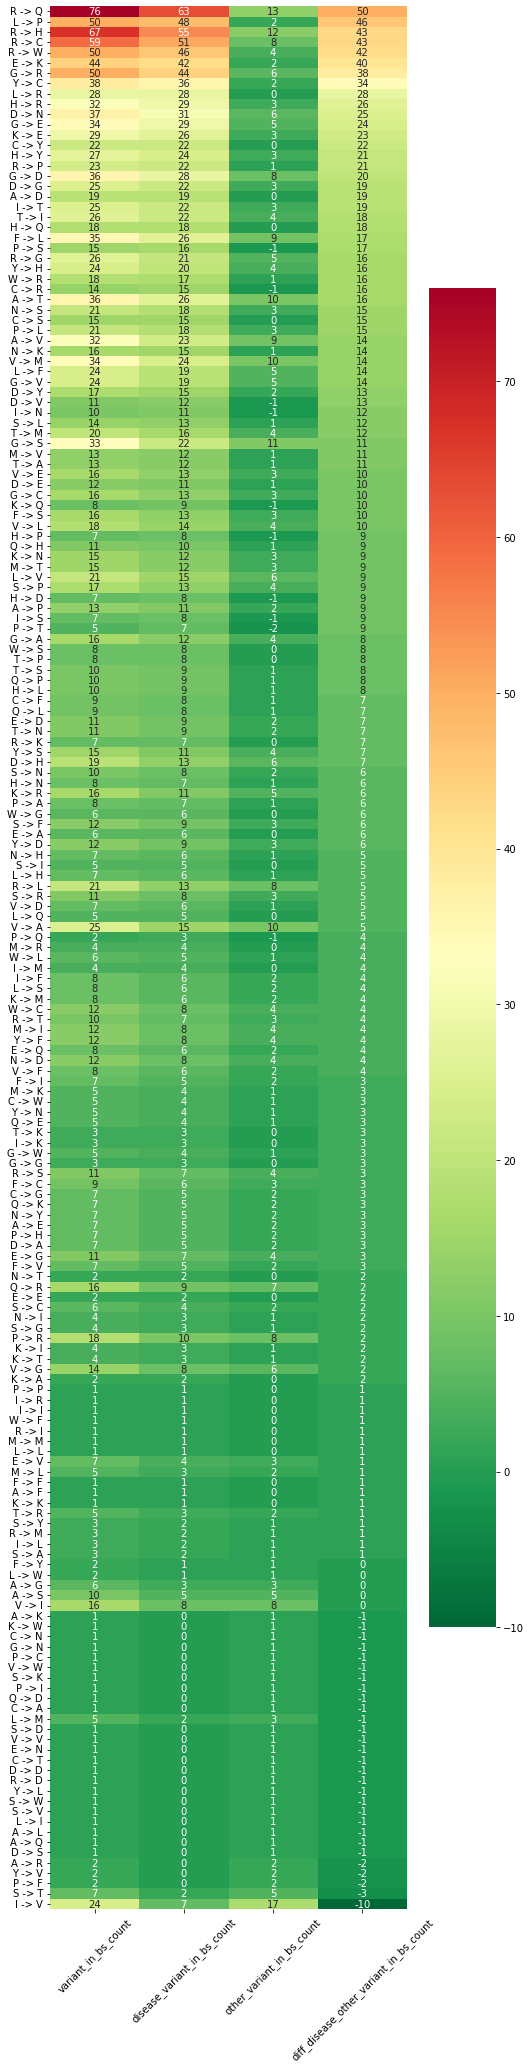

In [121]:
plt.rcParams['figure.figsize'] = [8, 35]
sns.heatmap(bsdvdf_sorted, annot=True, cmap='RdYlGn_r', fmt='d')#.set_xticklabels(rotation=45)
plt.xticks(rotation=45)
plt.rcParams['figure.figsize'] = [8, 4]

In [122]:
bsdvdf['other_variant_in_bs_count'].max(), bsdvdf['other_variant_in_bs_count'].mean()

(17, 2.3189189189189188)

In [123]:
bsdvdf['disease_variant_in_bs_count'].max(), bsdvdf['disease_variant_in_bs_count'].mean()

(63, 9.924324324324324)

In [124]:
bsdvdf['variant_in_bs_count'].max(), bsdvdf['variant_in_bs_count'].mean()

(76, 12.243243243243244)

In [125]:
# bsvdf: binding site variant dataframe

#vdf1 = pd.DataFrame(pd.Series(all_UniProt_variant_changes).value_counts(), columns=['all_variant_count'])
#vdf2 = pd.DataFrame(pd.Series(all_UniProt_disease_changes).value_counts(), columns=['disease_variant_count'])
#bsdvdf1 = pd.DataFrame(pd.Series(UniProt_variant_in_bs_changes).value_counts(), columns=['variant_in_bs_count'])
#bsdvdf2 = pd.DataFrame(pd.Series(UniProt_disease_variant_in_bs_changes).value_counts(), columns=['disease_variant_in_bs_count'])

bsvdf = vdf1.merge(bsdvdf1, how='left', left_index=True, right_index=True)
bsvdf = bsvdf.fillna(0).astype('int', copy=False)
bsvdf['variant_not_in_bs_count'] = bsvdf['all_variant_count'] - bsvdf['variant_in_bs_count']
bsvdf['diff_bs_notbs_variant_count'] = bsvdf['variant_in_bs_count'] - bsvdf['variant_not_in_bs_count']

#bsvdf_sorted = bsvdf.sort_values(by=['diff_bs_notbs_variant_count'], ascending=False)
bsvdf_sorted = bsvdf.sort_values(by=['variant_in_bs_count'], ascending=False)
bsvdf_sorted

,all_variant_count,variant_in_bs_count,variant_not_in_bs_count,diff_bs_notbs_variant_count
R -> Q,2447,76,2371,-2295
R -> H,2163,67,2096,-2029
R -> C,2078,59,2019,-1960
L -> P,1799,50,1749,-1699
G -> R,1959,50,1909,-1859
...,...,...,...,...
E -> S,2,0,2,-2
L -> C,2,0,2,-2
L -> E,2,0,2,-2
C -> V,2,0,2,-2


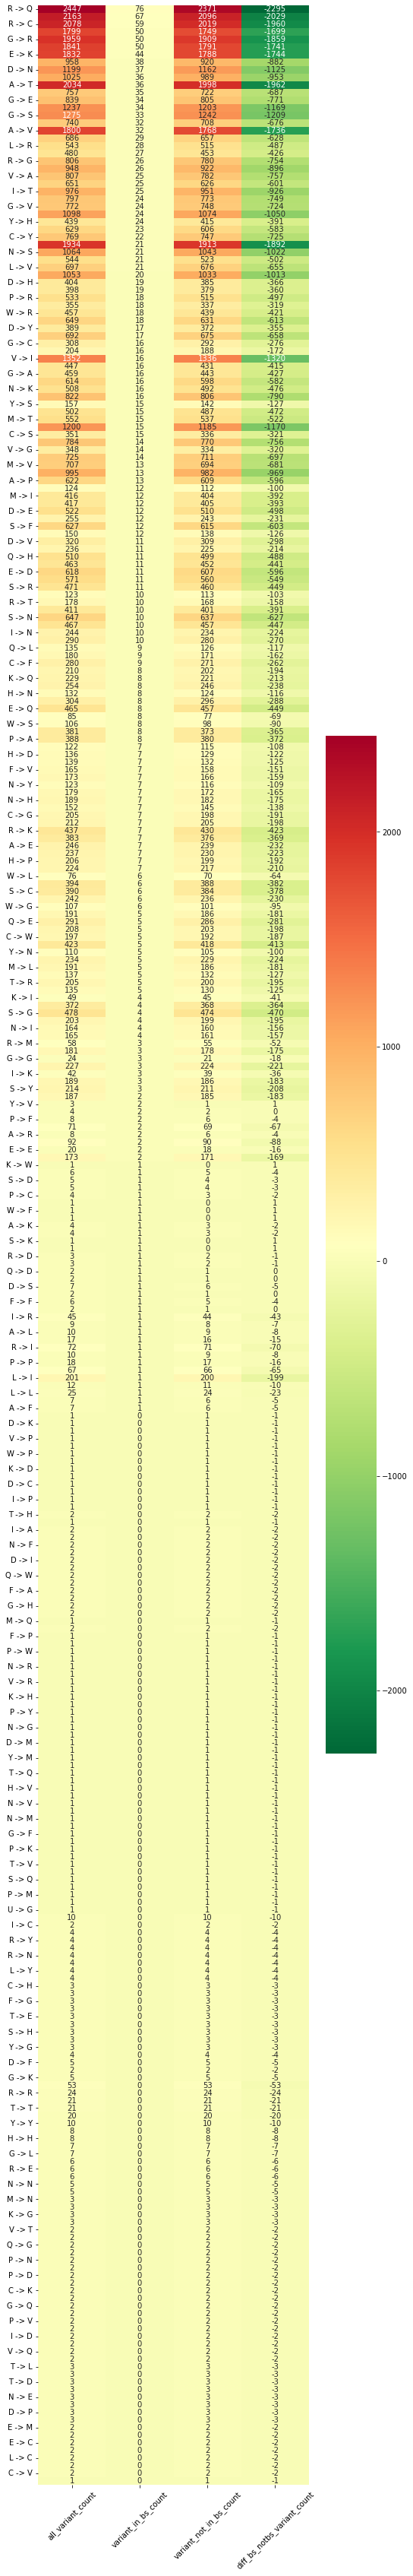

In [126]:
plt.rcParams['figure.figsize'] = [8, 60]
sns.heatmap(bsvdf_sorted, annot=True, cmap='RdYlGn_r', fmt='d')#.set_xticklabels(rotation=45)
plt.xticks(rotation=45)
plt.rcParams['figure.figsize'] = [8, 4]

In [127]:
bsvdf['variant_in_bs_count'].max(), bsvdf['variant_in_bs_count'].mean()

(76, 6.947852760736196)

In [128]:
bsvdf['variant_not_in_bs_count'].max(), bsvdf['variant_not_in_bs_count'].mean()

(2371, 236.69631901840492)

In [129]:
bsvdf['all_variant_count'].max(), bsvdf['all_variant_count'].mean()

(2447, 243.64417177914112)

In [130]:
#out_df_ext.drop_duplicates(subset='accession', inplace=True)
out_df_ext['UniProt_variant_in_binding_site'].value_counts(dropna=False)

NaN      17535
False     1407
True       544
Name: UniProt_variant_in_binding_site, dtype: int64

In [131]:
# check for unvalid/ missed data > should be 0
len(out_df_ext.loc[out_df_ext['UniProt_isoforms_count'].isna()])

0

In [132]:
# check for unvalid/ missed data > should be 0
len(out_df_ext.loc[out_df_ext['UniProt_variants_count'].isna()])

0

In [133]:
# check for unvalid/ missed data > should be 0
len(out_df_ext.loc[out_df_ext['UniProt_mutagens_count'].isna()])

0

In [134]:
# value counts
out_df_ext['UniProt_isoforms_count'].value_counts(dropna=False)
out_df_ext['UniProt_variants_count'].value_counts(dropna=False)
out_df_ext['UniProt_mutagens_count'].value_counts(dropna=False)

0     14850
1      1093
2       855
3       517
4       402
5       284
6       251
8       174
7       170
9       127
10      108
11       99
12       84
13       62
14       60
15       54
16       47
17       34
18       24
20       21
19       18
23       17
22       17
21       16
25       15
26       11
24        7
28        7
27        6
31        5
37        5
30        5
32        4
29        4
38        3
41        3
34        2
40        2
33        2
60        2
42        2
45        2
62        2
49        2
36        2
73        1
70        1
47        1
35        1
44        1
77        1
65        1
82        1
39        1
Name: UniProt_mutagens_count, dtype: int64

In [135]:
#combined_out_df.loc[combined_out_df['accession'] == 'P15056'] # BRAF_HUMAN
subset_to_check.loc[combined_out_df['accession'] == 'P15056'] # BRAF_HUMAN
out_df_ext.loc[out_df_ext['accession'] == 'P15056'] # BRAF_HUMAN

,ensembl_gene_id,symbol,accession,Entry name,Protein names,IDG_family,IDG_dtoclass,IDG_tdl,IDG_fam,GO_BioProcess,...,UniProt_disease_variant_notes,UniProt_disease_variant_single_change_residues,UniProt_variant_in_binding_site,UniProt_variant_in_binding_site_list,UniProt_variant_in_binding_site_count,UniProt_variant_in_binding_site_change,UniProt_disease_variant_in_binding_site,UniProt_disease_variant_in_binding_site_list,UniProt_disease_variant_in_binding_site_count,UniProt_disease_variant_in_binding_site_change
40,ENSG00000157764,BRAF,P15056,BRAF_HUMAN,Serine/threonine-protein kinase B-raf (EC 2.7....,Belongs to the protein kinase superfamily. TKL...,RAF family,Tclin,Kinase,"['MAPK cascade', 'MAPK cascade', 'protein phos...",...,"[241, T -> M (in NS7; dbSNP:rs387906660), 241,...","[241, 241, 241, 244, 245, 246, 257, 262, 275, ...",True,"[463, 464, 466, 467, 468, 501, 531, 580, 581, ...",14.0,"[I -> S, G -> E, G -> V, G -> A, G -> E, G -> ...",True,"[463, 464, 466, 466, 466, 467, 468, 501, 501, ...",19.0,"[I -> S, G -> E, G -> A, G -> E, G -> V, S -> ..."


In [136]:
# tying to find error source:
#[print(x) for x in combined_out_df.loc[combined_out_df['accession'] == 'P15056'].binding_site_residues]
#[print(x) for x in combined_out_df.loc[combined_out_df['accession'] == 'P15056'].UniProt_variant_residues]
#any(r in combined_out_df.loc[combined_out_df['accession'] == 'P15056'].binding_site_residues for r in combined_out_df.loc[combined_out_df['accession'] == 'P15056'].UniProt_variant_residues)
#set(combined_out_df.loc[combined_out_df['accession'] == 'P15056'].UniProt_variant_residues).intersection(set(combined_out_df.loc[combined_out_df['accession'] == 'P15056'].binding_site_residues))
#bool(set(combined_out_df.loc[combined_out_df['accession'] == 'P15056'].UniProt_variant_residues)&set(combined_out_df.loc[combined_out_df['accession'] == 'P15056'].binding_site_residues))
#np.isin(ast.literal_eval(list(combined_out_df.loc[combined_out_df['accession'] == 'P15056'].UniProt_variant_residues)[0]), list(combined_out_df.loc[combined_out_df['accession'] == 'P15056'].binding_site_residues)[0]).any()
# ERROR is due to handling of empty lists! - check further here:
#ast.literal_eval(list(combined_out_df.loc[combined_out_df['accession'] == 'P15056'].UniProt_variant_residues)[0])
#list(combined_out_df.loc[combined_out_df['accession'] == 'P15056'].binding_site_residues)[0]
#np.isin(ast.literal_eval(list(combined_out_df['UniProt_variant_residues'].iloc[19567])[0]), list(combined_out_df['binding_site_residues'].iloc[19567])[0]).any()
#np.isin(ast.literal_eval(subset_to_check['UniProt_variant_residues'].iloc[1843]), subset_to_check['binding_site_residues'].iloc[1843]).any()


In [137]:
out_df_ext.loc[out_df_ext['UniProt_variant_in_binding_site'] == True]

,ensembl_gene_id,symbol,accession,Entry name,Protein names,IDG_family,IDG_dtoclass,IDG_tdl,IDG_fam,GO_BioProcess,...,UniProt_disease_variant_notes,UniProt_disease_variant_single_change_residues,UniProt_variant_in_binding_site,UniProt_variant_in_binding_site_list,UniProt_variant_in_binding_site_count,UniProt_variant_in_binding_site_change,UniProt_disease_variant_in_binding_site,UniProt_disease_variant_in_binding_site_list,UniProt_disease_variant_in_binding_site_count,UniProt_disease_variant_in_binding_site_change
0,ENSG00000146648,EGFR,P00533,EGFR_HUMAN,Epidermal growth factor receptor (EC 2.7.10.1)...,Belongs to the protein kinase superfamily. Tyr...,EGFR family,Tclin,Kinase,"['MAPK cascade', 'ossification', 'positive reg...",...,"[428, G -> D (in NISBD2; loss of function; the...",[428],True,"[719, 724, 747, 752, 790, 858, 861, 988]",8.0,"[G -> A, G -> C, G -> D, G -> S, G -> S, S -> ...",False,[],0.0,[]
1,ENSG00000128052,KDR,P35968,VGFR2_HUMAN,Vascular endothelial growth factor receptor 2 ...,Belongs to the protein kinase superfamily. Tyr...,VEGFR family,Tclin,Kinase,"['angiogenesis', 'branching involved in blood ...",...,"[482, C -> R (in HCI; associated with disease ...","[482, 1147]",True,[848],1.0,[V -> E],False,[],0.0,[]
2,ENSG00000141736,ERBB2,P04626,ERBB2_HUMAN,Receptor tyrosine-protein kinase erbB-2 (EC 2....,Belongs to the protein kinase superfamily. Tyr...,EGFR family,Tclin,Kinase,"['MAPK cascade', 'positive regulation of prote...",...,"[755, L -> P (in LNCR; somatic mutation; unkno...","[755, 774, 776, 779, 857, 914]",True,[774],1.0,[M -> M],True,[774],1.0,[M -> M]
4,ENSG00000198900,TOP1,P11387,TOP1_HUMAN,DNA topoisomerase 1 (EC 5.6.2.1) (DNA topoisom...,Belongs to the type IB topoisomerase family.,DNA topoisomerase,Tclin,Enzyme,"['DNA replication', 'DNA topological change', ...",...,"[326, K -> R (in breast cancer; somatic mutati...","[326, 370, 533, 722, 729]",True,"[533, 722]",2.0,"[D -> G, N -> S]",True,"[533, 722]",2.0,"[D -> G, N -> S]"
6,ENSG00000105976,MET,P08581,MET_HUMAN,Hepatocyte growth factor receptor (HGF recepto...,Belongs to the protein kinase superfamily. Tyr...,MET family,Tclin,Kinase,"['MAPK cascade', 'endothelial cell morphogenes...",...,"[773, P -> L (in gastric cancer; dbSNP:rs77133...","[773, 841, 991, 1092, 1094, 1094, 1094, 1106, ...",True,"[1092, 1131, 1195, 1220, 1228, 1230, 1244]",7.0,"[V -> I, M -> T, L -> V, V -> I, D -> H, D -> ...",True,"[1092, 1131, 1195, 1220, 1228, 1228, 1230, 123...",10.0,"[V -> I, M -> T, L -> V, V -> I, D -> H, D -> ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3703,ENSG00000140623,SEPTIN12,Q8IYM1,SEP12_HUMAN,Septin-12,Belongs to the TRAFAC class TrmE-Era-EngA-EngB...,Small GTPase,Tbio,NaN,"['spermatogenesis', 'cell differentiation', 'c...",...,"[89, T -> M (in SPGF10; results in significant...","[89, 197]",True,"[89, 197]",2.0,"[T -> M, D -> N]",True,"[89, 197]",2.0,"[T -> M, D -> N]"
3704,ENSG00000145331,TRMT10A,Q8TBZ6,TM10A_HUMAN,tRNA methyltransferase 10 homolog A (EC 2.1.1....,Belongs to the class IV-like SAM-binding methy...,NaN,Tbio,Enzyme,"['tRNA N1-guanine methylation', 'tRNA methylat...",...,"[27..339, Missing (in MSSGM1), 93..339, Missin...",[206],True,[206],1.0,[G -> R],True,[206],1.0,[G -> R]
3707,ENSG00000164458,TBXT,O15178,TBXT_HUMAN,T-box transcription factor T (Brachyury protei...,NaN,Rel homology transcription factor,Tbio,TF,['negative regulation of transcription by RNA ...,...,"[156, G -> C (in NTD; unknown pathological sig...","[156, 171]",True,[171],1.0,[H -> R],True,[171],1.0,[H -> R]
3715,ENSG00000223609,HBD,P02042,HBD_HUMAN,Hemoglobin subunit delta (Delta-globin) (Hemog...,Belongs to the globin family.,NaN,Tbio,NaN,"['blood coagulation', 'oxygen transport', 'hyd...",...,"[2, V -> A (in Niigata; dbSNP:rs34991152), 3, ...","[2, 3, 3, 5, 11, 12, 13, 17, 21, 23, 25, 26, 2...",True,"[71, 86, 89, 99, 142]",5.0,"[A -> G, F -> S, L -> V, V -> M, L -> P]",True,"[71, 86, 89, 99, 142]",5.0,"[A -> G, F 

In [138]:
# save UniProt_variant_in_binding_site dataframe to file
out_df_ext.loc[out_df_ext['UniProt_variant_in_binding_site'] == True].to_csv("/Users/melanie/tractability_project/Variation_data/UniProt_variant_in_binding_site.csv", index=False)


### Merging UniProt disease variation data (based on label) with out_df_ext

In [139]:
out_df_ext = out_df_ext.merge(disease_variant[['accession','UniProt_disease_variant_label']], how='left', on='accession')
out_df_ext['UniProt_disease_variant_label'].fillna('No', inplace=True)

In [140]:
out_df_ext['UniProt_disease_variant_label'].value_counts()

No     16154
Yes     3332
Name: UniProt_disease_variant_label, dtype: int64

In [141]:
out_df_ext

,ensembl_gene_id,symbol,accession,Entry name,Protein names,IDG_family,IDG_dtoclass,IDG_tdl,IDG_fam,GO_BioProcess,...,UniProt_disease_variant_single_change_residues,UniProt_variant_in_binding_site,UniProt_variant_in_binding_site_list,UniProt_variant_in_binding_site_count,UniProt_variant_in_binding_site_change,UniProt_disease_variant_in_binding_site,UniProt_disease_variant_in_binding_site_list,UniProt_disease_variant_in_binding_site_count,UniProt_disease_variant_in_binding_site_change,UniProt_disease_variant_label
0,ENSG00000146648,EGFR,P00533,EGFR_HUMAN,Epidermal growth factor receptor (EC 2.7.10.1)...,Belongs to the protein kinase superfamily. Tyr...,EGFR family,Tclin,Kinase,"['MAPK cascade', 'ossification', 'positive reg...",...,[428],True,"[719, 724, 747, 752, 790, 858, 861, 988]",8.0,"[G -> A, G -> C, G -> D, G -> S, G -> S, S -> ...",False,[],0.0,[],Yes
1,ENSG00000128052,KDR,P35968,VGFR2_HUMAN,Vascular endothelial growth factor receptor 2 ...,Belongs to the protein kinase superfamily. Tyr...,VEGFR family,Tclin,Kinase,"['angiogenesis', 'branching involved in blood ...",...,"[482, 1147]",True,[848],1.0,[V -> E],False,[],0.0,[],No
2,ENSG00000141736,ERBB2,P04626,ERBB2_HUMAN,Receptor tyrosine-protein kinase erbB-2 (EC 2....,Belongs to the protein kinase superfamily. Tyr...,EGFR family,Tclin,Kinase,"['MAPK cascade', 'positive regulation of prote...",...,"[755, 774, 776, 779, 857, 914]",True,[774],1.0,[M -> M],True,[774],1.0,[M -> M],No
3,ENSG00000005844,ITGAL,P20701,ITAL_HUMAN,Integrin alpha-L (CD11 antigen-like family mem...,Belongs to the integrin alpha chain family.,NaN,Tclin,NaN,['T cell activation via T cell receptor contac...,...,[],False,[],0.0,[],NaN,NaN,NaN,NaN,No
4,ENSG00000198900,TOP1,P11387,TOP1_HUMAN,DNA topoisomerase 1 (EC 5.6.2.1) (DNA topoisom...,Belongs to the type IB topoisomerase family.,DNA topoisomerase,Tclin,Enzyme,"['DNA replication', 'DNA topological change', ...",...,"[326, 370, 533, 722, 729]",True,"[533, 722]",2.0,"[D -> G, N -> S]",True,"[533, 722]",2.0,"[D -> G, N -> S]",No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19481,ENSG00000221986,MYBPHL,A2RUH7,MBPHL_HUMAN,Myosin-binding protein H-like,Belongs to the immunoglobulin superfamily. MyB...,NaN,Tdark,NaN,"['in utero embryonic development', 'biological...",...,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
19482,ENSG00000228856,USP17L24; USP17L25; USP17L26; USP17L27; USP17L...,Q0WX57,U17LO_HUMAN,Ubiquitin carboxyl-terminal hydrolase 17-like ...,Belongs to the peptidase C19 family. USP17 sub...,Cysteine protease,Tbio,Enzyme,[],...,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
19483,ENSG00000254788,CKLF-CMTM1,E9PLU7,E9PLU7_HUMAN,CKLF-CMTM1 readthrough (Chemokine-like factor),NaN,NaN,NaN,NaN,[],...,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
19484,ENSG00000255501,CARD18,P57730,CAR18_HUMAN,Caspase recruitment domain-containing protein ...,NaN,NaN,Tbio,Enzyme,"['inflammatory response', 'negative regulation...",...,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No


In [142]:
for i in disease_variant.accession:
    if i not in out_df_ext.accession.to_list():
        print(i)

P24928
Q9BYB0
P01834
Q9UMN6
P49335
Q9UMZ3
P02746
P00736
Q96EY9
P63092
P39880
O95278
Q03468
P84996
O43826
O96033
Q6PRD1
P01137


P0DP24
P35520
P01834
P63092
P84996
Q03468
O96033
P04156
Q5JWF2
P0DPB6
P02489
P0DPH8
Q01081
Q9BYB0
P0DP25

### Merging ChEMBL variation data with out_df_ext, check for variants in binding site, add info to out_df_ext2

In [143]:
out_df_ext2 = out_df_ext.merge(chembl_data_grouped2, how='left', left_on='accession', right_on='variant_sequence.accession')
out_df_ext2

,ensembl_gene_id,symbol,accession,Entry name,Protein names,IDG_family,IDG_dtoclass,IDG_tdl,IDG_fam,GO_BioProcess,...,UniProt_variant_in_binding_site_change,UniProt_disease_variant_in_binding_site,UniProt_disease_variant_in_binding_site_list,UniProt_disease_variant_in_binding_site_count,UniProt_disease_variant_in_binding_site_change,UniProt_disease_variant_label,variant_sequence.accession,assay_chembl_id,ChEMBL_variant_mutation,ChEMBL_variant_residue
0,ENSG00000146648,EGFR,P00533,EGFR_HUMAN,Epidermal growth factor receptor (EC 2.7.10.1)...,Belongs to the protein kinase superfamily. Tyr...,EGFR family,Tclin,Kinase,"['MAPK cascade', 'ossification', 'positive reg...",...,"[G -> A, G -> C, G -> D, G -> S, G -> S, S -> ...",False,[],0.0,[],Yes,P00533,"[CHEMBL939338, CHEMBL939339, CHEMBL922817, CHE...","[L858R, L861Q, T790M, G719C, G719S, L861R, G719A]","[719, 790, 858, 861]"
1,ENSG00000128052,KDR,P35968,VGFR2_HUMAN,Vascular endothelial growth factor receptor 2 ...,Belongs to the protein kinase superfamily. Tyr...,VEGFR family,Tclin,Kinase,"['angiogenesis', 'branching involved in blood ...",...,[V -> E],False,[],0.0,[],No,P35968,"[CHEMBL3881021, CHEMBL3881022, CHEMBL3881023, ...",[E990V],[990]
2,ENSG00000141736,ERBB2,P04626,ERBB2_HUMAN,Receptor tyrosine-protein kinase erbB-2 (EC 2....,Belongs to the protein kinase superfamily. Tyr...,EGFR family,Tclin,Kinase,"['MAPK cascade', 'positive regulation of prote...",...,[M -> M],True,[774],1.0,[M -> M],No,P04626,"[CHEMBL4314691, CHEMBL4335077, CHEMBL4336904, ...",[G778D],[778]
3,ENSG00000005844,ITGAL,P20701,ITAL_HUMAN,Integrin alpha-L (CD11 antigen-like family mem...,Belongs to the integrin alpha chain family.,NaN,Tclin,NaN,['T cell activation via T cell receptor contac...,...,[],NaN,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN
4,ENSG00000198900,TOP1,P11387,TOP1_HUMAN,DNA topoisomerase 1 (EC 5.6.2.1) (DNA topoisom...,Belongs to the type IB topoisomerase family.,DNA topoisomerase,Tclin,Enzyme,"['DNA replication', 'DNA topological change', ...",...,"[D -> G, N -> S]",True,"[533, 722]",2.0,"[D -> G, N -> S]",No,P11387,[CHEMBL4341324],[N722S],[722]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19481,ENSG00000221986,MYBPHL,A2RUH7,MBPHL_HUMAN,Myosin-binding protein H-like,Belongs to the immunoglobulin superfamily. MyB...,NaN,Tdark,NaN,"['in utero embryonic development', 'biological...",...,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN
19482,ENSG00000228856,USP17L24; USP17L25; USP17L26; USP17L27; USP17L...,Q0WX57,U17LO_HUMAN,Ubiquitin carboxyl-terminal hydrolase 17-like ...,Belongs to the peptidase C19 family. USP17 sub...,Cysteine protease,Tbio,Enzyme,[],...,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN
19483,ENSG00000254788,CKLF-CMTM1,E9PLU7,E9PLU7_HUMAN,CKLF-CMTM1 readthrough (Chemokine-like factor),NaN,NaN,NaN,NaN,[],...,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN
19484,ENSG00000255501,CARD18,P57730,CAR18_HUMAN,Caspase recruitment domain-containing protein ...,NaN,NaN,Tbio,Enzyme,"['inflammatory response', 'negative regulation...",...,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN


In [144]:
# # of UniProt_variant in PDBe_binding_site
len(out_df_ext2.loc[out_df_ext2.UniProt_variant_in_binding_site_count>0])

544

In [145]:
# checking data type and structure
out_df_ext2.binding_site_residues[0]
out_df_ext2.UniProt_variant_residues[0]
out_df_ext2.UniProt_disease_variant_residues[0]
out_df_ext2.ChEMBL_variant_residue[0]

[719, 790, 858, 861]

In [146]:
# Overlap of ChEMBL_variant_residue with PDBe binding_site_residues
to_check2 = out_df_ext2.loc[out_df_ext2.binding_site_residues.notna() & out_df_ext2.ChEMBL_variant_residue.notna()]
len(to_check2)

323

In [147]:
# Overlap of ChEMBL_variant_residue with UniProt UniProt_variant_residues
to_check3 = out_df_ext2.loc[out_df_ext2.UniProt_variant_residues.notna() & out_df_ext2.ChEMBL_variant_residue.notna()]
len(to_check3)

323

In [148]:
# Overlap of ChEMBL_variant_residue with UniProt UniProt_disease_variant_residues
to_check4 = out_df_ext2.loc[out_df_ext2.UniProt_disease_variant_residues.notna() & out_df_ext2.ChEMBL_variant_residue.notna()]
len(to_check4)

323

In [149]:
# convert residue numbers from integers to strings

to_check2.ChEMBL_variant_residue = to_check2.ChEMBL_variant_residue.map(lambda x: [str(i) for i in (x)])
to_check2.binding_site_residues = to_check2.binding_site_residues.map(lambda x: [str(i) for i in (x)])

to_check3.ChEMBL_variant_residue = to_check3.ChEMBL_variant_residue.map(lambda x: [str(i) for i in (x)])
to_check3.UniProt_variant_residues = to_check3.UniProt_variant_residues.map(lambda x: [str(i) for i in (x)])

to_check4.ChEMBL_variant_residue = to_check4.ChEMBL_variant_residue.map(lambda x: [str(i) for i in (x)])
to_check4.UniProt_disease_variant_residues = to_check4.UniProt_disease_variant_residues.map(lambda x: [str(i) for i in (x)])


/Users/melanie/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [150]:
# assess overlap and save in new column

to_check2['ChEMBL_variant_in_binding_site_list'] = to_check2.apply(lambda x: [r for r in x.ChEMBL_variant_residue if r in x.binding_site_residues], axis=1)
to_check2['ChEMBL_variant_in_binding_site_count'] = to_check2.apply(lambda x: len(x.ChEMBL_variant_in_binding_site_list), axis=1) 
to_check2.ChEMBL_variant_in_binding_site_count.value_counts()

to_check3['ChEMBLvariant_in_UniProt_variant_list'] = to_check3.apply(lambda x: [r for r in x.ChEMBL_variant_residue if r in x.UniProt_variant_residues], axis=1)
to_check3['ChEMBLvariant_in_UniProt_variant_count'] = to_check3.apply(lambda x: len(x.ChEMBLvariant_in_UniProt_variant_list), axis=1) 

to_check4['ChEMBLvariant_in_UniProt_disease_variant_list'] = to_check4.apply(lambda x: [r for r in x.ChEMBL_variant_residue if r in x.UniProt_disease_variant_residues], axis=1)
to_check4['ChEMBLvariant_in_UniProt_disease_variant_count'] = to_check4.apply(lambda x: len(x.ChEMBLvariant_in_UniProt_disease_variant_list), axis=1) 


/Users/melanie/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/melanie/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/melanie/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on 

In [151]:
# re-convert residue numbers from strings to sorted integers

to_check2.ChEMBL_variant_residue = to_check2.ChEMBL_variant_residue.map(lambda x: sorted([int(i) for i in x]))
to_check2.binding_site_residues = to_check2.binding_site_residues.map(lambda x: sorted([int(i) for i in x]))

to_check3.ChEMBL_variant_residue = to_check3.ChEMBL_variant_residue.map(lambda x: sorted([int(i) for i in x]))
to_check3.UniProt_variant_residues = to_check3.UniProt_variant_residues.map(lambda x: sorted([int(i) for i in x]))

to_check4.ChEMBL_variant_residue = to_check4.ChEMBL_variant_residue.map(lambda x: sorted([int(i) for i in x]))
to_check4.UniProt_disease_variant_residues = to_check4.UniProt_disease_variant_residues.map(lambda x: sorted([int(i) for i in x]))


In [152]:
to_check2[['accession','binding_site_residues','ChEMBL_variant_residue',
           'ChEMBL_variant_in_binding_site_list','ChEMBL_variant_in_binding_site_count']]

,accession,binding_site_residues,ChEMBL_variant_residue,ChEMBL_variant_in_binding_site_list,ChEMBL_variant_in_binding_site_count
0,P00533,"[718, 719, 720, 721, 722, 723, 724, 726, 728, ...","[719, 790, 858, 861]","[719, 790, 858, 861]",4
1,P35968,"[840, 841, 842, 843, 848, 850, 866, 868, 885, ...",[990],[],0
2,P04626,"[726, 727, 729, 734, 751, 753, 770, 774, 783, ...",[778],[],0
4,P11387,"[351, 352, 356, 364, 532, 533, 718, 722]",[722],[722],1
6,P08581,"[1084, 1085, 1086, 1087, 1088, 1089, 1092, 110...","[1094, 1100, 1195, 1200, 1228, 1230, 1235, 1250]","[1195, 1200, 1228, 1230, 1235]",5
...,...,...,...,...,...
11976,Q9NZN5,[],"[979, 982, 983, 1099]",[],0
12328,Q92945,[],"[436, 473, 500, 564, 620, 627]",[],0
12507,Q99598,[],[126],[],0
14715,Q04864,[],[27],[],0


In [153]:
to_check3[['accession','ChEMBL_variant_residue','UniProt_variant_residues',
           'ChEMBLvariant_in_UniProt_variant_list','ChEMBLvariant_in_UniProt_variant_count']]

,accession,ChEMBL_variant_residue,UniProt_variant_residues,ChEMBLvariant_in_UniProt_variant_list,ChEMBLvariant_in_UniProt_variant_count
0,P00533,"[719, 790, 858, 861]","[30, 98, 266, 428, 521, 674, 709, 719, 724, 73...","[719, 790, 858, 861]",4
1,P35968,[990],"[2, 136, 248, 275, 297, 462, 472, 482, 539, 68...",[],0
2,P04626,[778],"[452, 654, 655, 755, 768, 774, 776, 779, 857, ...",[],0
4,P11387,[722],"[214, 326, 370, 533, 722, 729]",[722],1
6,P08581,"[1094, 1100, 1195, 1200, 1228, 1230, 1235, 1250]","[143, 150, 156, 168, 238, 316, 320, 375, 385, ...","[1094, 1195, 1228, 1230, 1250]",5
...,...,...,...,...,...
11976,Q9NZN5,"[979, 982, 983, 1099]",[973],[],0
12328,Q92945,"[436, 473, 500, 564, 620, 627]",[],[],0
12507,Q99598,[126],[],[],0
14715,Q04864,[27],[],[],0


In [154]:
to_check4[['accession','ChEMBL_variant_residue','UniProt_disease_variant_residues',
           'ChEMBLvariant_in_UniProt_disease_variant_list','ChEMBLvariant_in_UniProt_disease_variant_count']]

,accession,ChEMBL_variant_residue,UniProt_disease_variant_residues,ChEMBLvariant_in_UniProt_disease_variant_list,ChEMBLvariant_in_UniProt_disease_variant_count
0,P00533,"[719, 790, 858, 861]",[428],[],0
1,P35968,[990],"[1, 1, 482, 1147]",[],0
2,P04626,[778],"[755, 774, 776, 779, 857, 914]",[],0
4,P11387,[722],"[326, 370, 533, 722, 729]",[722],1
6,P08581,"[1094, 1100, 1195, 1200, 1228, 1230, 1235, 1250]","[773, 841, 991, 1010, 1092, 1094, 1094, 1094, ...","[1094, 1195, 1228, 1230, 1250]",5
...,...,...,...,...,...
11976,Q9NZN5,"[979, 982, 983, 1099]",[],[],0
12328,Q92945,"[436, 473, 500, 564, 620, 627]",[],[],0
12507,Q99598,[126],[],[],0
14715,Q04864,[27],[],[],0


In [155]:
# save UniProt_variant_in_binding_site dataframe to file
to_check2.to_csv("/Users/melanie/tractability_project/Variation_data/ChEMBL_variants.csv", index=False)

In [156]:
# merge datasets

out_df_ext3 = out_df_ext2.merge(to_check2[['accession','ChEMBL_variant_in_binding_site_list','ChEMBL_variant_in_binding_site_count']], how='left', on='accession')
out_df_ext3 = out_df_ext3.merge(to_check3[['accession','ChEMBLvariant_in_UniProt_variant_list','ChEMBLvariant_in_UniProt_variant_count']], how='left', on='accession')
out_df_ext3 = out_df_ext3.merge(to_check4[['accession','ChEMBLvariant_in_UniProt_disease_variant_list','ChEMBLvariant_in_UniProt_disease_variant_count']], how='left', on='accession')

out_df_ext3.binding_site_residues = out_df_ext3.binding_site_residues.map(lambda x: sorted([int(i) for i in x]))
#df.UniProt_variant_residues = df.UniProt_variant_residues.map(lambda x: sorted([int(i) for i in ast.literal_eval(x)]))
#df.UniProt_variant_residues = df.UniProt_variant_residues.map(lambda x: sorted([int(i) for i in x]))
#df.UniProt_variant_in_binding_site_list = df.UniProt_variant_in_binding_site_list.map(lambda x: sorted([int(i) for i in x if x!=np.nan]))
#df.ChEMBL_variant_residue = df.ChEMBL_variant_residue.map(lambda x: sorted([int(i) for i in x]))

In [157]:
out_df_ext3

,ensembl_gene_id,symbol,accession,Entry name,Protein names,IDG_family,IDG_dtoclass,IDG_tdl,IDG_fam,GO_BioProcess,...,variant_sequence.accession,assay_chembl_id,ChEMBL_variant_mutation,ChEMBL_variant_residue,ChEMBL_variant_in_binding_site_list,ChEMBL_variant_in_binding_site_count,ChEMBLvariant_in_UniProt_variant_list,ChEMBLvariant_in_UniProt_variant_count,ChEMBLvariant_in_UniProt_disease_variant_list,ChEMBLvariant_in_UniProt_disease_variant_count
0,ENSG00000146648,EGFR,P00533,EGFR_HUMAN,Epidermal growth factor receptor (EC 2.7.10.1)...,Belongs to the protein kinase superfamily. Tyr...,EGFR family,Tclin,Kinase,"['MAPK cascade', 'ossification', 'positive reg...",...,P00533,"[CHEMBL939338, CHEMBL939339, CHEMBL922817, CHE...","[L858R, L861Q, T790M, G719C, G719S, L861R, G719A]","[719, 790, 858, 861]","[719, 790, 858, 861]",4.0,"[719, 790, 858, 861]",4.0,[],0.0
1,ENSG00000128052,KDR,P35968,VGFR2_HUMAN,Vascular endothelial growth factor receptor 2 ...,Belongs to the protein kinase superfamily. Tyr...,VEGFR family,Tclin,Kinase,"['angiogenesis', 'branching involved in blood ...",...,P35968,"[CHEMBL3881021, CHEMBL3881022, CHEMBL3881023, ...",[E990V],[990],[],0.0,[],0.0,[],0.0
2,ENSG00000141736,ERBB2,P04626,ERBB2_HUMAN,Receptor tyrosine-protein kinase erbB-2 (EC 2....,Belongs to the protein kinase superfamily. Tyr...,EGFR family,Tclin,Kinase,"['MAPK cascade', 'positive regulation of prote...",...,P04626,"[CHEMBL4314691, CHEMBL4335077, CHEMBL4336904, ...",[G778D],[778],[],0.0,[],0.0,[],0.0
3,ENSG00000005844,ITGAL,P20701,ITAL_HUMAN,Integrin alpha-L (CD11 antigen-like family mem...,Belongs to the integrin alpha chain family.,NaN,Tclin,NaN,['T cell activation via T cell receptor contac...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ENSG00000198900,TOP1,P11387,TOP1_HUMAN,DNA topoisomerase 1 (EC 5.6.2.1) (DNA topoisom...,Belongs to the type IB topoisomerase family.,DNA topoisomerase,Tclin,Enzyme,"['DNA replication', 'DNA topological change', ...",...,P11387,[CHEMBL4341324],[N722S],[722],[722],1.0,[722],1.0,[722],1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19481,ENSG00000221986,MYBPHL,A2RUH7,MBPHL_HUMAN,Myosin-binding protein H-like,Belongs to the immunoglobulin superfamily. MyB...,NaN,Tdark,NaN,"['in utero embryonic development', 'biological...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19482,ENSG00000228856,USP17L24; USP17L25; USP17L26; USP17L27; USP17L...,Q0WX57,U17LO_HUMAN,Ubiquitin carboxyl-terminal hydrolase 17-like ...,Belongs to the peptidase C19 family. USP17 sub...,Cysteine protease,Tbio,Enzyme,[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19483,ENSG00000254788,CKLF-CMTM1,E9PLU7,E9PLU7_HUMAN,CKLF-CMTM1 readthrough (Chemokine-like factor),NaN,NaN,NaN,NaN,[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19484,ENSG00000255501,CARD18,P57730,CAR18_HUMAN,Caspase recruitment domain-containing protein ...,NaN,NaN,Tbio,Enzyme,"['inflammatory response', 'negative regulation...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [158]:
out_df_ext3.columns

Index(['ensembl_gene_id', 'symbol', 'accession', 'Entry name', 'Protein names',
       'IDG_family', 'IDG_dtoclass', 'IDG_tdl', 'IDG_fam', 'GO_BioProcess',
       'GO_MolFunction', 'SM_B1_Approved Drug', 'SM_B2_Advanced Clinical',
       'SM_B3_Phase 1 Clinical', 'SM_B4_Structure with Ligand',
       'SM_B5_High-Quality Ligand', 'binding_site_residues',
       'UniProt_isoforms_count', 'Natural variant', 'UniProt_variants_count',
       'UniProt_mutagens_count', 'UniProt_variant_residues',
       'UniProt_variant_changes', 'UniProt_variant_notes',
       'UniProt_variant_single_change_residues',
       'UniProt_disease_variant_residues', 'UniProt_disease_variant_changes',
       'UniProt_disease_variant_notes',
       'UniProt_disease_variant_single_change_residues',
       'UniProt_variant_in_binding_site',
       'UniProt_variant_in_binding_site_list',
       'UniProt_variant_in_binding_site_count',
       'UniProt_variant_in_binding_site_change',
       'UniProt_disease_variant_in_b

In [159]:
# save full dataset to file
out_df_ext3.to_csv("/Users/melanie/tractability_project/Variation_data/variation_full_dataset.csv", index=False)

# Variation data analysis

## Overlap analysis

In [160]:
df = out_df_ext3

In [161]:
# where ChEMBLvariant_in_UniProt_disease_variant
df.loc[df.ChEMBLvariant_in_UniProt_disease_variant_count>0]

,ensembl_gene_id,symbol,accession,Entry name,Protein names,IDG_family,IDG_dtoclass,IDG_tdl,IDG_fam,GO_BioProcess,...,variant_sequence.accession,assay_chembl_id,ChEMBL_variant_mutation,ChEMBL_variant_residue,ChEMBL_variant_in_binding_site_list,ChEMBL_variant_in_binding_site_count,ChEMBLvariant_in_UniProt_variant_list,ChEMBLvariant_in_UniProt_variant_count,ChEMBLvariant_in_UniProt_disease_variant_list,ChEMBLvariant_in_UniProt_disease_variant_count
4,ENSG00000198900,TOP1,P11387,TOP1_HUMAN,DNA topoisomerase 1 (EC 5.6.2.1) (DNA topoisom...,Belongs to the type IB topoisomerase family.,DNA topoisomerase,Tclin,Enzyme,"['DNA replication', 'DNA topological change', ...",...,P11387,[CHEMBL4341324],[N722S],[722],[722],1.0,[722],1.0,[722],1.0
6,ENSG00000105976,MET,P08581,MET_HUMAN,Hepatocyte growth factor receptor (HGF recepto...,Belongs to the protein kinase superfamily. Tyr...,MET family,Tclin,Kinase,"['MAPK cascade', 'endothelial cell morphogenes...",...,P08581,"[CHEMBL989225, CHEMBL989226, CHEMBL989227, CHE...","[D1228H, M1250T, H1094R, Y1230H, Y1235D, N1100...","[1094, 1100, 1195, 1200, 1228, 1230, 1235, 1250]","[1195, 1200, 1228, 1230, 1235]",5.0,"[1094, 1195, 1228, 1230, 1250]",5.0,"[1094, 1195, 1228, 1230, 1250]",5.0
9,ENSG00000066468,FGFR2,P21802,FGFR2_HUMAN,Fibroblast growth factor receptor 2 (FGFR-2) (...,Belongs to the protein kinase superfamily. Tyr...,FGFR family,Tclin,Kinase,['negative regulation of transcription by RNA ...,...,P21802,"[CHEMBL1009910, CHEMBL1645965, CHEMBL2350021, ...","[N549H, V564M]","[549, 564]",[564],1.0,[549],1.0,[549],1.0
15,ENSG00000157404,KIT,P10721,KIT_HUMAN,Mast/stem cell growth factor receptor Kit (SCF...,Belongs to the protein kinase superfamily. Tyr...,PDGFR family,Tclin,Kinase,"['MAPK cascade', 'ovarian follicle development...",...,P10721,"[CHEMBL883229, CHEMBL883241, CHEMBL873572, CHE...","[D816V, D816H, V559D, T670I, V560G, V654A, L57...","[559, 560, 576, 642, 654, 670, 674, 816, 820, ...","[654, 670, 674]",3.0,"[559, 816, 820, 822, 829]",5.0,"[559, 560, 816, 820, 822]",5.0
18,ENSG00000171094,ALK,Q9UM73,ALK_HUMAN,ALK tyrosine kinase receptor (EC 2.7.10.1) (An...,Belongs to the protein kinase superfamily. Tyr...,ALK family,Tclin,Kinase,"['signal transduction', 'transmembrane recepto...",...,Q9UM73,"[CHEMBL2014122, CHEMBL2014123, CHEMBL2175794, ...","[F1174L, R1275Q, L1196M, G1269A, S1206Y, C1156...","[1152, 1156, 1174, 1196, 1202, 1206, 1269, 1275]","[1156, 1174, 1196, 1202, 1206, 1269, 1275]",7.0,"[1174, 1275]",2.0,"[1174, 1275]",2.0
20,ENSG00000120156,TEK,Q02763,TIE2_HUMAN,Angiopoietin-1 receptor (EC 2.7.10.1) (Endothe...,Belongs to the protein kinase superfamily. Tyr...,TIE family,Tclin,Kinase,"['MAPK cascade', 'angiogenesis', 'angiogenesis...",...,Q02763,"[CHEMBL1646668, CHEMBL1646669, CHEMBL3779053, ...","[R849W, Y897S, R774M, Q939H]","[774, 849, 897, 939]",[],0.0,"[849, 897]",2.0,"[849, 897]",2.0
24,ENSG00000001626,CFTR,P13569,CFTR_HUMAN,Cystic fibrosis transmembrane conductance regu...,Belongs to the ABC transporter superfamily. AB...,CFTR transporter subfamily,Tclin,IC,"['cholesterol biosynthetic process', 'vesicle ...",...,P13569,"[CHEMBL982876, CHEMBL1941776, CHEMBL3598672, C...","[K1250A, G551D, G178R, S549N, R117H]","[117, 178, 549, 551, 1250]","[549, 551, 1250]",3.0,"[117, 178, 549, 551]",4.0,"[117, 178, 549, 551]",4.0
26,ENSG00000165731,RET,P07949,RET_HUMAN,Proto-oncogene tyrosine-protein kinase recepto...,Belongs to the protein kinase superfamily. Tyr...,RET family,Tclin,Kinase,"['MAPK cascade', 'ureteric bud development', '...",...,P07949,"[CHEMBL995013, CHEMBL995014, CHEMBL995015, CHE...","[M918T, V804L, V804M, C634R, Y791F, C634W, G69...","[634, 691, 791, 804, 883, 891, 918]","[804, 891]",2.0,"[634, 691, 791, 804, 883, 891, 918]",7.0,"[634, 791, 804, 883, 891, 918]",6.0
40,ENSG00000157764,BRAF,P15056,BRAF_HUMAN,Serine/threonine-protein kinase B-raf (EC 2.7....,Belongs to the protein kinase superfamily. TKL...,RAF family,Tclin,Kinase,"['MAPK cascade', 'MAPK cascade', 'protein 

In [162]:
# # of ChEMBL_variant_in_binding_site
len(df.loc[df.ChEMBL_variant_in_binding_site_count>0])

168

In [163]:
# # of ChEMBL_variant_in_binding_site AND UniProt UniProt_variant_in_binding_site
len(df.loc[(df.ChEMBL_variant_in_binding_site_count>0) & (df.UniProt_variant_in_binding_site_count>0)])

69

In [164]:
# Get symbols of the ones that are ChEMBL_variant_in_binding_site AND UniProt UniProt_variant_in_binding_site
', '.join(df.loc[(df.ChEMBL_variant_in_binding_site_count>0) & (df.UniProt_variant_in_binding_site_count>0)].symbol.to_list())

'EGFR, TOP1, MET, FGFR2, KIT, ESR1, ALK, NTRK1, CFTR, ADRB2, RET, CA2, FGFR1, ADORA2A, BTK, HDAC8, AR, PIK3CA, CYP3A4, ABL1, KEAP1, NR3C1, RXRA, VDR, ESR2, IDH1, FGFR3, CASR, KCNQ2, HTR2A, DRD2, FGFR4, GNRHR, SMO, CYP3A5, AKT1, CSNK2A1, MAPK14, AURKA, CDK2, PLK1, KIF11, ERAP1, PSEN1, MCL1, BRD4, TP53, CCR2, ABCB1, CDK13, BRDT, KRAS, RPS6KA3, PTPN11, ACVR1, PKLR, RAC1, NR1I3, RAB7A, RIPK1, GLB1, TDP1, CYP2C19, EED, ALDH1A1, FTO, SMARCA2, HRAS, CYP2D6'

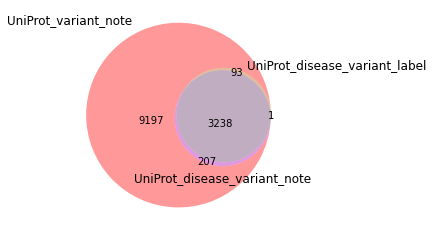

In [165]:
import matplotlib_venn as vplt
v = vplt.venn3(subsets={'100': sum(np.array(df.UniProt_variants_count>0, dtype=bool) * np.logical_not(df.UniProt_disease_variant_label=='Yes') * np.logical_not(df.UniProt_disease_variant_notes)), 
                        '010': sum(np.logical_not(df.UniProt_variants_count>0) * np.array(df.UniProt_disease_variant_label=='Yes', dtype=bool) * np.logical_not(df.UniProt_disease_variant_notes)), 
                        '001': sum(np.logical_not(df.UniProt_variants_count>0) * np.logical_not(df.UniProt_disease_variant_label=='Yes') * np.array(df.UniProt_disease_variant_notes, dtype=bool)), 
                        '110': sum(np.array(df.UniProt_variants_count>0, dtype=bool) * np.array(df.UniProt_disease_variant_label=='Yes', dtype=bool) * np.logical_not(df.UniProt_disease_variant_notes)), 
                        '101': sum(np.array(df.UniProt_variants_count>0, dtype=bool) * np.logical_not(df.UniProt_disease_variant_label=='Yes') * np.array(df.UniProt_disease_variant_notes, dtype=bool)), 
                        '011': sum(np.logical_not(df.UniProt_variants_count>0) * np.array(df.UniProt_disease_variant_label=='Yes', dtype=bool) * np.array(df.UniProt_disease_variant_notes, dtype=bool)), 
                        '111': sum(np.array(df.UniProt_variants_count>0, dtype=bool) * np.array(df.UniProt_disease_variant_label=='Yes', dtype=bool) * np.array(df.UniProt_disease_variant_notes, dtype=bool))},
               set_labels = ('UniProt_variant_note', 'UniProt_disease_variant_label', 'UniProt_disease_variant_note'))
#plt.show()

In [166]:
# targets in UniProt_disease_variant_label AND UniProt_disease_variant_notes
df[(df.UniProt_disease_variant_label=='Yes') & (df.UniProt_disease_variant_notes.apply(bool)==1)][['symbol','UniProt_disease_variant_label','UniProt_disease_variant_notes','UniProt_variant_notes']]

,symbol,UniProt_disease_variant_label,UniProt_disease_variant_notes,UniProt_variant_notes
0,EGFR,Yes,"[428, G -> D (in NISBD2; loss of function; the...","[(30..297, Missing (variant EGFR vIII; found i..."
6,MET,Yes,"[773, P -> L (in gastric cancer; dbSNP:rs77133...","[(143, R -> Q (in dbSNP:rs35469582)), (150, H ..."
7,CSF1R,Yes,"[132, P -> L (in BANDDOS; impairs phosphorylat...","[(32, V -> G (in dbSNP:rs56048668)), (132, P -..."
8,ERBB3,Yes,"[1337, A -> T (in FERLK; risk factor for eryth...","[(20, S -> Y (in dbSNP:rs34379766)), (30, P ->..."
9,FGFR2,Yes,"[105, Y -> C (in CS; dbSNP:rs1434545235), 172,...","[(6, R -> P (in dbSNP:rs3750819)), (57, S -> L..."
...,...,...,...,...
19466,MYOZ2,Yes,"[48, S -> P (in CMH16; dbSNP:rs199476398), 246...","[(48, S -> P (in CMH16; dbSNP:rs199476398)), (..."
19467,RSPH9,Yes,"[268, Missing (in CILD12)]","[(261, V -> I (in dbSNP:rs16896629)), (268, Mi..."
19470,LIPT2,Yes,"[30, L -> P (in NELABA; dbSNP:rs539962457), 10...","[(30, L -> P (in NELABA; dbSNP:rs539962457)), ..."
19471,PCARE,Yes,"[201, I -> F (in RP54; induces proteasomal deg...","[(13, S -> C (in dbSNP:rs10084168)), (201, I -..."


In [167]:
# targets in UniProt_disease_variant but NOT in UniProt_disease_variant_notes
df[(df.UniProt_disease_variant_label=='Yes') & (df.UniProt_disease_variant_notes.apply(bool)==0)][['symbol','UniProt_disease_variant_label','UniProt_disease_variant_notes','UniProt_variant_notes']]

,symbol,UniProt_disease_variant_label,UniProt_disease_variant_notes,UniProt_variant_notes
92,TOP2B,Yes,[],"[(63, H -> Y (probable disease-associated vari..."
211,DRD2,Yes,[],"[(154, V -> I (found in patients with alcohol-..."
230,GRIK2,Yes,[],"[(187, E -> Q (in a breast cancer sample; soma..."
268,MAOA,Yes,[],"[(15, D -> E (in a breast cancer sample; somat..."
646,KCND2,Yes,[],"[(404, V -> M (probable disease-associated var..."
...,...,...,...,...
17425,AANAT,Yes,[],"[(15, R -> C (in dbSNP:rs34470791)), (129, A -..."
17469,PDX1,Yes,[],"[(18, C -> R (risk factor for type 2 diabetes;..."
17485,STRA8,Yes,[],"[(25, T -> I (found in patients with non-obstr..."
17496,ANKRD1,Yes,[],"[(116, T -> M (found in a sporadic case of tot..."


In [168]:
# targets in UniProt_disease_variant_notes but NOT in UniProt_disease_variant
df[(df.UniProt_disease_variant_label!='Yes') & (df.UniProt_disease_variant_notes.apply(bool)==1)][['symbol','UniProt_disease_variant_label','UniProt_disease_variant_notes']]

,symbol,UniProt_disease_variant_label,UniProt_disease_variant_notes
1,KDR,No,"[482, C -> R (in HCI; associated with disease ..."
2,ERBB2,No,"[755, L -> P (in LNCR; somatic mutation; unkno..."
4,TOP1,No,"[326, K -> R (in breast cancer; somatic mutati..."
12,TOP2A,No,"[450, R -> Q (in teniposide (VM-26) resistant ..."
55,ACHE,No,"[353, H -> N (in Yt(b) antigen; dbSNP:rs1799805)]"
...,...,...,...
17703,FIGLA,No,"[140, Missing (in POF6; one individual with pr..."
17810,MBD5,No,"[144, T -> I (in MRD1; unknown pathological si..."
17944,HNF1B,No,"[36, S -> F (in RCAD; gain-of-function mutatio..."
18094,TBX6,No,"[111, M -> I (in congenital scoliosis; unknown..."


In [169]:
# save tables to file
# targets in UniProt_disease_variant_notes but NOT in UniProt_disease_variant
df[(df.UniProt_disease_variant_label!='Yes') & (df.UniProt_disease_variant_notes.apply(bool)==1)][['symbol','UniProt_disease_variant_label','UniProt_disease_variant_notes']].to_csv("/Users/melanie/tractability_project/Variation_data/UniProt_disease_variant_notes_to_check.csv", index=False)
# targets in UniProt_disease_variant but NOT in UniProt_disease_variant_notes
df[(df.UniProt_disease_variant_label=='Yes') & (df.UniProt_disease_variant_notes.apply(bool)==0)][['symbol','UniProt_disease_variant_label','UniProt_disease_variant_notes','UniProt_variant_notes']].to_csv("/Users/melanie/tractability_project/Variation_data/UniProt_disease_variant_notes_to_check2.csv", index=False)

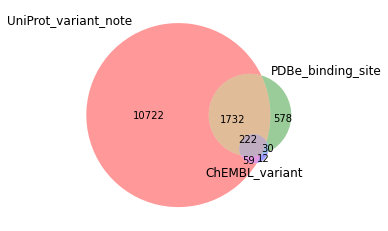

In [170]:
import matplotlib_venn as vplt
v = vplt.venn3(subsets={'100': sum(np.array(df.UniProt_variants_count>0, dtype=bool) * np.logical_not(df.binding_site_residues.apply(len)>0) * np.logical_not(df.ChEMBL_variant_residue.notna())), 
                        '010': sum(np.logical_not(df.UniProt_variants_count>0) * np.array(df.binding_site_residues.apply(len)>0, dtype=bool) * np.logical_not(df.ChEMBL_variant_residue.notna())), 
                        '001': sum(np.logical_not(df.UniProt_variants_count>0) * np.logical_not(df.binding_site_residues.apply(len)>0) * np.array(df.ChEMBL_variant_residue.notna(), dtype=bool)), 
                        '110': sum(np.array(df.UniProt_variants_count>0, dtype=bool) * np.array(df.binding_site_residues.apply(len)>0, dtype=bool) * np.logical_not(df.ChEMBL_variant_residue.notna())), 
                        '101': sum(np.array(df.UniProt_variants_count>0, dtype=bool) * np.logical_not(df.binding_site_residues.apply(len)>0) * np.array(df.ChEMBL_variant_residue.notna(), dtype=bool)), 
                        '011': sum(np.logical_not(df.UniProt_variants_count>0) * np.array(df.binding_site_residues.apply(len)>0, dtype=bool) * np.array(df.ChEMBL_variant_residue.notna(), dtype=bool)), 
                        '111': sum(np.array(df.UniProt_variants_count>0, dtype=bool) * np.array(df.binding_site_residues.apply(len)>0, dtype=bool) * np.array(df.ChEMBL_variant_residue.notna(), dtype=bool))},
               set_labels = ('UniProt_variant_note', 'PDBe_binding_site', 'ChEMBL_variant'))
#plt.show()

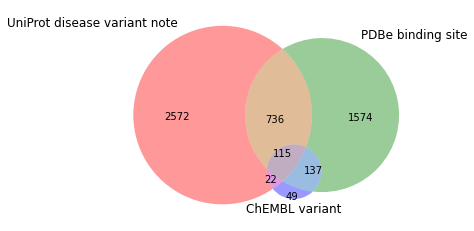

In [171]:
import matplotlib_venn as vplt
v = vplt.venn3(subsets={'100': sum(np.array(df.UniProt_disease_variant_notes, dtype=bool) * np.logical_not(df.binding_site_residues.apply(len)>0) * np.logical_not(df.ChEMBL_variant_residue.notna())), 
                        '010': sum(np.logical_not(df.UniProt_disease_variant_notes) * np.array(df.binding_site_residues.apply(len)>0, dtype=bool) * np.logical_not(df.ChEMBL_variant_residue.notna())), 
                        '001': sum(np.logical_not(df.UniProt_disease_variant_notes) * np.logical_not(df.binding_site_residues.apply(len)>0) * np.array(df.ChEMBL_variant_residue.notna(), dtype=bool)), 
                        '110': sum(np.array(df.UniProt_disease_variant_notes, dtype=bool) * np.array(df.binding_site_residues.apply(len)>0, dtype=bool) * np.logical_not(df.ChEMBL_variant_residue.notna())), 
                        '101': sum(np.array(df.UniProt_disease_variant_notes, dtype=bool) * np.logical_not(df.binding_site_residues.apply(len)>0) * np.array(df.ChEMBL_variant_residue.notna(), dtype=bool)), 
                        '011': sum(np.logical_not(df.UniProt_disease_variant_notes) * np.array(df.binding_site_residues.apply(len)>0, dtype=bool) * np.array(df.ChEMBL_variant_residue.notna(), dtype=bool)), 
                        '111': sum(np.array(df.UniProt_disease_variant_notes, dtype=bool) * np.array(df.binding_site_residues.apply(len)>0, dtype=bool) * np.array(df.ChEMBL_variant_residue.notna(), dtype=bool))},
               set_labels = ('UniProt disease variant note', 'PDBe binding site', 'ChEMBL variant'))
#plt.show()

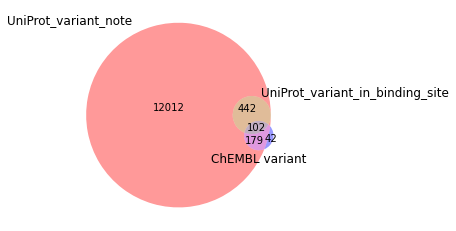

In [172]:
import matplotlib_venn as vplt
v = vplt.venn3(subsets={'100': sum(np.array(df.UniProt_variants_count>0, dtype=bool) * np.logical_not(df.UniProt_variant_in_binding_site_count>0) * np.logical_not(df.ChEMBL_variant_residue.notna())), 
                        '010': sum(np.logical_not(df.UniProt_variants_count>0) * np.array(df.UniProt_variant_in_binding_site_count>0, dtype=bool) * np.logical_not(df.ChEMBL_variant_residue.notna())), 
                        '001': sum(np.logical_not(df.UniProt_variants_count>0) * np.logical_not(df.UniProt_variant_in_binding_site_count>0) * np.array(df.ChEMBL_variant_residue.notna(), dtype=bool)), 
                        '110': sum(np.array(df.UniProt_variants_count>0, dtype=bool) * np.array(df.UniProt_variant_in_binding_site_count>0, dtype=bool) * np.logical_not(df.ChEMBL_variant_residue.notna())), 
                        '101': sum(np.array(df.UniProt_variants_count>0, dtype=bool) * np.logical_not(df.UniProt_variant_in_binding_site_count>0) * np.array(df.ChEMBL_variant_residue.notna(), dtype=bool)), 
                        '011': sum(np.logical_not(df.UniProt_variants_count>0) * np.array(df.UniProt_variant_in_binding_site_count>0, dtype=bool) * np.array(df.ChEMBL_variant_residue.notna(), dtype=bool)), 
                        '111': sum(np.array(df.UniProt_variants_count>0, dtype=bool) * np.array(df.UniProt_variant_in_binding_site_count>0, dtype=bool) * np.array(df.ChEMBL_variant_residue.notna(), dtype=bool))},
               set_labels = ('UniProt_variant_note', 'UniProt_variant_in_binding_site', 'ChEMBL variant'))
#plt.show()

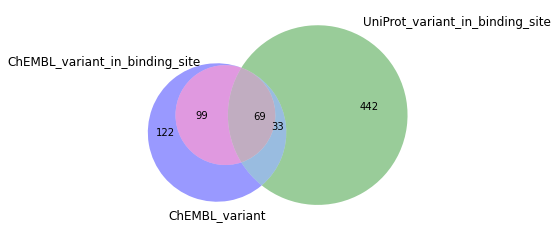

In [173]:
import matplotlib_venn as vplt
v = vplt.venn3(subsets={'100': sum(np.array(df.ChEMBL_variant_in_binding_site_count>0, dtype=bool) * np.logical_not(df.UniProt_variant_in_binding_site_count>0) * np.logical_not(df.ChEMBL_variant_residue.notna())), 
                        '010': sum(np.logical_not(df.ChEMBL_variant_in_binding_site_count>0) * np.array(df.UniProt_variant_in_binding_site_count>0, dtype=bool) * np.logical_not(df.ChEMBL_variant_residue.notna())), 
                        '001': sum(np.logical_not(df.ChEMBL_variant_in_binding_site_count>0) * np.logical_not(df.UniProt_variant_in_binding_site_count>0) * np.array(df.ChEMBL_variant_residue.notna(), dtype=bool)), 
                        '110': sum(np.array(df.ChEMBL_variant_in_binding_site_count>0, dtype=bool) * np.array(df.UniProt_variant_in_binding_site_count>0, dtype=bool) * np.logical_not(df.ChEMBL_variant_residue.notna())), 
                        '101': sum(np.array(df.ChEMBL_variant_in_binding_site_count>0, dtype=bool) * np.logical_not(df.UniProt_variant_in_binding_site_count>0) * np.array(df.ChEMBL_variant_residue.notna(), dtype=bool)), 
                        '011': sum(np.logical_not(df.ChEMBL_variant_in_binding_site_count>0) * np.array(df.UniProt_variant_in_binding_site_count>0, dtype=bool) * np.array(df.ChEMBL_variant_residue.notna(), dtype=bool)), 
                        '111': sum(np.array(df.ChEMBL_variant_in_binding_site_count>0, dtype=bool) * np.array(df.UniProt_variant_in_binding_site_count>0, dtype=bool) * np.array(df.ChEMBL_variant_residue.notna(), dtype=bool))},
               set_labels = ('ChEMBL_variant_in_binding_site', 'UniProt_variant_in_binding_site', 'ChEMBL_variant'))
#plt.show()

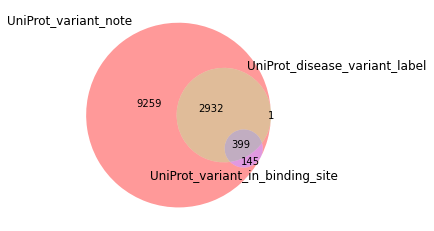

In [174]:
import matplotlib_venn as vplt
v = vplt.venn3(subsets={'100': sum(np.array(df.UniProt_variants_count>0, dtype=bool) * np.logical_not(df['UniProt_disease_variant_label']=='Yes') * np.logical_not(df.UniProt_variant_in_binding_site_count>0)), 
                        '010': sum(np.logical_not(df.UniProt_variants_count>0) * np.array(df['UniProt_disease_variant_label']=='Yes', dtype=bool) * np.logical_not(df.UniProt_variant_in_binding_site_count>0)), 
                        '001': sum(np.logical_not(df.UniProt_variants_count>0) * np.logical_not(df['UniProt_disease_variant_label']=='Yes') * np.array(df.UniProt_variant_in_binding_site_count>0, dtype=bool)), 
                        '110': sum(np.array(df.UniProt_variants_count>0, dtype=bool) * np.array(df['UniProt_disease_variant_label']=='Yes', dtype=bool) * np.logical_not(df.UniProt_variant_in_binding_site_count>0)), 
                        '101': sum(np.array(df.UniProt_variants_count>0, dtype=bool) * np.logical_not(df['UniProt_disease_variant_label']=='Yes') * np.array(df.UniProt_variant_in_binding_site_count>0, dtype=bool)), 
                        '011': sum(np.logical_not(df.UniProt_variants_count>0) * np.array(df['UniProt_disease_variant_label']=='Yes', dtype=bool) * np.array(df.UniProt_variant_in_binding_site_count>0, dtype=bool)), 
                        '111': sum(np.array(df.UniProt_variants_count>0, dtype=bool) * np.array(df['UniProt_disease_variant_label']=='Yes', dtype=bool) * np.array(df.UniProt_variant_in_binding_site_count>0, dtype=bool))},
               set_labels = ('UniProt_variant_note', 'UniProt_disease_variant_label', 'UniProt_variant_in_binding_site'))


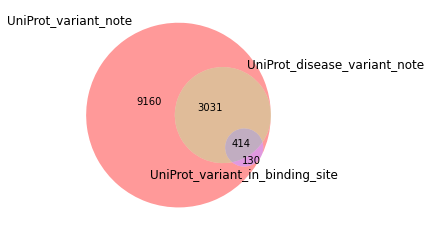

In [175]:
import matplotlib_venn as vplt
v = vplt.venn3(subsets={'100': sum(np.array(df.UniProt_variants_count>0, dtype=bool) * np.logical_not(df.UniProt_disease_variant_notes) * np.logical_not(df.UniProt_variant_in_binding_site_count>0)), 
                        '010': sum(np.logical_not(df.UniProt_variants_count>0) * np.array(df.UniProt_disease_variant_notes, dtype=bool) * np.logical_not(df.UniProt_variant_in_binding_site_count>0)), 
                        '001': sum(np.logical_not(df.UniProt_variants_count>0) * np.logical_not(df.UniProt_disease_variant_notes) * np.array(df.UniProt_variant_in_binding_site_count>0, dtype=bool)), 
                        '110': sum(np.array(df.UniProt_variants_count>0, dtype=bool) * np.array(df.UniProt_disease_variant_notes, dtype=bool) * np.logical_not(df.UniProt_variant_in_binding_site_count>0)), 
                        '101': sum(np.array(df.UniProt_variants_count>0, dtype=bool) * np.logical_not(df.UniProt_disease_variant_notes) * np.array(df.UniProt_variant_in_binding_site_count>0, dtype=bool)), 
                        '011': sum(np.logical_not(df.UniProt_variants_count>0) * np.array(df.UniProt_disease_variant_notes, dtype=bool) * np.array(df.UniProt_variant_in_binding_site_count>0, dtype=bool)), 
                        '111': sum(np.array(df.UniProt_variants_count>0, dtype=bool) * np.array(df.UniProt_disease_variant_notes, dtype=bool) * np.array(df.UniProt_variant_in_binding_site_count>0, dtype=bool))},
               set_labels = ('UniProt_variant_note', 'UniProt_disease_variant_note', 'UniProt_variant_in_binding_site'))


/Users/melanie/opt/anaconda3/lib/python3.7/site-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")


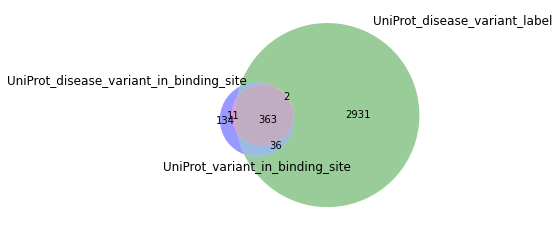

In [176]:
import matplotlib_venn as vplt
v = vplt.venn3(subsets={'100': sum(np.array(df.UniProt_disease_variant_in_binding_site_count>0, dtype=bool) * np.logical_not(df['UniProt_disease_variant_label']=='Yes') * np.logical_not(df.UniProt_variant_in_binding_site_count>0)), 
                        '010': sum(np.logical_not(df.UniProt_disease_variant_in_binding_site_count>0) * np.array(df['UniProt_disease_variant_label']=='Yes', dtype=bool) * np.logical_not(df.UniProt_variant_in_binding_site_count>0)), 
                        '001': sum(np.logical_not(df.UniProt_disease_variant_in_binding_site_count>0) * np.logical_not(df['UniProt_disease_variant_label']=='Yes') * np.array(df.UniProt_variant_in_binding_site_count>0, dtype=bool)), 
                        '110': sum(np.array(df.UniProt_disease_variant_in_binding_site_count>0, dtype=bool) * np.array(df['UniProt_disease_variant_label']=='Yes', dtype=bool) * np.logical_not(df.UniProt_variant_in_binding_site_count>0)), 
                        '101': sum(np.array(df.UniProt_disease_variant_in_binding_site_count>0, dtype=bool) * np.logical_not(df['UniProt_disease_variant_label']=='Yes') * np.array(df.UniProt_variant_in_binding_site_count>0, dtype=bool)), 
                        '011': sum(np.logical_not(df.UniProt_disease_variant_in_binding_site_count>0) * np.array(df['UniProt_disease_variant_label']=='Yes', dtype=bool) * np.array(df.UniProt_variant_in_binding_site_count>0, dtype=bool)), 
                        '111': sum(np.array(df.UniProt_disease_variant_in_binding_site_count>0, dtype=bool) * np.array(df['UniProt_disease_variant_label']=='Yes', dtype=bool) * np.array(df.UniProt_variant_in_binding_site_count>0, dtype=bool))},
               set_labels = ('UniProt_disease_variant_in_binding_site', 'UniProt_disease_variant_label', 'UniProt_variant_in_binding_site'))


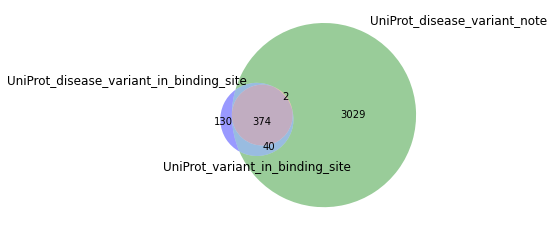

In [177]:
import matplotlib_venn as vplt
v = vplt.venn3(subsets={'100': sum(np.array(df.UniProt_disease_variant_in_binding_site_count>0, dtype=bool) * np.logical_not(df.UniProt_disease_variant_notes) * np.logical_not(df.UniProt_variant_in_binding_site_count>0)), 
                        '010': sum(np.logical_not(df.UniProt_disease_variant_in_binding_site_count>0) * np.array(df.UniProt_disease_variant_notes, dtype=bool) * np.logical_not(df.UniProt_variant_in_binding_site_count>0)), 
                        '001': sum(np.logical_not(df.UniProt_disease_variant_in_binding_site_count>0) * np.logical_not(df.UniProt_disease_variant_notes) * np.array(df.UniProt_variant_in_binding_site_count>0, dtype=bool)), 
                        '110': sum(np.array(df.UniProt_disease_variant_in_binding_site_count>0, dtype=bool) * np.array(df.UniProt_disease_variant_notes, dtype=bool) * np.logical_not(df.UniProt_variant_in_binding_site_count>0)), 
                        '101': sum(np.array(df.UniProt_disease_variant_in_binding_site_count>0, dtype=bool) * np.logical_not(df.UniProt_disease_variant_notes) * np.array(df.UniProt_variant_in_binding_site_count>0, dtype=bool)), 
                        '011': sum(np.logical_not(df.UniProt_disease_variant_in_binding_site_count>0) * np.array(df.UniProt_disease_variant_notes, dtype=bool) * np.array(df.UniProt_variant_in_binding_site_count>0, dtype=bool)), 
                        '111': sum(np.array(df.UniProt_disease_variant_in_binding_site_count>0, dtype=bool) * np.array(df.UniProt_disease_variant_notes, dtype=bool) * np.array(df.UniProt_variant_in_binding_site_count>0, dtype=bool))},
               set_labels = ('UniProt_disease_variant_in_binding_site', 'UniProt_disease_variant_note', 'UniProt_variant_in_binding_site'))


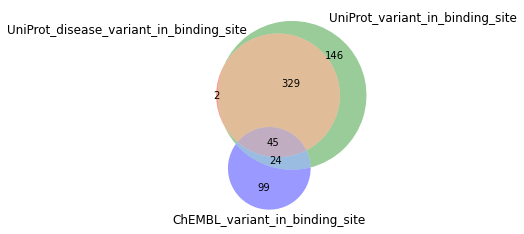

In [178]:
import matplotlib_venn as vplt
v = vplt.venn3(subsets={'100': sum(np.array(df.UniProt_disease_variant_in_binding_site_count>0, dtype=bool) * np.logical_not(df.UniProt_variant_in_binding_site_count>0) * np.logical_not(df.ChEMBL_variant_in_binding_site_count>0)), 
                        '010': sum(np.logical_not(df.UniProt_disease_variant_in_binding_site_count>0) * np.array(df.UniProt_variant_in_binding_site_count>0, dtype=bool) * np.logical_not(df.ChEMBL_variant_in_binding_site_count>0)), 
                        '001': sum(np.logical_not(df.UniProt_disease_variant_in_binding_site_count>0) * np.logical_not(df.UniProt_variant_in_binding_site_count>0) * np.array(df.ChEMBL_variant_in_binding_site_count>0, dtype=bool)), 
                        '110': sum(np.array(df.UniProt_disease_variant_in_binding_site_count>0, dtype=bool) * np.array(df.UniProt_variant_in_binding_site_count>0, dtype=bool) * np.logical_not(df.ChEMBL_variant_in_binding_site_count>0)), 
                        '101': sum(np.array(df.UniProt_disease_variant_in_binding_site_count>0, dtype=bool) * np.logical_not(df.UniProt_variant_in_binding_site_count>0) * np.array(df.ChEMBL_variant_in_binding_site_count>0, dtype=bool)), 
                        '011': sum(np.logical_not(df.UniProt_disease_variant_in_binding_site_count>0) * np.array(df.UniProt_variant_in_binding_site_count>0, dtype=bool) * np.array(df.ChEMBL_variant_in_binding_site_count>0, dtype=bool)), 
                        '111': sum(np.array(df.UniProt_disease_variant_in_binding_site_count>0, dtype=bool) * np.array(df.UniProt_variant_in_binding_site_count>0, dtype=bool) * np.array(df.ChEMBL_variant_in_binding_site_count>0, dtype=bool))},
               set_labels = ('UniProt_disease_variant_in_binding_site', 'UniProt_variant_in_binding_site', 'ChEMBL_variant_in_binding_site'))


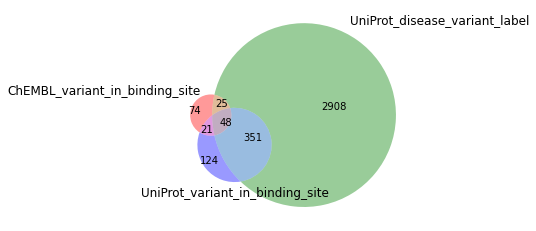

In [179]:
v = vplt.venn3(subsets={'100': sum(np.array(df.ChEMBL_variant_in_binding_site_count>0, dtype=bool) * np.logical_not(df['UniProt_disease_variant_label']=='Yes') * np.logical_not(df.UniProt_variant_in_binding_site_count>0)), 
                        '010': sum(np.logical_not(df.ChEMBL_variant_in_binding_site_count>0) * np.array(df['UniProt_disease_variant_label']=='Yes', dtype=bool) * np.logical_not(df.UniProt_variant_in_binding_site_count>0)), 
                        '001': sum(np.logical_not(df.ChEMBL_variant_in_binding_site_count>0) * np.logical_not(df['UniProt_disease_variant_label']=='Yes') * np.array(df.UniProt_variant_in_binding_site_count>0, dtype=bool)), 
                        '110': sum(np.array(df.ChEMBL_variant_in_binding_site_count>0, dtype=bool) * np.array(df['UniProt_disease_variant_label']=='Yes', dtype=bool) * np.logical_not(df.UniProt_variant_in_binding_site_count>0)), 
                        '101': sum(np.array(df.ChEMBL_variant_in_binding_site_count>0, dtype=bool) * np.logical_not(df['UniProt_disease_variant_label']=='Yes') * np.array(df.UniProt_variant_in_binding_site_count>0, dtype=bool)), 
                        '011': sum(np.logical_not(df.ChEMBL_variant_in_binding_site_count>0) * np.array(df['UniProt_disease_variant_label']=='Yes', dtype=bool) * np.array(df.UniProt_variant_in_binding_site_count>0, dtype=bool)), 
                        '111': sum(np.array(df.ChEMBL_variant_in_binding_site_count>0, dtype=bool) * np.array(df['UniProt_disease_variant_label']=='Yes', dtype=bool) * np.array(df.UniProt_variant_in_binding_site_count>0, dtype=bool))},
               set_labels = ('ChEMBL_variant_in_binding_site', 'UniProt_disease_variant_label', 'UniProt_variant_in_binding_site'))


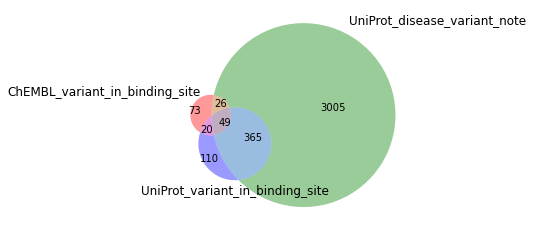

In [180]:
v = vplt.venn3(subsets={'100': sum(np.array(df.ChEMBL_variant_in_binding_site_count>0, dtype=bool) * np.logical_not(df.UniProt_disease_variant_notes) * np.logical_not(df.UniProt_variant_in_binding_site_count>0)), 
                        '010': sum(np.logical_not(df.ChEMBL_variant_in_binding_site_count>0) * np.array(df.UniProt_disease_variant_notes, dtype=bool) * np.logical_not(df.UniProt_variant_in_binding_site_count>0)), 
                        '001': sum(np.logical_not(df.ChEMBL_variant_in_binding_site_count>0) * np.logical_not(df.UniProt_disease_variant_notes) * np.array(df.UniProt_variant_in_binding_site_count>0, dtype=bool)), 
                        '110': sum(np.array(df.ChEMBL_variant_in_binding_site_count>0, dtype=bool) * np.array(df.UniProt_disease_variant_notes, dtype=bool) * np.logical_not(df.UniProt_variant_in_binding_site_count>0)), 
                        '101': sum(np.array(df.ChEMBL_variant_in_binding_site_count>0, dtype=bool) * np.logical_not(df.UniProt_disease_variant_notes) * np.array(df.UniProt_variant_in_binding_site_count>0, dtype=bool)), 
                        '011': sum(np.logical_not(df.ChEMBL_variant_in_binding_site_count>0) * np.array(df.UniProt_disease_variant_notes, dtype=bool) * np.array(df.UniProt_variant_in_binding_site_count>0, dtype=bool)), 
                        '111': sum(np.array(df.ChEMBL_variant_in_binding_site_count>0, dtype=bool) * np.array(df.UniProt_disease_variant_notes, dtype=bool) * np.array(df.UniProt_variant_in_binding_site_count>0, dtype=bool))},
               set_labels = ('ChEMBL_variant_in_binding_site', 'UniProt_disease_variant_note', 'UniProt_variant_in_binding_site'))


In [181]:
# Get symbols of the ones that are ChEMBL_variant_in_binding_site AND UniProt_disease_variant AND UniProt_variant_in_binding_site
', '.join(df.loc[(df.ChEMBL_variant_in_binding_site_count>0) & (df['UniProt_disease_variant_label']=='Yes') & (df.UniProt_variant_in_binding_site_count>0)].symbol.to_list())

'EGFR, MET, FGFR2, KIT, ESR1, ALK, NTRK1, CFTR, RET, CA2, FGFR1, BTK, HDAC8, AR, PIK3CA, CYP3A4, ABL1, NR3C1, VDR, ESR2, FGFR3, CASR, KCNQ2, DRD2, FGFR4, GNRHR, SMO, AKT1, CSNK2A1, KIF11, PSEN1, TP53, CDK13, BRDT, KRAS, RPS6KA3, PTPN11, ACVR1, PKLR, RAC1, RAB7A, RIPK1, GLB1, TDP1, EED, FTO, SMARCA2, HRAS'

In [182]:
# Get symbols of the ones that are ChEMBL_variant_in_binding_site AND UniProt_disease_variant AND UniProt_variant_in_binding_site
', '.join(df.loc[(df.ChEMBL_variant_in_binding_site_count>0) & (df['UniProt_disease_variant_label']=='Yes') & (df.UniProt_variant_in_binding_site_count>0)].symbol.to_list())

'EGFR, MET, FGFR2, KIT, ESR1, ALK, NTRK1, CFTR, RET, CA2, FGFR1, BTK, HDAC8, AR, PIK3CA, CYP3A4, ABL1, NR3C1, VDR, ESR2, FGFR3, CASR, KCNQ2, DRD2, FGFR4, GNRHR, SMO, AKT1, CSNK2A1, KIF11, PSEN1, TP53, CDK13, BRDT, KRAS, RPS6KA3, PTPN11, ACVR1, PKLR, RAC1, RAB7A, RIPK1, GLB1, TDP1, EED, FTO, SMARCA2, HRAS'

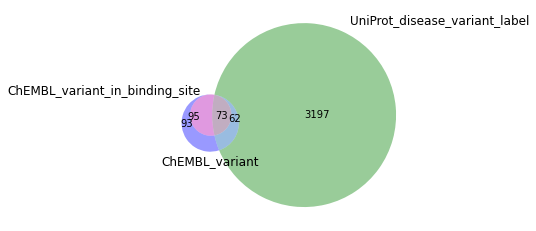

In [183]:
import matplotlib_venn as vplt
v = vplt.venn3(subsets={'100': sum(np.array(df.ChEMBL_variant_in_binding_site_count>0, dtype=bool) * np.logical_not(df['UniProt_disease_variant_label']=='Yes') * np.logical_not(df.ChEMBL_variant_residue.notna())), 
                        '010': sum(np.logical_not(df.ChEMBL_variant_in_binding_site_count>0) * np.array(df['UniProt_disease_variant_label']=='Yes', dtype=bool) * np.logical_not(df.ChEMBL_variant_residue.notna())), 
                        '001': sum(np.logical_not(df.ChEMBL_variant_in_binding_site_count>0) * np.logical_not(df['UniProt_disease_variant_label']=='Yes') * np.array(df.ChEMBL_variant_residue.notna(), dtype=bool)), 
                        '110': sum(np.array(df.ChEMBL_variant_in_binding_site_count>0, dtype=bool) * np.array(df['UniProt_disease_variant_label']=='Yes', dtype=bool) * np.logical_not(df.ChEMBL_variant_residue.notna())), 
                        '101': sum(np.array(df.ChEMBL_variant_in_binding_site_count>0, dtype=bool) * np.logical_not(df['UniProt_disease_variant_label']=='Yes') * np.array(df.ChEMBL_variant_residue.notna(), dtype=bool)), 
                        '011': sum(np.logical_not(df.ChEMBL_variant_in_binding_site_count>0) * np.array(df['UniProt_disease_variant_label']=='Yes', dtype=bool) * np.array(df.ChEMBL_variant_residue.notna(), dtype=bool)), 
                        '111': sum(np.array(df.ChEMBL_variant_in_binding_site_count>0, dtype=bool) * np.array(df['UniProt_disease_variant_label']=='Yes', dtype=bool) * np.array(df.ChEMBL_variant_residue.notna(), dtype=bool))},
               set_labels = ('ChEMBL_variant_in_binding_site', 'UniProt_disease_variant_label', 'ChEMBL_variant'))


In [184]:
len(df.loc[(df.ChEMBL_variant_in_binding_site_count>0) & (df['UniProt_disease_variant_label']=='Yes')])

73

In [185]:
# Get symbols of the ones that are ChEMBL_variant_in_binding_site AND UniProt_disease_variant
', '.join(df.loc[(df.ChEMBL_variant_in_binding_site_count>0) & (df['UniProt_disease_variant_label']=='Yes')].symbol.to_list())

'EGFR, MET, FGFR2, CXCR4, KIT, ESR1, ALK, NTRK1, CFTR, RET, SRC, CA2, FGFR1, BTK, ITK, HDAC8, AR, PIK3CA, CYP3A4, ABL1, CDK6, NR3C1, VDR, ESR2, FLT3, PDGFRA, FGFR3, DDR2, CASR, KCNQ2, GRIN2B, DRD2, MTOR, FGFR4, GNRHR, GHSR, SMO, PIK3CD, MALT1, P4HB, AKT1, CSNK2A1, PNP, KIF11, PSEN1, TP53, EPAS1, CDK13, BRDT, KRAS, RORC, RPS6KA3, PTPN11, VCP, ACVR1, CAMK2A, EP300, PKLR, RAC1, GALNT2, KYNU, PTPN22, RAB7A, RIPK1, GLB1, TDP1, EED, FTO, SMARCA2, KDM5B, HRAS, UBE2T, RHOA'

In [186]:
len(df.loc[(df.ChEMBL_variant_in_binding_site_count>0) & (df['UniProt_disease_variant_label']=='Yes') & (df.UniProt_variant_in_binding_site_count>0)])

48

In [187]:
# Get symbols of the ones that are ChEMBL_variant_in_binding_site AND UniProt_disease_variant AND UniProt_variant_in_binding_site
', '.join(df.loc[(df.ChEMBL_variant_in_binding_site_count>0) & (df['UniProt_disease_variant_label']=='Yes') & (df.UniProt_variant_in_binding_site_count>0)].symbol.to_list())

'EGFR, MET, FGFR2, KIT, ESR1, ALK, NTRK1, CFTR, RET, CA2, FGFR1, BTK, HDAC8, AR, PIK3CA, CYP3A4, ABL1, NR3C1, VDR, ESR2, FGFR3, CASR, KCNQ2, DRD2, FGFR4, GNRHR, SMO, AKT1, CSNK2A1, KIF11, PSEN1, TP53, CDK13, BRDT, KRAS, RPS6KA3, PTPN11, ACVR1, PKLR, RAC1, RAB7A, RIPK1, GLB1, TDP1, EED, FTO, SMARCA2, HRAS'

Subset for Anna: 
Targets where there is 
- a co-crystal structure, plus 
- ligand data in ChEMBL, plus 
- ideally variation data in ChEMBL for that ligand

In [188]:
df.columns

Index(['ensembl_gene_id', 'symbol', 'accession', 'Entry name', 'Protein names',
       'IDG_family', 'IDG_dtoclass', 'IDG_tdl', 'IDG_fam', 'GO_BioProcess',
       'GO_MolFunction', 'SM_B1_Approved Drug', 'SM_B2_Advanced Clinical',
       'SM_B3_Phase 1 Clinical', 'SM_B4_Structure with Ligand',
       'SM_B5_High-Quality Ligand', 'binding_site_residues',
       'UniProt_isoforms_count', 'Natural variant', 'UniProt_variants_count',
       'UniProt_mutagens_count', 'UniProt_variant_residues',
       'UniProt_variant_changes', 'UniProt_variant_notes',
       'UniProt_variant_single_change_residues',
       'UniProt_disease_variant_residues', 'UniProt_disease_variant_changes',
       'UniProt_disease_variant_notes',
       'UniProt_disease_variant_single_change_residues',
       'UniProt_variant_in_binding_site',
       'UniProt_variant_in_binding_site_list',
       'UniProt_variant_in_binding_site_count',
       'UniProt_variant_in_binding_site_change',
       'UniProt_disease_variant_in_b

In [189]:
# subset containing targets with ChEMBL variation data, crystal structure and affinity data in ChEMBL (pChEMBL>=5.5)
#df.loc[(df.ChEMBL_variant_residue.notna()) & (df['SM_B4_Structure with Ligand'] == 1) & (df.Bucket_5_sm == 1)].to_csv("/Users/melanie/tractability_project/Variation_data/targets_for_anna.csv", index=False)
len(df.loc[(df.ChEMBL_variant_residue.notna()) & (df['SM_B4_Structure with Ligand'] == 1) & (df['SM_B5_High-Quality Ligand'] == 1)])
#', '.join(df.loc[(df.ChEMBL_variant_residue.notna()) & (df['SM_B4_Structure with Ligand'] == 1) & (df.Bucket_5_sm == 1)].symbol.to_list())



238

## Focus on drug targets 

In [190]:
# drug targets
len(df.loc[(df['SM_B1_Approved Drug'] == 1)])

702

In [191]:
# drug targets with UniProt variation data
len(df.loc[(df.UniProt_variant_notes.str.len()!=0) & (df['SM_B1_Approved Drug'] == 1)])

566

In [192]:
# drug targets with UniProt disease variation data
len(df.loc[(df.UniProt_disease_variant_notes.str.len()!=0) & (df['SM_B1_Approved Drug'] == 1)])

303

In [193]:
# drug targets with ChEMBL variation data
len(df.loc[(df.ChEMBL_variant_residue.notna()) & (df['SM_B1_Approved Drug'] == 1)])

113

In [194]:
# drug targets with UniProt_variant_in_binding_site
len(df.loc[(df.UniProt_variant_in_binding_site == True) & (df['SM_B1_Approved Drug'] == 1)])
len(df.loc[(df.UniProt_variant_in_binding_site_count > 0) & (df['SM_B1_Approved Drug'] == 1)])

131

In [195]:
# drug targets with UniProt_disease_variant_in_binding_site
len(df.loc[(df.UniProt_disease_variant_in_binding_site == True) & (df['SM_B1_Approved Drug'] == 1)])
len(df.loc[(df.UniProt_disease_variant_in_binding_site_count > 0) & (df['SM_B1_Approved Drug'] == 1)])

90

In [196]:
# drug targets with ChEMBL_variant_in_binding_site
len(df.loc[(df['SM_B1_Approved Drug'] == 1) & (df.ChEMBL_variant_in_binding_site_count > 0)])

64

In [197]:
# drug targets with ChEMBLvariant_in_UniProt_variant
len(df.loc[(df['SM_B1_Approved Drug'] == 1) & (df.ChEMBLvariant_in_UniProt_variant_count > 0)])

36

In [198]:
# drug targets with ChEMBLvariant_in_UniProt_disease_variant
len(df.loc[(df['SM_B1_Approved Drug'] == 1) & (df.ChEMBLvariant_in_UniProt_disease_variant_count > 0)])

28

In [199]:
# drug targets with UniProt_variant_in_binding_site and ChEMBL variation data
len(df.loc[(df['SM_B1_Approved Drug'] == 1) & (df.UniProt_variant_in_binding_site_count > 0) & (df.ChEMBL_variant_residue.notna())])

51

In [200]:
# drug targets that with UniProt_disease_variant_in_binding_site AND ChEMBL variation data
len(df.loc[(df['SM_B1_Approved Drug']==1) & (df.UniProt_disease_variant_in_binding_site_count>0) & (df.ChEMBL_variant_residue.notna())])

38

In [201]:
# drug targets that with UniProt_disease_variant_in_binding_site AND ChEMBL_variant_in_binding_site
len(df.loc[(df['SM_B1_Approved Drug']==1) & (df.UniProt_disease_variant_in_binding_site_count>0) & (df.ChEMBL_variant_in_binding_site_count>0)])

26

In [202]:
# Get symbols of drug targets that are UniProt_disease_variant_in_binding_site AND ChEMBL_variant_in_binding_site
', '.join(df.loc[(df['SM_B1_Approved Drug']==1) & (df.UniProt_disease_variant_in_binding_site_count>0) & (df.ChEMBL_variant_in_binding_site_count>0)].symbol.to_list())

'TOP1, MET, FGFR2, KIT, ESR1, ALK, NTRK1, CFTR, RET, CA2, FGFR1, BTK, HDAC8, AR, PIK3CA, CYP3A4, ABL1, NR3C1, VDR, ESR2, IDH1, FGFR3, CASR, KCNQ2, FGFR4, GNRHR'

In [203]:
# drug targets that with UniProt_disease_variant_in_binding_site AND ChEMBLvariant_in_UniProt_disease_variant
len(df.loc[(df['SM_B1_Approved Drug']==1) & (df.UniProt_disease_variant_in_binding_site_count>0) & (df.ChEMBLvariant_in_UniProt_disease_variant_count>0)])

23

In [204]:
# Get symbols of drug targets that are UniProt_disease_variant_in_binding_site AND ChEMBL_variant_in_binding_site
', '.join(df.loc[(df['SM_B1_Approved Drug']==1) & (df.UniProt_disease_variant_in_binding_site_count>0) & (df.ChEMBLvariant_in_UniProt_disease_variant_count>0)].symbol.to_list())

'TOP1, MET, FGFR2, KIT, ALK, CFTR, RET, BRAF, CA2, TTR, BTK, GLA, HBB, AR, PIK3CA, VDR, IDH1, FGFR3, FGFR4, GNRHR, GAA, EZH2, IDH2'

up_id = 'P07550'
full_ligand_site_url = 'https://www.ebi.ac.uk/pdbe/graph-api/uniprot/ligand_sites/%s' % (up_id)

url = urllib2.urlopen(full_ligand_site_url)
response = url.read()
try: response = json.loads(response.decode())
except UnicodeDecodeError: response = json.loads(response)
#results = pd.json_normalize(response)  # pd.read_json(json.dumps(response), orient='records')
#results = pd.read_json(json.dumps(response), orient='records')
results = pd.read_json(json.dumps(response), orient='index')
results
# get df per UniProtID, row per ligand, and only get columns ['name','accession','residues']
df = pd.json_normalize(results['data'][0])[['name','accession','residues']]
df
# filter ligand accession based on ion & unwanted lists
# drop on condition
df = df.loc[~df['accession'].isin(ions) & ~df['accession'].isin(ligand_filter)].reset_index(drop=True)
df
pd.json_normalize(df['residues'][0]).filter(like='startIndex')['startIndex'].tolist()
df['residue_nums'] = df.apply(lambda x: pd.json_normalize(x['residues']).filter(like='startIndex')['startIndex'].tolist(), axis=1)
df
# combine all lists in column with pd.sum(), unique and order with set()
residue_nums = list(set(df['residue_nums'].sum()))
residue_nums